# This notebook executes the chained fit, the 2-point fit.

In [60]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [61]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [62]:
import pickle

In [63]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [64]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [65]:
data = {}
data['2pt'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt_A3'] = h5_dm.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4'] = h5_dm.get_3pt("a12m310_a_avg.h5", "V4", 3, 13)

In [66]:
# The averaged-set data
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

# The A3 and V4 3-point and Feynman-Hellman samples are combined into arrays of (A3, V4) pairs 
gv_avg_data['3pt_combined'] = np.array([ [ [gv_avg_data['3pt_A3'][i][j], gv_avg_data['3pt_V4'][i][j]] for j in range(len(gv_avg_data['3pt_A3'][i]))] for i in range(len(gv_avg_data['3pt_A3']))])
gv_avg_data['C^FH_combined'] = np.transpose(np.append([gv_avg_data['C^FH_A3'],], [gv_avg_data['C^FH_V4'],], axis = 0))


In [67]:
# Create functions to extract the necessary fit-parameters for each function, and to insert priors specific to a function into a more complete parameter list
# Create methods for forming a parameter subset for each of the 3 functions: 2-point, 3-point, Feynman-Hellman
def param_2pt(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_zs):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    return sub_p
      
def param_3pt(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_zs):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    return sub_p

def param_FH(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    return sub_p

In [68]:
# Now, create some methods for setting the full posterior, both used and unused variables 
def posterior_2pt(partial_post, full_prior):
    full_post = gv.BufferDict()
    
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = partial_post['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = partial_post['Ztilde{}'.format(k)]
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = full_prior['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = full_prior['gV4_{0}{1}'.format(n, m)]
            
    full_post['Z_FHmax'] = full_prior['Z_FHmax']
    full_post['log(FH_dEmax)'] = full_prior['log(FH_dEmax)']
        
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = full_prior['gA3_FHmax{}'.format(n)]
        full_post['gA3_{}FHmax'.format(n)] = full_prior['gA3_{}FHmax'.format(n)]
        full_post['gV4_FHmax{}'.format(n)] = full_prior['gV4_FHmax{}'.format(n)]
        full_post['gV4_{}FHmax'.format(n)] = full_prior['gV4_{}FHmax'.format(n)]
        
    full_post['gA3_FHmaxFHmax'] = full_prior['gA3_FHmaxFHmax']
    full_post['gV4_FHmaxFHmax'] = full_prior['gV4_FHmaxFHmax']
              
    return full_post          
              
def posterior_3pt(partial_post, full_prior):
    full_post = gv.BufferDict()
    
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = full_prior['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = full_prior['Ztilde{}'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = partial_post['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = partial_post['gV4_{0}{1}'.format(n, m)]
            
    full_post['Z_FHmax'] = full_prior['Z_FHmax']
    full_post['log(FH_dEmax)'] = full_prior['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = full_prior['gA3_FHmax{}'.format(n)]
        full_post['gA3_{}FHmax'.format(n)] = full_prior['gA3_{}FHmax'.format(n)]
        full_post['gV4_FHmax{}'.format(n)] = full_prior['gV4_FHmax{}'.format(n)]
        full_post['gV4_{}FHmax'.format(n)] = full_prior['gV4_{}FHmax'.format(n)]
        
    full_post['gA3_FHmaxFHmax'] = full_prior['gA3_FHmaxFHmax']
    full_post['gV4_FHmaxFHmax'] = full_prior['gV4_FHmaxFHmax']
              
    return full_post
              
def posterior_FH(partial_post, full_prior):
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = full_prior['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['log(dE{})'.format(k)] = full_prior['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = full_prior['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = full_prior['Ztilde{}'.format(k)] 
        
    for k in range(1, num_states_FH - 1):
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = full_prior['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = full_prior['gV4_{0}{1}'.format(n, m)]
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):    
            full_post['gA3_{0}{1}'.format(n, m)] = partial_post['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = partial_post['gV4_{0}{1}'.format(n, m)]
                        
    full_post['Z_FHmax'] = partial_post['Z{}'.format(num_states_FH - 1)]
    full_post['log(FH_dEmax)'] = partial_post['log(dE{})'.format(num_states_FH - 1)]
              
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = partial_post['gA3_{0}{1}'.format(num_states_FH-1, n)]
        full_post['gA3_{}FHmax'.format(n)] = partial_post['gA3_{0}{1}'.format(n, num_states_FH-1)]
        full_post['gV4_FHmax{}'.format(n)] = partial_post['gV4_{0}{1}'.format(num_states_FH-1, n)]
        full_post['gV4_{}FHmax'.format(n)] = partial_post['gV4_{0}{1}'.format(n, num_states_FH-1)]
        
    full_post['gA3_FHmaxFHmax'] = partial_post['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
    full_post['gV4_FHmaxFHmax'] = partial_post['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
      
    return full_post
    

In [69]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [70]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gA3_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gV4_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [71]:
num_states_FH = 1 # The number of states that the Feynman-Hellman sum needs

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                #print("n = ", n)
                #print("m = ", m)
                #print("En = ", En)
                #print("Em = ", Em)
                #print("e_Delta_nm = ", e_Delta_nm)
                #print("e_Delta_nm = ", e_Delta_mn)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH_A3(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #n = 0
    #while (n < num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            
        #n += 1
        
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    if(num_zs == num_states_FH):
        return (Csum_A3(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_A3(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH_V4(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #for n in range(num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    if(num_zs == num_states_FH):
        return (Csum_V4(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_V4(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))




def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [72]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 

#print(t_2d_array)
#print(t_1d_array)

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d


### Before doing the fit, the combined 3-point and Feynman-Hellman fitfunctions need to be tested

Some priors will be set, namely the ones used in testing the individual A3 and V4 fits. Then, the next step is to test the combined functions, compare with the individual A3 and V4 functions, and check to make sure that the output format is as expected. The individual functions have already been tested, so they can be assumed to work.

In [73]:
# Start by setting priors
num_zs = 5
num_states_FH = 2

test_priors = gv.BufferDict()
for n in range(num_zs):
    for m in range(num_zs):
        test_priors['gA3_{0}{1}'.format(n, m)] = gv.gvar(1, 2)
        if n == m and n < num_zs-1:
            test_priors['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            test_priors['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

for n in range(num_states_FH-1):
    test_priors['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
    test_priors['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
    test_priors['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    test_priors['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
test_priors['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
test_priors['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

test_priors['gA3_00'] = gv.gvar(1.25, 0.15)
test_priors['gV4_00'] = gv.gvar(1.07, 0.07) 

test_priors['E0'] = gv.gvar(0.665, 0.015)
test_priors['Z0'] = gv.gvar(0.0008, 0.0003)
test_priors['Ztilde0'] = gv.gvar(0.003, 0.003)

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = test_priors['E0'].mean
for k in range(1, num_zs):
    dEvals[k-1] = dE0
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for k in range(1, num_zs):
            
    #err_ratio = energyvals[k]/(energyvals[k] - (E0_errbar * dEvals[k-1]) )
            
    test_priors['Z{}'.format(k)] = gv.gvar(0.0008, 0.0004)
    test_priors['Ztilde{}'.format(k)] = gv.gvar(0, 0.005)
    test_priors['log(dE{})'.format(k)] = gv.gvar(np.log(dEvals[k-1]), 0.7)
    #test_priors['log(E{})'.format(k)] = gv.gvar(np.log(energyvals[k]), np.log(err_ratio))

# Set the "garbage can" for the Feynman Hellman fit
test_priors['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)
test_priors['Z_FHmax'] = gv.gvar(0.0008, 0.0004)



In [74]:
# Run the functions for the test (3 point) and print out the results for comparison
test_3pt_A3_1d = C_3pt_A3(t_1d_array, param_3pt(test_priors))
test_3pt_V4_1d = C_3pt_V4(t_1d_array, param_3pt(test_priors))
test_3pt_1d = C_3pt(t_1d_array, param_3pt(test_priors))

print('Sample 3-point tests: ')
print('A3: ', test_3pt_A3_1d[0], ' V4: ', test_3pt_V4_1d[0], '; total: ', test_3pt_1d[0])
print('A3: ', test_3pt_A3_1d[1], ' V4: ', test_3pt_V4_1d[1], '; total: ', test_3pt_1d[1])
print('A3: ', test_3pt_A3_1d[2], ' V4: ', test_3pt_V4_1d[2], '; total: ', test_3pt_1d[2])
print('A3: ', test_3pt_A3_1d[4], ' V4: ', test_3pt_V4_1d[4], '; total: ', test_3pt_1d[4])
print('A3: ', test_3pt_A3_1d[8], ' V4: ', test_3pt_V4_1d[8], '; total: ', test_3pt_1d[8])
print('shapes: A3: ', np.shape(test_3pt_A3_1d), ' V4: ', np.shape(test_3pt_V4_1d), '; total: ', np.shape(test_3pt_1d))

Sample 3-point tests: 
A3:  4.6(3.6)e-07  V4:  1.3(2.1)e-07 ; total:  [[4.6(3.6)e-07]
 [1.3(2.1)e-07]]
A3:  4.6(3.6)e-07  V4:  1.3(2.1)e-07 ; total:  [[4.6(3.6)e-07]
 [1.3(2.1)e-07]]
A3:  1.9(1.6)e-07  V4:  6.0(9.8)e-08 ; total:  [[1.9(1.6)e-07]
 [6.0(9.8)e-08]]
A3:  1.9(1.6)e-07  V4:  6.0(9.8)e-08 ; total:  [[1.9(1.6)e-07]
 [6.0(9.8)e-08]]
A3:  8.6(7.2)e-08  V4:  2.9(4.8)e-08 ; total:  [[8.6(7.2)e-08]
 [2.9(4.8)e-08]]
shapes: A3:  (65,)  V4:  (65,) ; total:  (65, 2, 1)


In [75]:
# Run the functions for the test (Feynman-Hellman) and print out the results for comparison
print(C_2pt_SS(tsep_vals, test_priors))
#print(test_priors)
test_FH_A3 = C_FH_A3(tsep_vals, test_priors)
test_FH_V4 = C_FH_V4(tsep_vals, test_priors)
test_FH = C_FH(tsep_vals, test_priors)

print('Sample Feynman-Hellman tests: ')
print('A3: ', test_FH_A3[0], ' V4: ', test_FH_V4[0], '; total: ', test_FH[0])
print('A3: ', test_FH_A3[1], ' V4: ', test_FH_V4[1], '; total: ', test_FH[1])
print('A3: ', test_FH_A3[4], ' V4: ', test_FH_V4[4], '; total: ', test_FH[4])
print('A3: ', test_FH_A3[7], ' V4: ', test_FH_V4[7], '; total: ', test_FH[7])

print('shapes: A3: ', np.shape(test_FH_A3), ' V4: ', np.shape(test_FH_V4), '; total: ', np.shape(test_FH))

print("Test-priors: ", test_priors)
print("Feynman-Hellman Test-priors: ", param_FH(test_priors))

[1.28(80)e-07 5.7(3.8)e-08 2.7(1.9)e-08 1.32(93)e-08 6.6(4.7)e-09
 3.3(2.4)e-09 1.7(1.2)e-09 8.5(6.4)e-10 4.3(3.3)e-10 2.2(1.7)e-10]
Sample Feynman-Hellman tests: 
A3:  1.9(1.1)  V4:  1.01(99) ; total:  [1.9(1.1) 1.01(99)]
A3:  1.78(94)  V4:  1.09(77) ; total:  [1.78(94) 1.09(77)]
A3:  1.48(58)  V4:  1.15(36) ; total:  [1.48(58) 1.15(36)]
A3:  1.34(32)  V4:  1.12(19) ; total:  [1.34(32) 1.12(19)]
shapes: A3:  (10,)  V4:  (10,) ; total:  (10, 2)
Test-priors:  {'gA3_00': 1.25(15),'gV4_00': 1.070(70),'gA3_01': 1.0(2.0),'gV4_01': 0.0(2.0),'gA3_02': 1.0(2.0),'gV4_02': 0.0(2.0),'gA3_03': 1.0(2.0),'gV4_03': 0.0(2.0),'gA3_04': 1.0(2.0),'gV4_04': 0.0(2.0),'gA3_10': 1.0(2.0),'gV4_10': 0.0(2.0),'gA3_11': 1.0(2.0),'gV4_11': 1.00(10),'gA3_12': 1.0(2.0),'gV4_12': 0.0(2.0),'gA3_13': 1.0(2.0),'gV4_13': 0.0(2.0),'gA3_14': 1.0(2.0),'gV4_14': 0.0(2.0),'gA3_20': 1.0(2.0),'gV4_20': 0.0(2.0),'gA3_21': 1.0(2.0),'gV4_21': 0.0(2.0),'gA3_22': 1.0(2.0),'gV4_22': 1.00(10),'gA3_23': 1.0(2.0),'gV4_23': 0.0(2.0),'gA

In [76]:
tau = 1
t_plot = np.array([i for i in range(1, 25)])
#gv_avg_data = gv.dataset.avg_data(data)
gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])

<ipython-input-76-a64387835c0b>:4: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
<ipython-input-76-a64387835c0b>:5: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
<ipython-input-76-a64387835c0b>:6: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))
<ipython-input-76-a64387835c0b>:8: RuntimeWarning: invalid value encountered in sqrt
  gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])


In [77]:

#y_3pt_A3

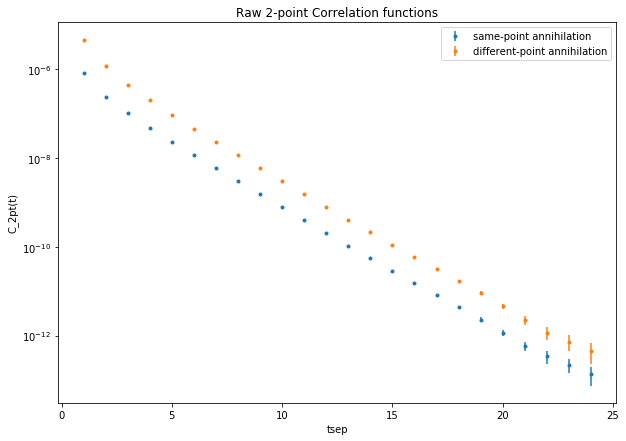

<Figure size 432x288 with 0 Axes>

In [78]:
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])

h5_dm.raw_data_plot("Raw 2-point Correlation functions", "tsep", "C_2pt(t)", x_raw2pt, y_raw2pt_mean, nplots = 2, yerror = y_raw2pt_sdev, legendlabels = labels_2pt, logy = True)


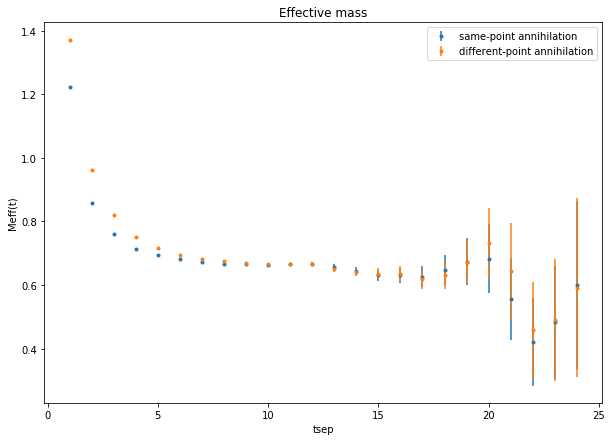

<Figure size 432x288 with 0 Axes>

In [79]:
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

h5_dm.raw_data_plot("Effective mass", "tsep", "Meff(t)", x_raw2pt, y_2ptmeff_mean, nplots = 2, yerror = y_2ptmeff_sdev, legendlabels = labels_2pt, logy = False)

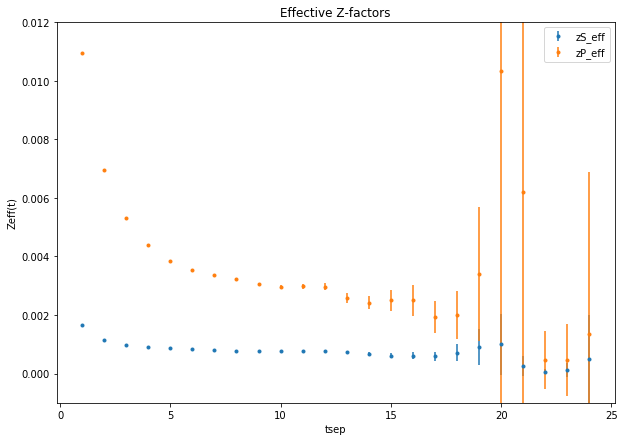

<Figure size 432x288 with 0 Axes>

In [80]:
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

zfactor_labels = np.array(["zS_eff", "zP_eff"])

h5_dm.raw_data_plot("Effective Z-factors", "tsep", "Zeff(t)", x_raw2pt, y_2ptZeff_mean, ylim=[-0.001, 0.012], nplots = 2, yerror =y_2ptZeff_sdev, legendlabels = zfactor_labels, logy = False)


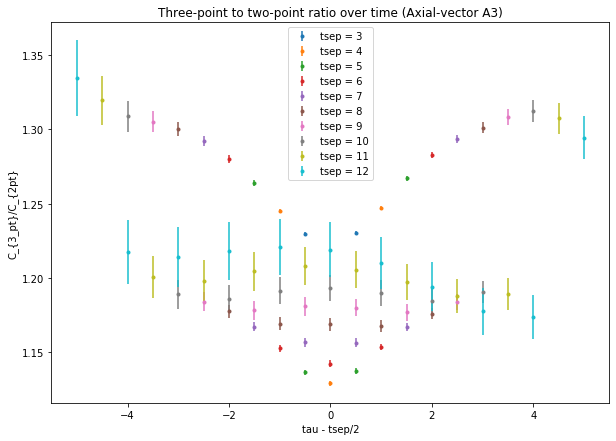

<Figure size 432x288 with 0 Axes>

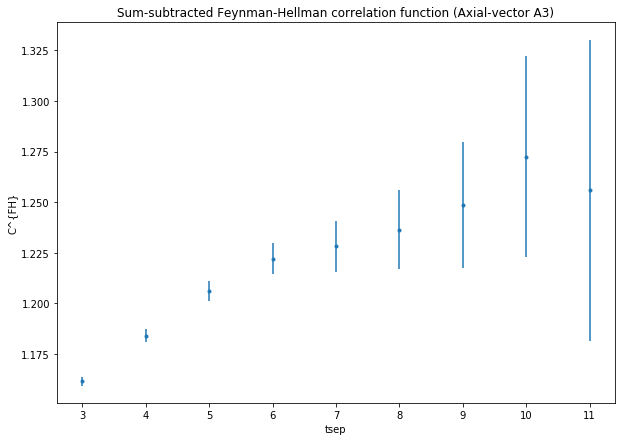

array([array([1.22948653, 1.23043176]),
       array([1.24511272, 1.12911504, 1.24715104]),
       array([1.26408926, 1.13658814, 1.13750236, 1.26702087]),
       array([1.28008458, 1.15262906, 1.1422122 , 1.15371275, 1.28268815]),
       array([1.29225314, 1.16738478, 1.15676178, 1.15649022, 1.16701901,
       1.29341666]),
       array([1.30047282, 1.17765951, 1.16929791, 1.16885643, 1.16799239,
       1.17608424, 1.30111217]),
       array([1.3053317 , 1.18410074, 1.17839337, 1.18089024, 1.18009565,
       1.17684057, 1.18371736, 1.30850508]),
       array([1.308739  , 1.18898057, 1.18585296, 1.1915555 , 1.19360608,
       1.18992162, 1.18465207, 1.19061616, 1.31255479]),
       array([1.31954103, 1.20073493, 1.19828447, 1.20454842, 1.20825628,
       1.20569305, 1.19718961, 1.18813916, 1.18905171, 1.30750971]),
       array([1.33476553, 1.21750185, 1.21433346, 1.2180195 , 1.22076375,
       1.21920319, 1.20997939, 1.19423515, 1.17762035, 1.17381691,
       1.29445138])], dtype=obje

<Figure size 432x288 with 0 Axes>

In [81]:
# 3-point to 2-point ratio plots: A3
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

h5_dm.raw_data_plot("Three-point to two-point ratio over time (Axial-vector A3)", "tau - tsep/2", 'C_{3_pt}/C_{2pt}', x_3pt, y_3pt_A3, nplots = len(gv_avg_data['C_ratio_A3']), yerror=y_3pt_A3_err, legendlabels=legendlabels_3pt)

# Feynman-Hellman correlation function plots: A3
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.raw_data_plot("Sum-subtracted Feynman-Hellman correlation function (Axial-vector A3)", "tsep", "C^{FH}", x_CFH, y_CFH_A3, yerror=y_CFH_A3_err)

y_3pt_A3

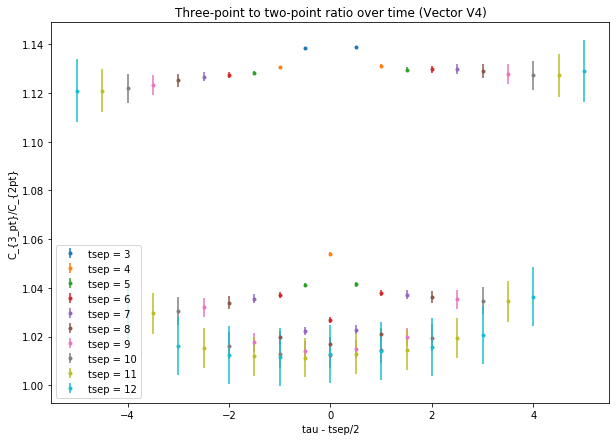

<Figure size 432x288 with 0 Axes>

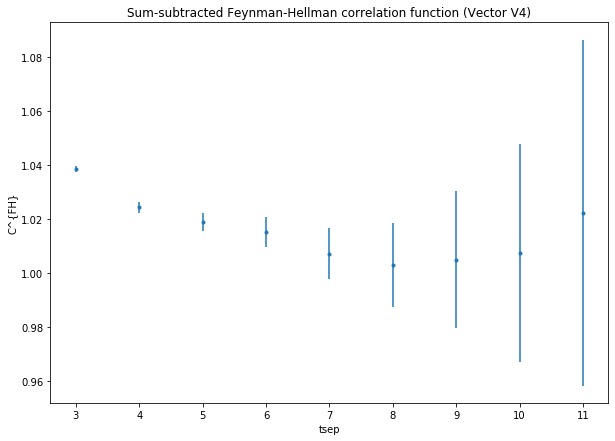

array([array([1.13833969, 1.13867445]),
       array([1.13046435, 1.05405451, 1.13120803]),
       array([1.128136  , 1.04105754, 1.04137951, 1.12960042]),
       array([1.12743401, 1.03713543, 1.02699379, 1.0380591 , 1.12970867]),
       array([1.12671144, 1.03561198, 1.02228803, 1.02289506, 1.03719896,
       1.12983023]),
       array([1.12512845, 1.03383404, 1.01969759, 1.01709532, 1.02096737,
       1.03625992, 1.12888266]),
       array([1.12324919, 1.03193001, 1.0176408 , 1.01421266, 1.01490023,
       1.01991447, 1.03522138, 1.12777717]),
       array([1.12185467, 1.0305348 , 1.01631509, 1.01271812, 1.01254469,
       1.01452087, 1.01948663, 1.03474667, 1.12723016]),
       array([1.12089497, 1.02948858, 1.0154146 , 1.01182729, 1.01139709,
       1.01270778, 1.01457203, 1.0194431 , 1.03442798, 1.12730683]),
       array([1.12099795, 1.02980727, 1.01596493, 1.0123937 , 1.0117844 ,
       1.01300062, 1.01421344, 1.01585988, 1.02058477, 1.03637859,
       1.12900519])], dtype=obje

<Figure size 432x288 with 0 Axes>

In [82]:
# 3-point to 2-point ratio plots: V4
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.raw_data_plot("Three-point to two-point ratio over time (Vector V4)", "tau - tsep/2", 'C_{3_pt}/C_{2pt}', x_3pt, y_3pt_V4, nplots = len(gv_avg_data['C_ratio_A3']), yerror=y_3pt_V4_err, legendlabels=legendlabels_3pt)

# Feynman-Hellman correlation function plots: V4
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.raw_data_plot("Sum-subtracted Feynman-Hellman correlation function (Vector V4)", "tsep", "C^{FH}", x_CFH, y_CFH_V4, yerror=y_CFH_V4_err)

y_3pt_V4

In [83]:
num_zs = 5
num_states_FH = 2

# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior_2ptstep['E0'] = gv.gvar(0.67, 0.02)
prior_2ptstep['Z0'] = gv.gvar(0.0008, 0.0003)
prior_2ptstep['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior_2ptstep['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior_2ptstep['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior_2ptstep['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        prior_2ptstep['gA3_{0}{1}'.format(n, m)] = gv.gvar(1, 2)
        if n == m and n < num_zs-1:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior_2ptstep['gA3_00'] = gv.gvar(1.25, 0.15)
prior_2ptstep['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
prior_2ptstep['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
prior_2ptstep['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior_2ptstep['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
    prior_2ptstep['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
    prior_2ptstep['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior_2ptstep['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
prior_2ptstep['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

#prior_2ptstep

0


In [84]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior = prior_2ptstep,fcn=C_2pt,debug=True)  
print(fit_2pt.format(pstyle='vv')) 
#post_2pt = posterior_2pt(fit_2pt.p, prior_2ptstep)

post_2pt = fit_2pt.p

#post_2pt
#chi2/dof [dof] = 0.9 [40]    Q = 0.66    logGBF = 990.18

Least Square Fit:
  chi2/dof [dof] = 0.82 [22]    Q = 0.7    logGBF = 484.04

Parameters:
             E0       0.659205 +- 0.00479119             [     0.67 +- 0.02 ]  
             Z0    0.00074785 +- 2.20243e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281936 +- 9.69383e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.0233 +- 0.397312             [  -0.97551 +- 0.7 ]  
             Z1   0.000552088 +- 0.000177765             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      0.0033844 +- 0.00163055             [        0 +- 0.01 ]  
       log(dE2)        -0.723191 +- 0.458657             [  -0.97551 +- 0.7 ]  
             Z2   0.000746991 +- 0.000302079             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00657521 +- 0.00244518             [        0 +- 0.01 ]  
       log(dE3)        -0.681219 +- 0.561889             [  -0.97551 +- 0.7 ]  
             Z3   0.000822364 +- 0.000403749             [ 0.0012 +- 0.0006 ]  
        Ztilde3        0.0026

In [85]:
# Create a covariance matrix for the posterior, and print it
#new = True
#covmat = gv.evalcorr([ post_2pt[key] for key in post_2pt.keys()])
#if new:
    #covmat_file = open('2pt_newcovmat.obj', 'wb')
#else:
    #covmat_file = open('2pt_oldcovmat.obj', 'wb')
#pickle.dump(covmat, covmat_file)
#covmat_file.close()

In [86]:
# pickle output params of the 2-point fit, then set the next prior, prior_3pt_A3step
#current_posterior = open('2pt_out.obj', 'wb')
#pickle.dump(post_2pt, current_posterior)
#current_posterior.close()

In [87]:
#next_priors = open('2pt_out.obj', 'rb')
#prior_3ptA3 = pickle.load(next_priors)
#next_priors.close()
#print(prior_3ptA3)

In [88]:
# A3 3-point fit 
# We'll need to use a flattened array of the x and y-values, in form: C_3pt(3,1), C_3pt(3,2), C_3pt(4,1), ..., C_3pt(4,3),   
# ..., C_3pt(12, 1), ..., C_3pt(12, 11)

y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])

y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)

#print(x_3pt)
print(np.shape(y_3pt_A3))
#print(len)
#fit_3pt_A3 = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt_A3), prior = prior_3ptA3, fcn = C_3pt_A3, debug = True)
#print(fit_3pt_A3.format(pstyle='vv'))
#post_3pt_A3 = fit_3pt_A3.p

(65,)


In [89]:
# pickle output params of the 3-point A3 fit, then set the next prior, prior_3pt_V4step
#current_posterior = open('3pt_A3_out.obj', 'wb')
#pickle.dump(post_3pt_A3, current_posterior)
#current_posterior.close()

In [90]:
#next_priors = open('3pt_A3_out.obj', 'rb')
#prior_3ptV4 = pickle.load(next_priors)
#next_priors.close()

In [91]:
# V4 3-point fit
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])

y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
print(np.shape(y_3pt_V4))
#print(y_3pt_V4, "\n")
#y_3pt_V4 = np.array([ gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0]) for i in range(len(tsep_vals))])
#print(np.shape(y_3pt_V4))
#print(y_3pt_V4)
#fit_3pt_V4 = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt_V4), prior=prior_3ptV4, fcn = C_3pt_V4, debug = True)
#print(fit_3pt_V4.format(pstyle='vv'))
#post_3pt_V4 = fit_3pt_V4.p

(65,)


In [92]:
# pickle output params of the 3-point V4 fit, then set the next prior, prior_CFH_A3step
#current_posterior = open('3pt_V4_out.obj', 'wb')
#pickle.dump(post_3pt_V4, current_posterior)
#current_posterior.close()

In [93]:
#next_priors = open('3pt_V4_out.obj', 'rb')
#prior_CFHA3 = pickle.load(next_priors)
#next_priors.close()

#covmat_post_2pt = gv.evalcorr([ post_2pt[key] for key in post_2pt.keys()])
#covmat_prior_3pt = gv.evalcorr([ prior_3pt[key] for key in prior_3pt.keys()])
#print(covmat_post_2pt)
#print(covmat_prior_3pt)
#for i in range(len(covmat_post_2pt)):
    #for j in range(len(covmat_post_2pt[i])):
        #if covmat_post_2pt[i][j] == covmat_prior_3pt[i][j]:
            #print("True")
        #else:
            #print("False")
#for key in prior_3pt:
    #if prior_3pt[key] == post_2pt[key]:
        #print("True")
        
    #else:
        #print("False")

In [94]:
#next_priors = open('2pt_out.obj', 'rb')
#prior_3pt = pickle.load(next_priors)
#next_priors.close()

In [95]:
# Combined 3-point fit

#print(np.shape( np.array([ np.array([gv_avg_data['3pt_combined'][i][j] for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals)) ]) ))
#y_3pt_2d =  np.array([ np.array([gv_avg_data['3pt_combined'][i][j] for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals)) ])
#y_3pt = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_2d)
#print(np.shape(y_3pt))

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
#print(np.shape(y_3pt))

#print(np.shape(np.array([ [gv_avg_data['3pt_combined'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))]) ))
#y_3pt_2d = np.array([ [ np.array(gv_avg_data['3pt_combined'][i][j]) for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
#y_3pt = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_2d)
#y_3pt = np.array([])
#for i in range(len(tsep_vals)):
    #for j in range(1, i+tsep_vals[0]):
        #y_3pt = np.append(y_3pt, np.array([gv_avg_data['3pt_combined'][i][j]]))
#print(np.shape(y_3pt_2d))
#print(np.shape(y_3pt))
#print(np.shape(t_1d_array))
#print(np.shape(C_3pt(t_1d_array, prior_3pt)))
#print(np.shape(gv_avg_data['3pt_combined']))
#print(y_3pt)
#prior_3pt = post_2pt
fit_3pt = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt), prior= post_2pt, fcn = C_3pt, debug = True) 
print(fit_3pt.format(pstyle='vv'))

#post_3pt = posterior_3pt(fit_3pt.p, prior_3pt)
post_3pt = fit_3pt.p
#chi2/dof [dof] = 0.99 [130]    Q = 0.51    logGBF = 3332.8
#chi2/dof [dof] = 1.2 [130]    Q = 0.042    logGBF = 3289.3

Least Square Fit:
  chi2/dof [dof] = 1.2 [130]    Q = 0.056    logGBF = 3346.9

Parameters:
             E0       0.655897 +- 0.00236433             [     0.659205 +- 0.00479119 ]  
             Z0   0.000735684 +- 9.01414e-06             [  0.00074785 +- 2.20243e-05 ]  
        Ztilde0    0.00276532 +- 3.83831e-05             [  0.00281936 +- 9.69383e-05 ]  
       log(dE1)       -0.854116 +- 0.0589221             [        -1.0233 +- 0.397312 ]  
             Z1   0.000734211 +- 2.78998e-05             [ 0.000552088 +- 0.000177765 ]  *
        Ztilde1    0.00465498 +- 0.000218654             [    0.0033844 +- 0.00163055 ]  
       log(dE2)        0.164742 +- 0.0620279             [      -0.723191 +- 0.458657 ]  *
             Z2      0.00119314 +- 8.815e-05             [ 0.000746991 +- 0.000302079 ]  *
        Ztilde2      0.0106659 +- 0.00101132             [   0.00657521 +- 0.00244518 ]  *
       log(dE3)        -0.772048 +- 0.387714             [      -0.681219 +- 0.561889 ]  
    

In [96]:
print(np.shape(t_1d_array))

(65, 2)


In [97]:
print(np.shape(y_3pt))
#new = True
#covmat_3pt = gv.evalcorr([ post_3pt[key] for key in post_3pt.keys()])
#if new:
    #covmat_file = open('3pt_newcovmat.obj', 'wb')
#else:
    #covmat_file = open('3pt_oldcovmat.obj', 'wb')
#pickle.dump(covmat_3pt, covmat_file)
#covmat_file.close()

(65, 2, 1)


In [98]:
#current_posterior = open('3pt_out.obj', 'wb')
#pickle.dump(post_3pt, current_posterior)
#current_posterior.close()

In [99]:
print(np.shape(np.array([l for l in tsep_vals[:-1]])))
print(np.shape(gv_avg_data['C^FH_A3']))
print(np.shape(np.array([gv_avg_data['C^FH_A3'][l] for l in range(len(tsep_vals[:-1]))])))

(9,)
(9,)
(9,)


In [100]:
# Feynman-Hellman fit, A3
#fit_CFH_A3 = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_A3'][l] for l in range(len(tsep_vals[:-1]))])), prior=prior_CFHA3,fcn=C_FH_A3,debug=True)
#print(fit_CFH_A3.format(pstyle='vv'))
#post_CFHA3 = fit_CFH_A3.p
#for key in post_3pt.keys():
    #print('"', key, '"', end = ", ")

In [101]:
# pickle output params of the Feynman-Hellman A3 fit, then set the next prior, prior_CFH_V4step
#current_posterior = open("CFH_A3_out.obj", 'wb')
#pickle.dump(post_CFHA3, current_posterior)
#current_posterior.close()

In [102]:
#next_priors = open("CFH_A3_out.obj", 'rb')
#prior_CFHV4 = pickle.load(next_priors)
#next_priors.close()

In [103]:
# Feynman-Hellman fit, V4
#fit_CFH_V4 = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_V4'][l] for l in range(len(tsep_vals[:-1]))])), prior=prior_CFHV4,fcn=C_FH_V4,debug=True)
#print(fit_CFH_V4.format(pstyle='vv'))

# Now, use the fit results to plot the 2-point fit, the Feynman-Hellman, and the C_ratio
# Then, try swapping the order of Feynman Hellman and 2-point fits.

In [104]:
# First, pickle the final posteriors
#post_CFHV4 = fit_CFH_V4.p
#final_posterior = open("Final(CFH_A3)_out.obj", 'wb')
#pickle.dump(post_CFHV4, final_posterior)
#final_posterior.close()
np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])
print(gv_avg_data['C^FH_combined'])

[[1.1615(22) 1.0387(11)]
 [1.1838(32) 1.0244(20)]
 [1.2061(49) 1.0192(34)]
 [1.2220(77) 1.0152(56)]
 [1.228(13) 1.0073(95)]
 [1.236(20) 1.003(16)]
 [1.249(31) 1.005(25)]
 [1.272(50) 1.008(40)]
 [1.256(75) 1.023(64)]]


In [105]:
# Unload priors for Feynman-Hellman
#next_priors = open('3pt_out.obj', 'rb')
#prior_CFH = pickle.load(next_priors)
#next_priors.close()
print("num_zs = ", num_zs)
print("num_states_FH = ", num_states_FH)

num_zs =  5
num_states_FH =  2


In [106]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_3pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv'))
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.65 [18]    Q = 0.86    logGBF = 51.925

Parameters:
             E0       0.656124 +- 0.00228208             [     0.655897 +- 0.00236433 ]  
             Z0   0.000736407 +- 8.61679e-06             [ 0.000735684 +- 9.01414e-06 ]  
        Ztilde0    0.00276767 +- 3.67216e-05             [  0.00276532 +- 3.83831e-05 ]  
       log(dE1)       -0.862307 +- 0.0550168             [     -0.854116 +- 0.0589221 ]  
             Z1   0.000726095 +- 2.60027e-05             [ 0.000734211 +- 2.78998e-05 ]  
        Ztilde1    0.00462231 +- 0.000208304             [  0.00465498 +- 0.000218654 ]  
       log(dE2)        0.162226 +- 0.0608355             [      0.164742 +- 0.0620279 ]  
             Z2      0.0012028 +- 8.3953e-05             [    0.00119314 +- 8.815e-05 ]  
        Ztilde2      0.0106343 +- 0.00100174             [    0.0106659 +- 0.00101132 ]  
       log(dE3)        -0.753436 +- 0.384015             [      -0.772048 +- 0.387714 ]  
         

In [107]:
final_posterior = open("Final(CFH)_out.obj", 'wb')
pickle.dump(post_CFH, final_posterior)
final_posterior.close()
print("E0 = ", post_2pt['E0'], " for 2-point; E0 = ", post_3pt['E0'], " for 3-point; E0 = ", post_CFH['E0'], " for Feynman-Hellman")

E0 =  0.6592(48)  for 2-point; E0 =  0.6559(24)  for 3-point; E0 =  0.6561(23)  for Feynman-Hellman


In [108]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)
print(post_CFH['Z1'])
#C2ptSS_model = C_2pt_SS(tsep_model, post_CFHV4)
#C2ptPS_model = C_2pt_PS(tsep_model, post_CFHV4)
C2ptSS_model = C_2pt_SS(tsep_model, post_CFH)
C2ptPS_model = C_2pt_PS(tsep_model, post_CFH)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

0.000726(26)


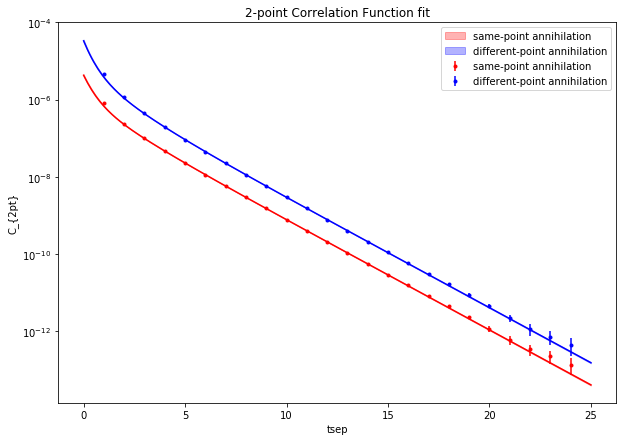

<Figure size 432x288 with 0 Axes>

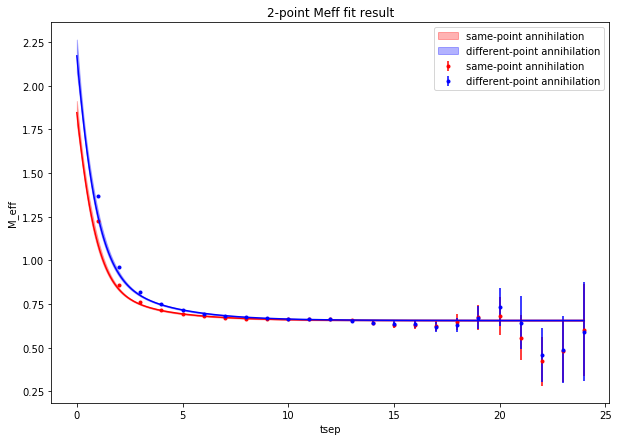

<Figure size 432x288 with 0 Axes>

In [109]:
# Plot the fits
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

#y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
#y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

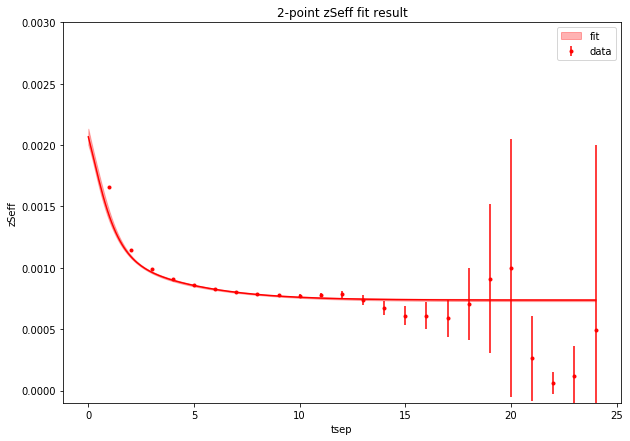

<Figure size 432x288 with 0 Axes>

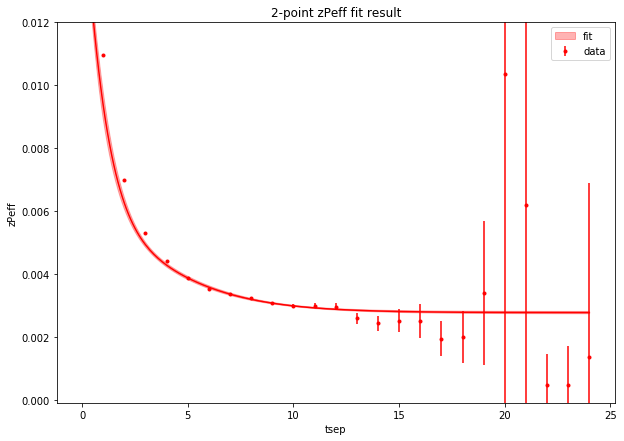

<Figure size 432x288 with 0 Axes>

In [110]:
# Now, plot the fit results of zS_eff and zP_eff
#y_2ptzSeff_fit_mean = np.array([zSeff_model_mean, PS_meff_model_mean])
#y_2ptzSeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
#y_2ptzSeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#y_2ptzPeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
#y_2ptzPeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
#y_2ptzPeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")



In [111]:
# Now, plot out the 3-point function
# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4
#model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_CFHV4)
#model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_CFHV4)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_CFH)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_CFH)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function
#model_ratio_2pt = C_2pt_SS(tsep_vals, post_CFHV4)
model_ratio_2pt = C_2pt_SS(tsep_vals, post_CFH)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
print(t_3pt_tseptau_diff)

[array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5])
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])
 array([-1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5,
       -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,
        0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5])
 array([-2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. ,
       -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,
        0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,
        1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ])
 array([-2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8, -1.7, -1.6, -1.5,
       -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4,
       -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,
        0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,
     

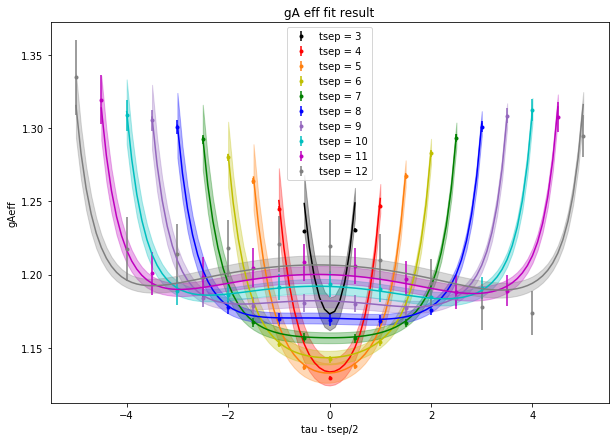

<Figure size 432x288 with 0 Axes>

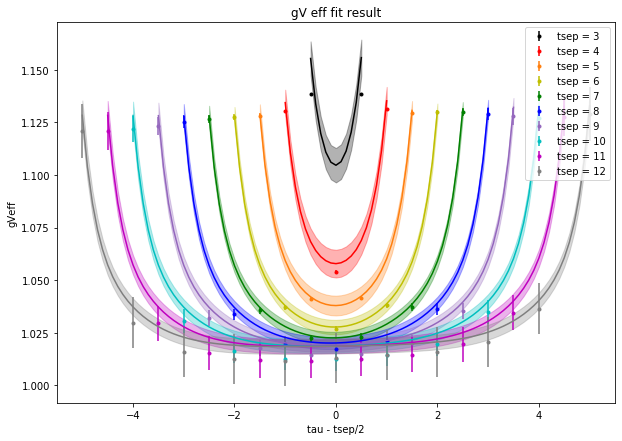

<Figure size 432x288 with 0 Axes>

In [112]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 


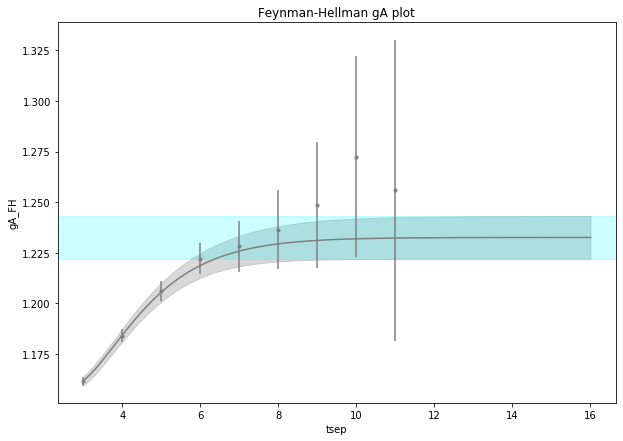

<Figure size 432x288 with 0 Axes>

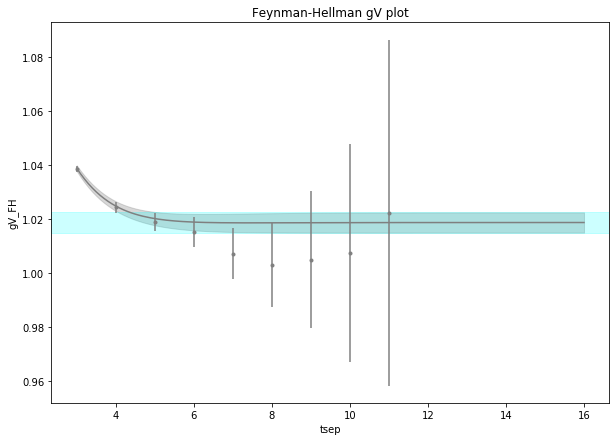

<Figure size 432x288 with 0 Axes>

In [113]:
# And finally, plot the Feynman-Hellman fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

#CFH_A3_model = C_FH_A3(t_FH_model, post_CFHV4)
#CFH_V4_model = C_FH_V4(t_FH_model, post_CFHV4)
CFH_A3_model = C_FH_A3(t_FH_model, post_CFH)
CFH_V4_model = C_FH_V4(t_FH_model, post_CFH)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

#h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_CFHV4['gA3_00'], ydat_error=y_CFH_A3_err) 
#h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_CFHV4['gV4_00'], ydat_error=y_CFH_V4_err)

h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_CFH['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_CFH['gV4_00'], ydat_error=y_CFH_V4_err)


#### Now, vary the width of the first excited state, the tau-bounds (calculated as distance from 0 of the minimum and from tsep of the maximum

Set the arrays over which to loop over and the priors and 3-point data-sets to use at each iteration

In [114]:
# Create arrays for the parameters that will be varied
b = np.array([0.1, 0.3, 0.5, 0.7, 1.0])
#tsep_mins = np.array([3, 7, 10])
tau_cuts = np.arange(1,4,1)
n_z_vals = np.arange(3,8,1)
n_FH_vals = np.array([2, 3])

n_zFH_combined = np.arange(6, 16, 1) # these n-values are there to encode both num_zs and n_FH
zFH_splitted = 2 #The number such that n_zFH_combined/2 is num_zs and (n_zFH_combined % 2) + 2 is num_states_FH

In [115]:
# set priors for each dE-set, num-z set, and num-FH-set
priors = []
for i in range(3):
    priors.append([])
    for j in range(len(b)):
        priors[i].append([])
        for k in range(len(n_zFH_combined)):
            priors[i][j].append(gv.BufferDict())
            
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            e_decay_exp = i
            
            priors[i][j][k]['E0'] = gv.gvar(0.67, 0.02)
            priors[i][j][k]['Z0'] = gv.gvar(0.0008, 0.0003)
            priors[i][j][k]['Ztilde0'] = gv.gvar(0.003, 0.003)

            # Define some constants for prioring the higher-order energies
            dE0 = 2*mpi

            # Use constant dE to prior the energies
            energyvals = np.array([None]*num_zs)
            dEvals = np.array([None]*(num_zs - 1))

            #E0_errbar = 0.8
            energyvals[0] = gv.gvar(0.67, 0.02)
            for n in range(1, num_zs):
                dEvals[n-1] = dE0/np.power(n, e_decay_exp)
                energyvals[n] = energyvals[n-1] + dEvals[n-1]
            
            priors[i][j][k]['log(dE1)'] = gv.gvar(np.log(dEvals[0]), b[j])
            priors[i][j][k]['Z1'] = gv.gvar(0.0012, 0.0006)
            priors[i][j][k]['Ztilde1'] = gv.gvar(0, 0.01)
            
            for n in range(2, num_zs):
                priors[i][j][k]['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), 0.7)
                priors[i][j][k]['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
                priors[i][j][k]['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)


            for n in range(num_zs):
                for m in range(num_zs):
        
                    priors[i][j][k]['gA3_{0}{1}'.format(n, m)] = gv.gvar(1, 2)
                    if n == m and n < num_zs-1:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
                    else:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

            priors[i][j][k]['gA3_00'] = gv.gvar(1.25, 0.15)
            priors[i][j][k]['gV4_00'] = gv.gvar(1.07, 0.07)

            # Set the "garbage can" for the Feynman Hellman fit
            priors[i][j][k]['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
            if num_states_FH == 2:
                priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b[j])
            else:
                priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)

            for n in range(num_states_FH-1):
                priors[i][j][k]['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
                priors[i][j][k]['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
                priors[i][j][k]['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
                priors[i][j][k]['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
            priors[i][j][k]['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
            priors[i][j][k]['gV4_FHmaxFHmax'] = gv.gvar(0, 2)
            
            

In [116]:
list_LogGBF_a0_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a0_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a0_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a1_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a1_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a1_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a2_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a2_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a2_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))



In [117]:
# Create 3-point datasets for each tau-cut data set
tau_cut_to_min_tsep = np.array([3, 4, 6])
x_vals_3fit = []
y_vals_3fit = []

y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

for i in range(len(tau_cuts)):
    x_vals_3fit.append([])
    y_vals_3fit.append([])
    
    for k in range(len(t_1d_array)):
        if(t_1d_array[k][0] >= tau_cut_to_min_tsep[i]):
            if(t_1d_array[k][1] >= tau_cuts[i]):
                if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cuts[i]):
                    x_vals_3fit[i].append(t_1d_array[k].tolist())
                    y_vals_3fit[i].append(y_3pt[k].tolist())
                            
    x_vals_3fit[i] = np.array(x_vals_3fit[i])
    y_vals_3fit[i] = np.array(y_vals_3fit[i])

In [118]:
for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            
            fit_a0_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[0][i][k],fcn=C_2pt,debug=True)
            fit_a1_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[1][i][k],fcn=C_2pt,debug=True)
            fit_a2_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[2][i][k],fcn=C_2pt,debug=True)
                
            fit_a0_3pt = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a0_2pt.p,fcn=C_3pt,debug=True)
            fit_a1_3pt = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a1_2pt.p,fcn=C_3pt,debug=True)
            fit_a2_3pt = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a2_2pt.p,fcn=C_3pt,debug=True)
                
            fit_a0 = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=fit_a0_3pt.p,fcn=C_FH,debug=True)
            fit_a1 = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=fit_a1_3pt.p,fcn=C_FH,debug=True)
            fit_a2 = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=fit_a2_3pt.p,fcn=C_FH,debug=True)
            
            
            print("dE constant, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a0.format(pstyle='vv'))    
            list_LogGBF_a0_2pt[i][j][k] = fit_a0_2pt.logGBF
            list_LogGBF_a0_3pt[i][j][k] = fit_a0_3pt.logGBF
            list_LogGBF_a0_FH[i][j][k] = fit_a0.logGBF
            list_Q_a0_2pt[i][j][k] = fit_a0_2pt.Q
            list_Q_a0_3pt[i][j][k] = fit_a0_3pt.Q
            list_Q_a0_FH[i][j][k] = fit_a0.Q
            list_E0_a0[i][j][k] = fit_a0.p['E0']
            list_gA00_a0[i][j][k] = fit_a0.p['gA3_00']
            list_gV00_a0[i][j][k] = fit_a0.p['gV4_00']
                
            print("dE proportional to 1/n, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a1.format(pstyle='vv')) 
            list_LogGBF_a1_2pt[i][j][k] = fit_a1_2pt.logGBF
            list_LogGBF_a1_3pt[i][j][k] = fit_a1_3pt.logGBF
            list_LogGBF_a1_FH[i][j][k] = fit_a1.logGBF
            list_Q_a1_2pt[i][j][k] = fit_a1_2pt.Q
            list_Q_a1_3pt[i][j][k] = fit_a1_3pt.Q
            list_Q_a1_FH[i][j][k] = fit_a1.Q
            list_E0_a1[i][j][k] = fit_a1.p['E0']
            list_gA00_a1[i][j][k] = fit_a1.p['gA3_00']
            list_gV00_a1[i][j][k] = fit_a2.p['gV4_00']
                
            print("dE proportional to 1/n^2, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a2.format(pstyle='vv'))
            list_LogGBF_a2_2pt[i][j][k] = fit_a2_2pt.logGBF
            list_LogGBF_a2_3pt[i][j][k] = fit_a2_3pt.logGBF
            list_LogGBF_a2_FH[i][j][k] = fit_a2.logGBF
            list_Q_a2_2pt[i][j][k] = fit_a2_2pt.Q
            list_Q_a2_3pt[i][j][k] = fit_a2_3pt.Q
            list_Q_a2_FH[i][j][k] = fit_a2.Q
            list_E0_a2[i][j][k] = fit_a2.p['E0']
            list_gA00_a2[i][j][k] = fit_a2.p['gA3_00']
            list_gV00_a2[i][j][k] = fit_a2.p['gV4_00']
                


dE constant, log(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.7 [18]    Q = 0.028    logGBF = 36.764

Parameters:
             E0       0.679431 +- 0.00102288             [     0.679425 +- 0.00102799 ]  
             Z0   0.000804741 +- 2.63669e-06             [ 0.000804627 +- 2.65809e-06 ]  
        Ztilde0    0.00310791 +- 1.18342e-05             [  0.00310733 +- 1.19243e-05 ]  
       log(dE1)      -0.102256 +- 0.00791725             [     -0.100592 +- 0.0079304 ]  
             Z1    0.00112372 +- 5.62442e-06             [  0.00112584 +- 5.69223e-06 ]  
        Ztilde1    0.00839823 +- 4.97806e-05             [   0.00841446 +- 4.9921e-05 ]  
       log(dE2)       0.830426 +- 0.00606103             [      0.831198 +- 0.0060706 ]  
             Z2    0.00182668 +- 6.47921e-06             [  0.00182553 +- 6.51905e-06 ]  
        Ztilde2     0.0138053 +- 6.28062e-05             [   0.0137996 +- 6.28709e-05 ]  
         gA3_00 

dE constant, log(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 59 [18]    Q = 2.9e-213    logGBF = -450.79

Parameters:
             E0     0.684881 +- 0.000980408            [     0.679425 +- 0.00102799 ]  *****
             Z0   0.00082838 +- 2.40611e-06            [ 0.000804627 +- 2.65809e-06 ]  *****
        Ztilde0   0.00321781 +- 1.06841e-05            [  0.00310733 +- 1.19243e-05 ]  *****
       log(dE1)    -0.0152393 +- 0.00608801            [    -0.100592 +- 0.00793041 ]  *****
             Z1   0.00109385 +- 5.22785e-06            [  0.00112584 +- 5.69223e-06 ]  *****
        Ztilde1   0.00861609 +- 4.77536e-05            [   0.00841446 +- 4.9921e-05 ]  ****
       log(dE2)      0.884016 +- 0.00518848            [     0.831198 +- 0.00607059 ]  *****
             Z2     0.00192451 +- 4.354e-06            [  0.00182553 +- 6.51905e-06 ]  *****
        Ztilde2    0.0140891 +- 6.05368e-05            [   0.0137996 +- 6.28709e

Least Square Fit:
  chi2/dof [dof] = 67 [18]    Q = 1.1e-244    logGBF = -524.26

Parameters:
             E0       0.686551 +- 0.00098008             [      0.679854 +- 0.0010316 ]  *****
             Z0   0.000832684 +- 2.40374e-06             [  0.00080445 +- 2.67655e-06 ]  *****
        Ztilde0    0.00323456 +- 1.06596e-05             [  0.00310328 +- 1.19928e-05 ]  *****
       log(dE1)    -0.00587913 +- 0.00621067             [    -0.108078 +- 0.00805983 ]  *****
             Z1   -0.00108364 +- 5.19444e-06             [ -0.00112325 +- 5.73199e-06 ]  *****
        Ztilde1    -0.00861476 +- 4.7822e-05             [ -0.00838166 +- 5.00699e-05 ]  ****
       log(dE2)       0.884863 +- 0.00499556             [       0.82464 +- 0.0058662 ]  *****
             Z2   -0.00191863 +- 4.15129e-06             [ -0.00180689 +- 6.25998e-06 ]  *****
        Ztilde2    -0.0139868 +- 5.84495e-05             [  -0.0136604 +- 6.06663e-05 ]  *****
         gA3_00         1.08409 +- 0.0017317        

Least Square Fit:
  chi2/dof [dof] = 0.55 [18]    Q = 0.94    logGBF = 50.301

Parameters:
             E0       0.660191 +- 0.00192658             [     0.659959 +- 0.00194157 ]  
             Z0   0.000752715 +- 6.50386e-06             [ 0.000751831 +- 6.57474e-06 ]  
        Ztilde0     0.00284123 +- 2.8368e-05             [  0.00283745 +- 2.86941e-05 ]  
       log(dE1)       -0.805174 +- 0.0335107             [     -0.808022 +- 0.0341122 ]  
             Z1    0.00068333 +- 1.82908e-05             [ 0.000686554 +- 1.83628e-05 ]  
        Ztilde1    0.00456962 +- 0.000139216             [  0.00456812 +- 0.000141227 ]  
       log(dE2)         -0.5369 +- 0.0363961             [     -0.526367 +- 0.0369463 ]  
             Z2   0.000909954 +- 5.52412e-05             [  0.00090915 +- 5.53032e-05 ]  
        Ztilde2     0.00121506 +- 0.00207456             [   0.00152948 +- 0.00209567 ]  
       log(dE3)          1.2738 +- 0.0387018             [       1.27967 +- 0.0388143 ]  
         

dE constant, log(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.33 [18]    Q = 1    logGBF = 50.888

Parameters:
             E0       0.661251 +- 0.00207355             [     0.661225 +- 0.00207951 ]  
             Z0   0.000758513 +- 7.31873e-06             [ 0.000758335 +- 7.34117e-06 ]  
        Ztilde0      0.0028718 +- 3.1473e-05             [  0.00287109 +- 3.15548e-05 ]  
       log(dE1)       -0.914733 +- 0.0551358             [     -0.917198 +- 0.0552997 ]  
             Z1   0.000493283 +- 3.11072e-05             [ 0.000493802 +- 3.13325e-05 ]  
        Ztilde1    0.00340459 +- 0.000200608             [  0.00339779 +- 0.000201289 ]  
       log(dE2)       -0.449791 +- 0.0539898             [       -0.445089 +- 0.05425 ]  
             Z2    0.00147325 +- 4.38721e-05             [   0.0014743 +- 4.46066e-05 ]  
        Ztilde2     0.0103013 +- 0.000392395             [   0.0103286 +- 0.000394232 ]  
       log(dE3)    

dE constant, log(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.79 [18]    Q = 0.71    logGBF = 47.794

Parameters:
             E0       0.655745 +- 0.00227425             [     0.655876 +- 0.00227954 ]  
             Z0    0.000734791 +- 8.3736e-06             [ 0.000735504 +- 8.39913e-06 ]  
        Ztilde0    0.00276157 +- 3.55607e-05             [  0.00276543 +- 3.56773e-05 ]  
       log(dE1)       -0.902031 +- 0.0497593             [     -0.875852 +- 0.0516032 ]  
             Z1   0.000712911 +- 2.88431e-05             [ 0.000727119 +- 3.02602e-05 ]  
        Ztilde1    0.00446935 +- 0.000214692             [  0.00457377 +- 0.000222781 ]  
       log(dE2)        0.181151 +- 0.0622055             [      0.168873 +- 0.0624587 ]  
             Z2    0.00121947 +- 9.34119e-05             [   0.00119883 +- 9.5384e-05 ]  
        Ztilde2      0.0106696 +- 0.00108783             [    0.0105542 +- 0.00108966 ]  
       log(dE3) 

dE constant, log(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.35 [18]    Q = 0.99    logGBF = 51.864

Parameters:
             E0       0.655719 +- 0.00225442             [     0.655876 +- 0.00227954 ]  
             Z0     0.0007349 +- 8.27915e-06             [ 0.000735504 +- 8.39913e-06 ]  
        Ztilde0    0.00276282 +- 3.51688e-05             [  0.00276543 +- 3.56774e-05 ]  
       log(dE1)       -0.876579 +- 0.0497047             [     -0.875852 +- 0.0516033 ]  
             Z1   0.000730072 +- 2.94241e-05             [  0.00072712 +- 3.02602e-05 ]  
        Ztilde1    0.00457925 +- 0.000216345             [  0.00457377 +- 0.000222782 ]  
       log(dE2)        0.173666 +- 0.0619106             [       0.168872 +- 0.062459 ]  
             Z2    0.00118775 +- 9.37741e-05             [  0.00119883 +- 9.53842e-05 ]  
        Ztilde2      0.0105956 +- 0.00108406             [    0.0105542 +- 0.00108966 ]  
       log(dE3) 

dE constant, log(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [18]    Q = 0.8    logGBF = 51.869

Parameters:
             E0        0.670366 +- 0.00194131             [      0.670849 +- 0.00212937 ]  
             Z0     0.000785239 +- 6.7548e-06             [  0.000786973 +- 7.63801e-06 ]  
        Ztilde0      0.0029484 +- 2.88224e-05             [    0.00295494 +- 3.2433e-05 ]  
       log(dE1)         -1.56801 +- 0.0460911             [       -1.57152 +- 0.0515512 ]  
             Z1   -2.19508e-05 +- 1.32479e-05             [ -3.01053e-05 +- 1.48765e-05 ]  
        Ztilde1    0.000703078 +- 0.000224276             [  0.000683714 +- 0.000236572 ]  
       log(dE2)         -0.43366 +- 0.0992456             [      -0.411428 +- 0.0997588 ]  
             Z2     0.00211399 +- 0.000160991             [   0.00214719 +- 0.000165192 ]  
        Ztilde2       0.0106262 +- 0.00122226             [     0.0108542 +- 0.00122651 ]  


dE proportional to 1/n, log(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [18]    Q = 0.16    logGBF = 39.687

Parameters:
             E0        0.655887 +- 0.00204547             [      0.659014 +- 0.00236445 ]  *
             Z0    0.000537527 +- 7.88126e-06             [   0.000546893 +- 8.6468e-06 ]  *
        Ztilde0      0.00240716 +- 3.3707e-05             [   0.00244658 +- 3.67564e-05 ]  *
       log(dE1)        -0.732563 +- 0.0732989             [      -0.744495 +- 0.0735202 ]  
             Z1     0.00032339 +- 6.29407e-05             [   0.000272343 +- 6.5191e-05 ]  
        Ztilde1     0.00155783 +- 0.000426686             [   0.00134367 +- 0.000431015 ]  
       log(dE2)         -0.509917 +- 0.325111             [       -0.743136 +- 0.330969 ]  
             Z2    6.11046e-05 +- 0.000136862             [  7.69056e-05 +- 0.000137642 ]  
        Ztilde2     -0.00289577 +- 0.00196765             [   -0.00383644 +-

Least Square Fit:
  chi2/dof [dof] = 0.58 [18]    Q = 0.92    logGBF = 46.32

Parameters:
             E0        0.65213 +- 0.000821028             [      0.651544 +- 0.00106436 ]  
             Z0    0.000251551 +- 2.41112e-06             [  0.000249962 +- 2.99679e-06 ]  
        Ztilde0    0.000883427 +- 1.28297e-05             [  0.000877761 +- 1.45916e-05 ]  
       log(dE1)        -0.979053 +- 0.0763004             [       -0.967408 +- 0.080471 ]  
             Z1   -0.000151498 +- 8.10024e-05             [ -0.000135248 +- 8.58806e-05 ]  
        Ztilde1      -0.0144351 +- 0.00935559             [     -0.013415 +- 0.00944822 ]  
       log(dE2)          -2.32526 +- 0.416649             [         -2.3598 +- 0.420501 ]  
             Z2   -0.000166598 +- 0.000199772             [ -0.000184597 +- 0.000206902 ]  
        Ztilde2     -0.00810504 +- 0.00967512             [    -0.00783267 +- 0.0096809 ]  
       log(dE3)          -3.13491 +- 0.638356             [        -3.17184 +- 0.6

dE constant, log(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.45 [18]    Q = 0.98    logGBF = 52.127

Parameters:
             E0         0.66963 +- 0.00201468             [      0.670849 +- 0.00212937 ]  
             Z0    0.000782013 +- 7.10257e-06             [  0.000786973 +- 7.63801e-06 ]  
        Ztilde0      0.0029342 +- 3.02539e-05             [    0.00295494 +- 3.2433e-05 ]  
       log(dE1)          -1.5998 +- 0.0485691             [       -1.57152 +- 0.0515513 ]  
             Z1   -2.40477e-05 +- 1.41124e-05             [ -3.01058e-05 +- 1.48766e-05 ]  
        Ztilde1      0.000595416 +- 0.0002302             [  0.000683724 +- 0.000236573 ]  
       log(dE2)        -0.420188 +- 0.0995272             [      -0.411419 +- 0.0997583 ]  
             Z2     0.00210251 +- 0.000162871             [   0.00214721 +- 0.000165192 ]  
        Ztilde2       0.0108591 +- 0.00122507             [      0.0108542 +- 0.0012265 ] 

Least Square Fit:
  chi2/dof [dof] = 1.2 [18]    Q = 0.25    logGBF = 38.015

Parameters:
             E0        0.657464 +- 0.00203002             [        0.65907 +- 0.0023668 ]  
             Z0    0.000541677 +- 7.68013e-06             [  0.000547931 +- 8.64825e-06 ]  
        Ztilde0     0.00243194 +- 3.27416e-05             [   0.00246018 +- 3.67337e-05 ]  
       log(dE1)         -0.793609 +- 0.072862             [       -0.737206 +- 0.075152 ]  
             Z1    0.000267934 +- 6.41069e-05             [  0.000272503 +- 6.66606e-05 ]  
        Ztilde1     0.00115798 +- 0.000435355             [    0.0013061 +- 0.000445025 ]  
       log(dE2)         -0.563819 +- 0.331939             [        -0.73855 +- 0.340432 ]  
             Z2    0.000155847 +- 0.000141631             [  9.61672e-05 +- 0.000143416 ]  
        Ztilde2     -0.00275892 +- 0.00196092             [   -0.00378484 +- 0.00199956 ]  
       log(dE3)         -0.815016 +- 0.330222             [       -0.733256 +- 0.3

dE constant, log(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.55 [18]    Q = 0.93    logGBF = 52.384

Parameters:
             E0       0.664256 +- 0.00273751             [     0.663684 +- 0.00283837 ]  
             Z0   0.000767661 +- 1.03626e-05             [ 0.000765514 +- 1.07695e-05 ]  
        Ztilde0    0.00289923 +- 4.36155e-05             [  0.00289111 +- 4.51725e-05 ]  
       log(dE1)          -1.0215 +- 0.087352             [       -1.0016 +- 0.0885978 ]  
             Z1   0.000400666 +- 7.04318e-05             [ 0.000431946 +- 7.51006e-05 ]  
        Ztilde1    0.00297208 +- 0.000426964             [   0.0031048 +- 0.000437629 ]  
       log(dE2)         -1.18513 +- 0.230513             [       -1.12562 +- 0.240529 ]  
             Z2   0.000740767 +- 0.000154738             [ 0.000712685 +- 0.000157007 ]  
        Ztilde2     0.00373431 +- 0.00175947             [     0.0040713 +- 0.0018057 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.55 [18]    Q = 0.94    logGBF = 46.863

Parameters:
             E0         0.657661 +- 0.0014394             [      0.656694 +- 0.00193349 ]  
             Z0    0.000354779 +- 6.63813e-06             [  0.000351025 +- 8.02193e-06 ]  
        Ztilde0      0.0018617 +- 2.88646e-05             [   0.00184659 +- 3.46668e-05 ]  
       log(dE1)        -0.932187 +- 0.0655706             [       -0.95435 +- 0.0713811 ]  
             Z1    0.000261456 +- 3.71139e-05             [  0.000263897 +- 3.73091e-05 ]  
        Ztilde1    -0.00276666 +- 0.000311663             [  -0.00285524 +- 0.000322442 ]  
       log(dE2)          -0.816937 +- 0.22737             [       -0.821019 +- 0.239298 ]  
             Z2    3.02948e-05 +- 0.000103732             [  8.41736e-06 +- 0.000111506 ]  
        Ztilde2      0.00249659 +- 0.00228757             [    0.00278449 +- 0.00235153 ]  
       log(dE3)         -0.934356 +- 0.328993             [       -0.918226 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.58 [18]    Q = 0.92    logGBF = 46.321

Parameters:
             E0       0.653197 +- 0.000796566             [       0.652638 +- 0.0010305 ]  
             Z0     0.000252847 +- 2.3365e-06             [  0.000251335 +- 2.89532e-06 ]  
        Ztilde0    0.000883767 +- 1.25929e-05             [  0.000878574 +- 1.43704e-05 ]  
       log(dE1)        -0.979892 +- 0.0788863             [       -0.968453 +- 0.082714 ]  
             Z1    -0.000131725 +- 8.0276e-05             [ -0.000115117 +- 8.56391e-05 ]  
        Ztilde1      -0.0121943 +- 0.00931928             [    -0.0111055 +- 0.00943418 ]  
       log(dE2)          -2.33174 +- 0.426561             [        -2.36005 +- 0.429002 ]  
             Z2   -0.000136568 +- 0.000173339             [ -0.000143298 +- 0.000176589 ]  
        Ztilde2      -0.0101971 +- 0.00957163             [   -0.00979707 +- 0.00958086 ]  
       log(dE3)          -3.13047 +- 0.638362             [        -3.17195 +- 0.

dE constant, log(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.3 [18]    Q = 1    logGBF = 51.869

Parameters:
             E0       0.663434 +- 0.00278378             [     0.663684 +- 0.00283837 ]  
             Z0   0.000764456 +- 1.05103e-05             [ 0.000765514 +- 1.07695e-05 ]  
        Ztilde0     0.0028864 +- 4.40662e-05             [  0.00289111 +- 4.51724e-05 ]  
       log(dE1)        -1.00461 +- 0.0881217             [       -1.0016 +- 0.0885978 ]  
             Z1   0.000437673 +- 7.37905e-05             [ 0.000431946 +- 7.51006e-05 ]  
        Ztilde1    0.00312017 +- 0.000435596             [   0.0031048 +- 0.000437629 ]  
       log(dE2)         -1.08791 +- 0.232868             [       -1.12562 +- 0.240529 ]  
             Z2   0.000723334 +- 0.000155849             [ 0.000712686 +- 0.000157007 ]  
        Ztilde2     0.00429005 +- 0.00176828             [    0.00407131 +- 0.0018057 ]  
       log(dE3)     

Least Square Fit:
  chi2/dof [dof] = 0.6 [18]    Q = 0.9    logGBF = 43.021

Parameters:
             E0        0.658908 +- 0.00148174             [      0.656819 +- 0.00193115 ]  *
             Z0     0.000358157 +- 6.7153e-06             [  0.000350391 +- 8.01733e-06 ]  
        Ztilde0     0.00188101 +- 2.92782e-05             [   0.00184858 +- 3.46597e-05 ]  
       log(dE1)        -0.904902 +- 0.0665071             [      -0.954326 +- 0.0715726 ]  
             Z1    0.000261541 +- 3.69648e-05             [  0.000266707 +- 3.71408e-05 ]  
        Ztilde1    -0.00271156 +- 0.000312444             [  -0.00286566 +- 0.000322362 ]  
       log(dE2)         -0.897998 +- 0.231099             [       -0.821002 +- 0.238759 ]  
             Z2    1.56723e-05 +- 0.000107776             [  7.77657e-06 +- 0.000111571 ]  
        Ztilde2       0.0018765 +- 0.00229343             [    0.00278638 +- 0.00234834 ]  
       log(dE3)          -0.88066 +- 0.329339             [       -0.918215 +- 0.3

Least Square Fit:
  chi2/dof [dof] = 0.54 [18]    Q = 0.94    logGBF = 45.54

Parameters:
             E0       0.653541 +- 0.000814993             [      0.652663 +- 0.00102924 ]  
             Z0    0.000253496 +- 2.37551e-06             [  0.000251188 +- 2.89207e-06 ]  
        Ztilde0    0.000887084 +- 1.26383e-05             [  0.000878863 +- 1.42858e-05 ]  
       log(dE1)         -0.970248 +- 0.077709             [      -0.968452 +- 0.0826127 ]  
             Z1    -0.000121147 +- 7.8447e-05             [ -0.000113269 +- 8.89552e-05 ]  
        Ztilde1      -0.0119231 +- 0.00901674             [    -0.0110915 +- 0.00936082 ]  
       log(dE2)          -2.34136 +- 0.423352             [        -2.36005 +- 0.428478 ]  
             Z2   -0.000150137 +- 0.000170929             [ -0.000144848 +- 0.000177018 ]  
        Ztilde2         -0.0101476 +- 0.00963             [   -0.00982945 +- 0.00964022 ]  
       log(dE3)          -3.16591 +- 0.638721             [        -3.17195 +- 0.6

dE constant, log(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.53 [18]    Q = 0.95    logGBF = 52.544

Parameters:
             E0       0.661173 +- 0.00173187             [      0.661019 +- 0.0017457 ]  
             Z0   0.000753593 +- 5.48611e-06             [ 0.000753088 +- 5.54589e-06 ]  
        Ztilde0     0.00283162 +- 2.5499e-05             [  0.00282908 +- 2.58255e-05 ]  
       log(dE1)       -0.989252 +- 0.0308817             [     -0.992745 +- 0.0316822 ]  
             Z1   0.000559963 +- 1.29607e-05             [ 0.000560716 +- 1.31025e-05 ]  
        Ztilde1    0.00376949 +- 9.85759e-05             [   0.0037651 +- 0.000101445 ]  
       log(dE2)         -0.267234 +- 0.01888             [     -0.262447 +- 0.0191072 ]  
             Z2    0.00127523 +- 1.15543e-05             [  0.00127685 +- 1.16356e-05 ]  
        Ztilde2    0.00932861 +- 0.000119899             [  0.00935393 +- 0.000121461 ]  
         gA3_00 

dE constant, log(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [18]    Q = 0.37    logGBF = 66.768

Parameters:
             E0       0.659275 +- 0.00146195             [      0.661019 +- 0.0017457 ]  
             Z0   0.000747636 +- 4.45401e-06             [ 0.000753088 +- 5.54589e-06 ]  
        Ztilde0      0.002806 +- 2.07252e-05             [  0.00282908 +- 2.58255e-05 ]  
       log(dE1)       -0.986344 +- 0.0266984             [     -0.992746 +- 0.0316822 ]  
             Z1   0.000580239 +- 1.12798e-05             [ 0.000560716 +- 1.31025e-05 ]  *
        Ztilde1    0.00382365 +- 8.91578e-05             [   0.0037651 +- 0.000101445 ]  
       log(dE2)       -0.255349 +- 0.0164939             [     -0.262447 +- 0.0191072 ]  
             Z2     0.0012671 +- 1.09179e-05             [  0.00127685 +- 1.16356e-05 ]  
        Ztilde2    0.00935883 +- 0.000108731             [  0.00935393 +- 0.000121461 ]  
         gA3_00 

dE constant, log(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [18]    Q = 0.77    logGBF = 50.027

Parameters:
             E0       0.662279 +- 0.00263524             [      0.66085 +- 0.00276012 ]  
             Z0   0.000759222 +- 9.71024e-06             [ 0.000753254 +- 1.03024e-05 ]  
        Ztilde0    0.00286097 +- 4.15933e-05             [   0.0028351 +- 4.42282e-05 ]  
       log(dE1)        -1.06774 +- 0.0812754             [      -1.12057 +- 0.0841532 ]  
             Z1   0.000413259 +- 7.47608e-05             [ 0.000411452 +- 7.62303e-05 ]  
        Ztilde1    0.00282994 +- 0.000444542             [  0.00265401 +- 0.000450533 ]  
       log(dE2)         -1.68333 +- 0.224426             [       -1.66574 +- 0.236752 ]  
             Z2   0.000243358 +- 6.98965e-05             [ 0.000234858 +- 7.18801e-05 ]  
        Ztilde2    0.00126187 +- 0.000675308             [  0.00141801 +- 0.000720691 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.76 [18]    Q = 0.75    logGBF = 48.022

Parameters:
             E0         0.6595 +- 0.00202809             [      0.65949 +- 0.00203164 ]  
             Z0   0.000750027 +- 6.81485e-06             [ 0.000750079 +- 6.83243e-06 ]  
        Ztilde0    0.00282716 +- 3.07247e-05             [  0.00282759 +- 3.08454e-05 ]  
       log(dE1)       -0.837617 +- 0.0525241             [     -0.832289 +- 0.0533501 ]  
             Z1   0.000680234 +- 2.93364e-05             [ 0.000685518 +- 2.97432e-05 ]  
        Ztilde1    0.00451228 +- 0.000222604             [  0.00454747 +- 0.000226377 ]  
       log(dE2)       -0.157409 +- 0.0458854             [     -0.147547 +- 0.0460795 ]  
             Z2    0.00105906 +- 0.000367316             [  0.00105252 +- 0.000367423 ]  
        Ztilde2     0.00812705 +- 0.00581005             [   0.00837882 +- 0.00581553 ]  
       log(dE3)         -2.22674 +- 0.571892             [       -2.24152 +- 0.572574 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.43 [18]    Q = 0.98    logGBF = 48.84

Parameters:
             E0       0.659486 +- 0.00202752             [      0.65949 +- 0.00203164 ]  
             Z0   0.000750053 +- 6.81574e-06             [ 0.000750079 +- 6.83243e-06 ]  
        Ztilde0    0.00282748 +- 3.07484e-05             [  0.00282759 +- 3.08454e-05 ]  
       log(dE1)       -0.831708 +- 0.0529537             [     -0.832289 +- 0.0533501 ]  
             Z1   0.000685093 +- 2.95749e-05             [ 0.000685517 +- 2.97432e-05 ]  
        Ztilde1    0.00454772 +- 0.000224737             [  0.00454747 +- 0.000226377 ]  
       log(dE2)       -0.149753 +- 0.0460035             [     -0.147547 +- 0.0460796 ]  
             Z2    0.00106067 +- 0.000367347             [  0.00105252 +- 0.000367423 ]  
        Ztilde2     0.00819384 +- 0.00581213             [   0.00837882 +- 0.00581553 ]  
       log(dE3)         -2.23137 +- 0.571924             [       -2.24152 +- 0.572574 ]  
          

Least Square Fit:
  chi2/dof [dof] = 1.1 [18]    Q = 0.39    logGBF = 45.246

Parameters:
             E0        0.657243 +- 0.00193599             [      0.657612 +- 0.00194286 ]  
             Z0    0.000707917 +- 5.47801e-06             [  0.000708952 +- 5.49513e-06 ]  
        Ztilde0     0.00274019 +- 2.36171e-05             [   0.00274628 +- 2.37055e-05 ]  
       log(dE1)         -1.12978 +- 0.0596684             [       -1.14693 +- 0.0602809 ]  
             Z1   -9.04776e-05 +- 5.59389e-05             [ -9.81218e-05 +- 5.63747e-05 ]  
        Ztilde1       -0.029138 +- 0.00842823             [    -0.0293744 +- 0.00843521 ]  
       log(dE2)          -3.18674 +- 0.283637             [         -3.1527 +- 0.285918 ]  
             Z2   -0.000507352 +- 0.000133366             [ -0.000506828 +- 0.000134804 ]  
        Ztilde2     -0.00306082 +- 0.00997873             [    -0.0031233 +- 0.00997896 ]  
       log(dE3)         -0.210162 +- 0.133139             [       -0.138971 +- 0.1

Least Square Fit:
  chi2/dof [dof] = 0.34 [18]    Q = 1    logGBF = 50.443

Parameters:
             E0       0.660515 +- 0.00298311             [     0.660325 +- 0.00299982 ]  
             Z0   0.000753012 +- 1.12871e-05             [ 0.000752254 +- 1.13599e-05 ]  
        Ztilde0    0.00284089 +- 4.76126e-05             [  0.00283839 +- 4.79261e-05 ]  
       log(dE1)       -0.978812 +- 0.0888766             [     -0.982723 +- 0.0893162 ]  
             Z1    0.000528397 +- 8.1708e-05             [ 0.000528789 +- 8.23669e-05 ]  
        Ztilde1    0.00333863 +- 0.000515459             [  0.00329596 +- 0.000519456 ]  
       log(dE2)         -1.21471 +- 0.411618             [       -1.27045 +- 0.418417 ]  
             Z2    0.000550719 +- 0.00022747             [ 0.000519393 +- 0.000229853 ]  
        Ztilde2     0.00443685 +- 0.00152522             [   0.00432145 +- 0.00154012 ]  
       log(dE3)        -0.431128 +- 0.304797             [      -0.416134 +- 0.307982 ]  
            

dE constant, log(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.56 [18]    Q = 0.93    logGBF = 52.194

Parameters:
             E0       0.661418 +- 0.00302176             [     0.660828 +- 0.00309901 ]  
             Z0     0.00075632 +- 1.1632e-05             [ 0.000754035 +- 1.19296e-05 ]  
        Ztilde0     0.0028537 +- 4.90755e-05             [  0.00284529 +- 5.01974e-05 ]  
       log(dE1)        -1.01872 +- 0.0905649             [      -1.02042 +- 0.0911816 ]  
             Z1   0.000485578 +- 7.73279e-05             [ 0.000497692 +- 8.07223e-05 ]  
        Ztilde1    0.00315998 +- 0.000458568             [  0.00314483 +- 0.000468081 ]  
       log(dE2)         -1.04116 +- 0.324052             [       -1.07478 +- 0.335859 ]  
             Z2    0.00062356 +- 0.000207634             [ 0.000551543 +- 0.000211278 ]  
        Ztilde2     0.00461455 +- 0.00224392             [   0.00456546 +- 0.00230283 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.59 [18]    Q = 0.91    logGBF = 51.749

Parameters:
             E0       0.660849 +- 0.00293865             [     0.660008 +- 0.00299952 ]  
             Z0   0.000754051 +- 1.11639e-05             [ 0.000750788 +- 1.13948e-05 ]  
        Ztilde0    0.00284505 +- 4.71337e-05             [  0.00283267 +- 4.79929e-05 ]  
       log(dE1)       -0.983839 +- 0.0876384             [     -0.981569 +- 0.0881784 ]  
             Z1   0.000528336 +- 6.97014e-05             [ 0.000550795 +- 7.19155e-05 ]  
        Ztilde1    0.00334776 +- 0.000478789             [  0.00336814 +- 0.000483745 ]  
       log(dE2)         -1.05028 +- 0.405052             [       -1.10335 +- 0.409327 ]  
             Z2   0.000644583 +- 0.000258453             [ 0.000525513 +- 0.000264852 ]  
        Ztilde2     0.00503033 +- 0.00213881             [   0.00509292 +- 0.00215329 ]  
       log(dE3)        -0.519601 +- 0.387957             [      -0.588436 +- 0.392834 ]  
         

dE constant, log(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.31 [18]    Q = 1    logGBF = 51.898

Parameters:
             E0       0.660819 +- 0.00307471             [     0.660828 +- 0.00309901 ]  
             Z0   0.000753969 +- 1.18137e-05             [ 0.000754035 +- 1.19296e-05 ]  
        Ztilde0    0.00284442 +- 4.96932e-05             [  0.00284529 +- 5.01974e-05 ]  
       log(dE1)        -1.01606 +- 0.0906693             [      -1.02042 +- 0.0911816 ]  
             Z1   0.000503123 +- 7.98332e-05             [ 0.000497692 +- 8.07223e-05 ]  
        Ztilde1    0.00319573 +- 0.000463966             [  0.00314483 +- 0.000468081 ]  
       log(dE2)         -1.02854 +- 0.327516             [       -1.07478 +- 0.335859 ]  
             Z2   0.000573324 +- 0.000209251             [ 0.000551543 +- 0.000211278 ]  
        Ztilde2     0.00477094 +- 0.00226129             [   0.00456546 +- 0.00230283 ]  
       log(dE3)    

Least Square Fit:
  chi2/dof [dof] = 0.34 [18]    Q = 1    logGBF = 50.326

Parameters:
             E0       0.660219 +- 0.00298475             [     0.660008 +- 0.00299952 ]  
             Z0   0.000751633 +- 1.13346e-05             [ 0.000750788 +- 1.13948e-05 ]  
        Ztilde0    0.00283558 +- 4.77449e-05             [  0.00283267 +- 4.79929e-05 ]  
       log(dE1)       -0.978454 +- 0.0877584             [     -0.981569 +- 0.0881784 ]  
             Z1   0.000548266 +- 7.16538e-05             [ 0.000550795 +- 7.19155e-05 ]  
        Ztilde1    0.00339514 +- 0.000481657             [  0.00336814 +- 0.000483745 ]  
       log(dE2)          -1.07311 +- 0.40654             [       -1.10335 +- 0.409327 ]  
             Z2   0.000552636 +- 0.000263144             [ 0.000525513 +- 0.000264852 ]  
        Ztilde2     0.00509723 +- 0.00214565             [   0.00509292 +- 0.00215329 ]  
       log(dE3)        -0.596788 +- 0.391056             [      -0.588436 +- 0.392834 ]  
            

dE constant, log(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.56 [18]    Q = 0.93    logGBF = 52.224

Parameters:
             E0       0.661723 +- 0.00302874             [     0.661186 +- 0.00311521 ]  
             Z0   0.000757669 +- 1.16748e-05             [  0.000755605 +- 1.2014e-05 ]  
        Ztilde0    0.00285876 +- 4.92247e-05             [  0.00285116 +- 5.05042e-05 ]  
       log(dE1)        -1.02074 +- 0.0908175             [      -1.02252 +- 0.0914206 ]  
             Z1   0.000472291 +- 8.04829e-05             [ 0.000483036 +- 8.43619e-05 ]  
        Ztilde1    0.00314138 +- 0.000457214             [  0.00312548 +- 0.000467118 ]  
       log(dE2)          -1.06095 +- 0.31196             [       -1.09203 +- 0.324761 ]  
             Z2   0.000620198 +- 0.000197339             [ 0.000556146 +- 0.000200809 ]  
        Ztilde2     0.00441645 +- 0.00215594             [    0.00433077 +- 0.0022176 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.58 [18]    Q = 0.91    logGBF = 51.847

Parameters:
             E0         0.66086 +- 0.00293683             [       0.66011 +- 0.00298875 ]  
             Z0    0.000754124 +- 1.11822e-05             [  0.000751228 +- 1.13738e-05 ]  
        Ztilde0      0.0028452 +- 4.71283e-05             [     0.00283436 +- 4.783e-05 ]  
       log(dE1)        -0.978009 +- 0.0869939             [      -0.977256 +- 0.0875211 ]  
             Z1     0.000535505 +- 6.3491e-05             [  0.000553916 +- 6.51353e-05 ]  
        Ztilde1      0.0034013 +- 0.000457481             [     0.0034045 +- 0.00046102 ]  
       log(dE2)         -0.989924 +- 0.391302             [         -1.04399 +- 0.39431 ]  
             Z2    0.000674243 +- 0.000288272             [  0.000557138 +- 0.000293906 ]  
        Ztilde2      0.00508851 +- 0.00271323             [     0.0053313 +- 0.00272911 ]  
       log(dE3)         -0.707476 +- 0.446564             [       -0.760627 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.57 [18]    Q = 0.92    logGBF = 47.026

Parameters:
             E0         0.645851 +- 0.0015035             [      0.645493 +- 0.00184611 ]  
             Z0    0.000496506 +- 4.47905e-06             [  0.000495616 +- 5.20891e-06 ]  
        Ztilde0      0.00183577 +- 2.0358e-05             [   0.00183312 +- 2.36684e-05 ]  
       log(dE1)        -0.976039 +- 0.0831361             [       -0.963476 +- 0.085002 ]  
             Z1   -7.06367e-05 +- 8.17566e-05             [ -4.95118e-05 +- 8.78028e-05 ]  
        Ztilde1       -0.033267 +- 0.00942784             [      -0.0319192 +- 0.009557 ]  
       log(dE2)          -2.34545 +- 0.424629             [        -2.35855 +- 0.424716 ]  
             Z2   -0.000283673 +- 0.000182518             [ -0.000296371 +- 0.000186873 ]  
        Ztilde2      -0.0256264 +- 0.00960252             [    -0.0252442 +- 0.00961411 ]  
       log(dE3)          -3.10823 +- 0.628149             [        -3.17106 +- 0.

dE constant, log(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.31 [18]    Q = 1    logGBF = 51.856

Parameters:
             E0        0.661138 +- 0.0030867             [     0.661186 +- 0.00311521 ]  
             Z0    0.000755373 +- 1.1877e-05             [  0.000755605 +- 1.2014e-05 ]  
        Ztilde0    0.00284965 +- 4.99142e-05             [  0.00285116 +- 5.05042e-05 ]  
       log(dE1)        -1.01796 +- 0.0909041             [      -1.02252 +- 0.0914207 ]  
             Z1   0.000489988 +- 8.31725e-05             [ 0.000483035 +- 8.43619e-05 ]  
        Ztilde1    0.00317963 +- 0.000462572             [  0.00312547 +- 0.000467118 ]  
       log(dE2)          -1.0434 +- 0.315676             [       -1.09203 +- 0.324762 ]  
             Z2   0.000578346 +- 0.000198678             [ 0.000556146 +- 0.000200809 ]  
        Ztilde2     0.00455083 +- 0.00217325             [    0.00433075 +- 0.0022176 ]  
       log(dE3)    

Least Square Fit:
  chi2/dof [dof] = 0.34 [18]    Q = 1    logGBF = 50.365

Parameters:
             E0        0.660323 +- 0.00297282             [       0.66011 +- 0.00298875 ]  
             Z0    0.000752083 +- 1.13093e-05             [  0.000751228 +- 1.13738e-05 ]  
        Ztilde0      0.00283731 +- 4.7568e-05             [     0.00283436 +- 4.783e-05 ]  
       log(dE1)        -0.974496 +- 0.0870904             [      -0.977256 +- 0.0875211 ]  
             Z1    0.000550884 +- 6.49739e-05             [  0.000553916 +- 6.51353e-05 ]  
        Ztilde1     0.00342727 +- 0.000459383             [     0.0034045 +- 0.00046102 ]  
       log(dE2)          -1.02036 +- 0.392356             [         -1.04399 +- 0.39431 ]  
             Z2      0.00058432 +- 0.00029239             [  0.000557138 +- 0.000293906 ]  
        Ztilde2      0.00527256 +- 0.00272268             [     0.0053313 +- 0.00272911 ]  
       log(dE3)         -0.767098 +- 0.447968             [       -0.760627 +- 0.448

Least Square Fit:
  chi2/dof [dof] = 0.6 [18]    Q = 0.9    logGBF = 46.119

Parameters:
             E0        0.647048 +- 0.00153658             [      0.645628 +- 0.00184419 ]  
             Z0    0.000499643 +- 4.55102e-06             [  0.000496092 +- 5.20163e-06 ]  
        Ztilde0     0.00185381 +- 2.05515e-05             [   0.00184013 +- 2.35996e-05 ]  
       log(dE1)         -1.00536 +- 0.0773238             [      -0.963393 +- 0.0847501 ]  
             Z1   -9.80448e-05 +- 7.28453e-05             [ -5.42138e-05 +- 9.13399e-05 ]  
        Ztilde1      -0.0359183 +- 0.00890746             [    -0.0333473 +- 0.00950306 ]  
       log(dE2)          -2.19897 +- 0.410493             [        -2.35852 +- 0.424901 ]  
             Z2    -0.000259606 +- 0.00017702             [  -0.00029258 +- 0.000187173 ]  
        Ztilde2        -0.0242309 +- 0.009663             [    -0.0240763 +- 0.00967239 ]  
       log(dE3)          -3.11805 +- 0.628835             [        -3.17106 +- 0.63

dE constant, log(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.84 [18]    Q = 0.66    logGBF = 47.498

Parameters:
             E0         0.65958 +- 0.0018503             [     0.659769 +- 0.00186097 ]  
             Z0   0.000749979 +- 5.89528e-06             [ 0.000750897 +- 5.93829e-06 ]  
        Ztilde0     0.0028249 +- 2.75715e-05             [  0.00282969 +- 2.77845e-05 ]  
       log(dE1)       -0.858267 +- 0.0516256             [     -0.840539 +- 0.0523602 ]  
             Z1   0.000667347 +- 3.03304e-05             [  0.000678472 +- 3.0696e-05 ]  
        Ztilde1    0.00444527 +- 0.000217568             [  0.00453518 +- 0.000221168 ]  
       log(dE2)        -0.132242 +- 0.036736             [     -0.119345 +- 0.0370513 ]  
             Z2    0.00131929 +- 1.57331e-05             [  0.00132332 +- 1.58163e-05 ]  
        Ztilde2    0.00984494 +- 0.000169594             [   0.0098854 +- 0.000170443 ]  
         gA3_00 

dE constant, log(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 62.995

Parameters:
             E0       0.659732 +- 0.00184324             [     0.659769 +- 0.00186097 ]  
             Z0   0.000750376 +- 5.88268e-06             [ 0.000750897 +- 5.93829e-06 ]  
        Ztilde0    0.00282567 +- 2.74672e-05             [  0.00282969 +- 2.77845e-05 ]  
       log(dE1)       -0.868467 +- 0.0460648             [     -0.840539 +- 0.0523602 ]  
             Z1   0.000660297 +- 2.59927e-05             [  0.000678472 +- 3.0696e-05 ]  
        Ztilde1    0.00440315 +- 0.000187001             [  0.00453518 +- 0.000221168 ]  
       log(dE2)       -0.135989 +- 0.0337308             [     -0.119345 +- 0.0370513 ]  
             Z2    0.00131918 +- 1.52704e-05             [  0.00132332 +- 1.58163e-05 ]  
        Ztilde2    0.00983259 +- 0.000163451             [   0.0098854 +- 0.000170443 ]  
         gA3_00 

dE constant, log(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.49 [18]    Q = 0.96    logGBF = 52.079

Parameters:
             E0        0.66054 +- 0.00292809             [     0.660128 +- 0.00296372 ]  
             Z0   0.000753223 +- 1.09902e-05             [ 0.000751912 +- 1.11024e-05 ]  
        Ztilde0    0.00283916 +- 4.71131e-05             [  0.00283453 +- 4.75047e-05 ]  
       log(dE1)        -1.00767 +- 0.0893578             [     -0.991894 +- 0.0907175 ]  
             Z1    0.00050934 +- 8.39449e-05             [ 0.000526651 +- 8.61729e-05 ]  
        Ztilde1    0.00334582 +- 0.000488775             [   0.0034214 +- 0.000499489 ]  
       log(dE2)        -0.967265 +- 0.353157             [      -0.998963 +- 0.358744 ]  
             Z2   0.000701974 +- 0.000205708             [ 0.000651476 +- 0.000208435 ]  
        Ztilde2     0.00502672 +- 0.00150955             [    0.0047506 +- 0.00152937 ]  
       log(dE3) 

dE constant, log(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.34 [18]    Q = 1    logGBF = 51.983

Parameters:
             E0       0.660078 +- 0.00294516             [     0.660128 +- 0.00296372 ]  
             Z0   0.000751611 +- 1.10189e-05             [ 0.000751912 +- 1.11024e-05 ]  
        Ztilde0     0.00283265 +- 4.7124e-05             [  0.00283453 +- 4.75047e-05 ]  
       log(dE1)       -0.984325 +- 0.0898928             [     -0.991894 +- 0.0907175 ]  
             Z1   0.000538788 +- 8.48938e-05             [ 0.000526651 +- 8.61729e-05 ]  
        Ztilde1    0.00351103 +- 0.000491105             [   0.0034214 +- 0.000499489 ]  
       log(dE2)        -0.911164 +- 0.348151             [      -0.998963 +- 0.358744 ]  
             Z2   0.000689758 +- 0.000205364             [ 0.000651476 +- 0.000208435 ]  
        Ztilde2     0.00505046 +- 0.00149658             [    0.0047506 +- 0.00152937 ]  
       log(dE3)    

dE constant, log(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.5 [18]    Q = 0.96    logGBF = 51.797

Parameters:
             E0       0.660166 +- 0.00305868             [     0.659609 +- 0.00310274 ]  
             Z0   0.000751354 +- 1.17384e-05             [ 0.000749416 +- 1.18842e-05 ]  
        Ztilde0    0.00283304 +- 4.94963e-05             [   0.0028262 +- 4.99838e-05 ]  
       log(dE1)        -1.02847 +- 0.0934983             [      -1.02627 +- 0.0937101 ]  
             Z1    0.000515393 +- 7.6793e-05             [ 0.000525471 +- 7.76621e-05 ]  
        Ztilde1    0.00323219 +- 0.000485571             [  0.00321942 +- 0.000486902 ]  
       log(dE2)        -0.904152 +- 0.351603             [      -0.954456 +- 0.353762 ]  
             Z2   0.000690283 +- 0.000256509             [  0.00061666 +- 0.000261314 ]  
        Ztilde2     0.00559279 +- 0.00222807             [   0.00545531 +- 0.00223404 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.63 [18]    Q = 0.88    logGBF = 48.728

Parameters:
             E0        0.656766 +- 0.00199061             [      0.656977 +- 0.00200617 ]  
             Z0    0.000705671 +- 5.64707e-06             [   0.00070637 +- 5.69027e-06 ]  
        Ztilde0     0.00273953 +- 2.43535e-05             [   0.00274115 +- 2.44523e-05 ]  
       log(dE1)          -1.10588 +- 0.067072             [       -1.07619 +- 0.0686128 ]  
             Z1    0.000188393 +- 7.61771e-05             [  0.000195822 +- 7.65221e-05 ]  
        Ztilde1       0.0023186 +- 0.00847403             [   0.000759708 +- 0.00857213 ]  
       log(dE2)           -1.7902 +- 0.266513             [        -1.88271 +- 0.272154 ]  
             Z2   -0.000880121 +- 0.000378013             [  -0.00103774 +- 0.000383998 ]  
        Ztilde2     -0.00215101 +- 0.00998811             [   -0.00205623 +- 0.00998819 ]  
       log(dE3)           -2.5716 +- 0.462915             [        -2.60081 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.69 [18]    Q = 0.82    logGBF = 46.502

Parameters:
             E0        0.657002 +- 0.00198882             [       0.657105 +- 0.0020067 ]  
             Z0    0.000706403 +- 5.63428e-06             [  0.000706831 +- 5.69214e-06 ]  
        Ztilde0     0.00274369 +- 2.43519e-05             [   0.00274331 +- 2.44746e-05 ]  
       log(dE1)         -1.12522 +- 0.0656209             [        -1.0762 +- 0.0692809 ]  
             Z1    0.000182957 +- 7.40834e-05             [  0.000198945 +- 7.71441e-05 ]  
        Ztilde1      0.00285538 +- 0.00812584             [    0.000930697 +- 0.0085996 ]  
       log(dE2)          -1.73077 +- 0.267899             [        -1.91114 +- 0.278353 ]  
             Z2   -0.000810609 +- 0.000364408             [ -0.000977892 +- 0.000370214 ]  
        Ztilde2     -0.00273196 +- 0.00994625             [   -0.00247657 +- 0.00994789 ]  
       log(dE3)          -2.53044 +- 0.472381             [        -2.54636 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.58 [18]    Q = 0.92    logGBF = 48.986

Parameters:
             E0        0.656713 +- 0.00196649             [     0.656842 +- 0.00197835 ]  
             Z0    0.000710178 +- 5.55479e-06             [  0.000710647 +- 5.5871e-06 ]  
        Ztilde0     0.00274287 +- 2.48245e-05             [  0.00274459 +- 2.48974e-05 ]  
       log(dE1)         -1.05911 +- 0.0796088             [      -1.02983 +- 0.0813525 ]  
             Z1    0.000170382 +- 8.39093e-05             [ 0.000181172 +- 8.44404e-05 ]  
        Ztilde1     0.000551072 +- 0.00871405             [ -0.000765433 +- 0.00882508 ]  
       log(dE2)          -1.81168 +- 0.318793             [       -1.91854 +- 0.326309 ]  
             Z2   -0.000125724 +- 0.000233659             [ -0.000194084 +- 0.00023551 ]  
        Ztilde2       -0.006507 +- 0.00981658             [  -0.00649871 +- 0.00981767 ]  
       log(dE3)           -4.15521 +- 0.54151             [       -4.21308 +- 0.553847 ]  

dE constant, log(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.35 [18]    Q = 0.99    logGBF = 51.534

Parameters:
             E0       0.659606 +- 0.00310496             [      0.659807 +- 0.0031323 ]  
             Z0   0.000749349 +- 1.19266e-05             [  0.00075029 +- 1.20479e-05 ]  
        Ztilde0    0.00282487 +- 5.00262e-05             [  0.00282943 +- 5.05847e-05 ]  
       log(dE1)        -1.01812 +- 0.0930895             [      -1.02552 +- 0.0938652 ]  
             Z1   0.000535725 +- 7.93329e-05             [ 0.000520369 +- 8.13878e-05 ]  
        Ztilde1    0.00332988 +- 0.000474732             [  0.00323094 +- 0.000487189 ]  
       log(dE2)         -0.828513 +- 0.34108             [      -0.925302 +- 0.358016 ]  
             Z2   0.000684134 +- 0.000254804             [ 0.000644112 +- 0.000260062 ]  
        Ztilde2     0.00596931 +- 0.00231696             [   0.00548573 +- 0.00238249 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.66 [18]    Q = 0.86    logGBF = 47.071

Parameters:
             E0        0.656732 +- 0.00196688             [      0.656836 +- 0.00197834 ]  
             Z0    0.000710214 +- 5.55132e-06             [  0.000710641 +- 5.58679e-06 ]  
        Ztilde0     0.00274389 +- 2.48547e-05             [   0.00274449 +- 2.48992e-05 ]  
       log(dE1)         -1.08854 +- 0.0761254             [       -1.02988 +- 0.0814204 ]  
             Z1    0.000160939 +- 8.12532e-05             [  0.000180948 +- 8.43611e-05 ]  
        Ztilde1       0.00134168 +- 0.0083991             [   -0.00073866 +- 0.00882932 ]  
       log(dE2)          -1.71131 +- 0.311996             [         -1.9184 +- 0.326361 ]  
             Z2   -0.000101078 +- 0.000230369             [ -0.000187439 +- 0.000233171 ]  
        Ztilde2     -0.00668039 +- 0.00981374             [   -0.00659757 +- 0.00981681 ]  
       log(dE3)          -4.11098 +- 0.536355             [        -4.21398 +- 0.

dE constant, log(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.5 [18]    Q = 0.96    logGBF = 51.905

Parameters:
             E0       0.660555 +- 0.00310921             [     0.660055 +- 0.00315055 ]  
             Z0   0.000753077 +- 1.20112e-05             [  0.00075136 +- 1.21455e-05 ]  
        Ztilde0    0.00283943 +- 5.05503e-05             [  0.00283329 +- 5.10012e-05 ]  
       log(dE1)        -1.02586 +- 0.0930742             [      -1.02069 +- 0.0936561 ]  
             Z1    0.000505507 +- 8.3806e-05             [ 0.000517447 +- 8.50843e-05 ]  
        Ztilde1    0.00325739 +- 0.000480202             [  0.00327091 +- 0.000483307 ]  
       log(dE2)        -0.863512 +- 0.346342             [      -0.884486 +- 0.347878 ]  
             Z2   0.000732123 +- 0.000243855             [ 0.000684068 +- 0.000246341 ]  
        Ztilde2      0.0056288 +- 0.00232075             [   0.00558195 +- 0.00232607 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.5 [18]    Q = 0.96    logGBF = 51.759

Parameters:
             E0       0.660049 +- 0.00299157             [     0.659471 +- 0.00303236 ]  
             Z0   0.000750926 +- 1.14128e-05             [ 0.000748939 +- 1.15457e-05 ]  
        Ztilde0    0.00283099 +- 4.79152e-05             [  0.00282384 +- 4.83462e-05 ]  
       log(dE1)        -1.00588 +- 0.0901053             [     -0.994134 +- 0.0904283 ]  
             Z1   0.000534341 +- 6.51368e-05             [ 0.000554825 +- 6.64814e-05 ]  
        Ztilde1    0.00336197 +- 0.000480815             [  0.00342478 +- 0.000482869 ]  
       log(dE2)        -0.885033 +- 0.397495             [       -0.887619 +- 0.40116 ]  
             Z2   0.000758496 +- 0.000315272             [ 0.000682201 +- 0.000323716 ]  
        Ztilde2     0.00534058 +- 0.00262558             [   0.00568825 +- 0.00263319 ]  
       log(dE3)        -0.724779 +- 0.448926             [      -0.783489 +- 0.451604 ]  
          

dE constant, log(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.35 [18]    Q = 0.99    logGBF = 51.57

Parameters:
             E0       0.659783 +- 0.00310574             [     0.660055 +- 0.00315055 ]  
             Z0    0.00075011 +- 1.19403e-05             [  0.00075136 +- 1.21455e-05 ]  
        Ztilde0    0.00282755 +- 5.00926e-05             [  0.00283329 +- 5.10012e-05 ]  
       log(dE1)        -1.01408 +- 0.0929115             [       -1.0207 +- 0.0936562 ]  
             Z1   0.000534654 +- 8.22316e-05             [ 0.000517446 +- 8.50843e-05 ]  
        Ztilde1    0.00336613 +- 0.000470848             [  0.00327091 +- 0.000483307 ]  
       log(dE2)          -0.79083 +- 0.32922             [      -0.884487 +- 0.347878 ]  
             Z2   0.000720242 +- 0.000241643             [  0.000684072 +- 0.00024634 ]  
        Ztilde2      0.00605505 +- 0.0022483             [   0.00558194 +- 0.00232607 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 49.451

Parameters:
             E0       0.659674 +- 0.00301943             [     0.659471 +- 0.00303236 ]  
             Z0   0.000749681 +- 1.14975e-05             [ 0.000748939 +- 1.15457e-05 ]  
        Ztilde0    0.00282598 +- 4.81601e-05             [  0.00282384 +- 4.83462e-05 ]  
       log(dE1)       -0.990002 +- 0.0898264             [     -0.994134 +- 0.0904283 ]  
             Z1   0.000554939 +- 6.60055e-05             [ 0.000554825 +- 6.64814e-05 ]  
        Ztilde1    0.00348431 +- 0.000476978             [  0.00342478 +- 0.000482869 ]  
       log(dE2)        -0.799308 +- 0.389957             [       -0.887619 +- 0.40116 ]  
             Z2   0.000737296 +- 0.000317457             [ 0.000682201 +- 0.000323716 ]  
        Ztilde2     0.00589393 +- 0.00261545             [   0.00568825 +- 0.00263319 ]  
       log(dE3)        -0.816141 +- 0.449295             [      -0.783489 +- 0.451604 ]  
          

dE constant, log(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.4 [18]    Q = 0.11    logGBF = 40.952

Parameters:
             E0       0.678129 +- 0.00101459             [     0.678043 +- 0.00101957 ]  
             Z0    0.000803495 +- 2.5924e-06             [ 0.000803222 +- 2.61237e-06 ]  
        Ztilde0    0.00311044 +- 1.16839e-05             [   0.00310911 +- 1.1769e-05 ]  
       log(dE1)     -0.0827439 +- 0.00758686             [   -0.0820009 +- 0.00760119 ]  
             Z1    0.00114874 +- 5.75795e-06             [  0.00115058 +- 5.81207e-06 ]  
        Ztilde1    0.00862885 +- 5.12354e-05             [  0.00864086 +- 5.13591e-05 ]  
       log(dE2)       0.849058 +- 0.00660967             [     0.849203 +- 0.00662171 ]  
             Z2    0.00185043 +- 7.24861e-06             [  0.00184865 +- 7.29723e-06 ]  
        Ztilde2     0.0138352 +- 6.93564e-05             [   0.0138264 +- 6.94368e-05 ]  
         gA3_00  

dE constant, log(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 50 [18]    Q = 1.7e-178    logGBF = -369.25

Parameters:
             E0      0.681884 +- 0.000974804             [     0.678043 +- 0.00101957 ]  ***
             Z0   0.000820658 +- 2.38706e-06             [ 0.000803222 +- 2.61237e-06 ]  *****
        Ztilde0    0.00318979 +- 1.06437e-05             [   0.00310911 +- 1.1769e-05 ]  *****
       log(dE1)     -0.0257893 +- 0.00576198             [   -0.0820009 +- 0.00760117 ]  *****
             Z1    0.00112702 +- 5.51248e-06             [  0.00115058 +- 5.81207e-06 ]  ****
        Ztilde1    0.00879311 +- 4.92375e-05             [   0.00864086 +- 5.1359e-05 ]  **
       log(dE2)       0.888378 +- 0.00571776             [     0.849203 +- 0.00662169 ]  *****
             Z2     0.0019291 +- 4.81908e-06             [  0.00184865 +- 7.29723e-06 ]  *****
        Ztilde2      0.0140383 +- 6.7091e-05             [   0.013826

Least Square Fit:
  chi2/dof [dof] = 55 [18]    Q = 1.3e-199    logGBF = -418.77

Parameters:
             E0       0.68351 +- 0.000975796             [     0.678611 +- 0.00102311 ]  ****
             Z0   0.000824917 +- 2.38817e-06             [ 0.000803519 +- 2.63063e-06 ]  *****
        Ztilde0    0.00320673 +- 1.06313e-05             [  0.00310719 +- 1.18338e-05 ]  *****
       log(dE1)     -0.0132691 +- 0.00582624             [   -0.0897996 +- 0.00772415 ]  *****
             Z1   -0.00111796 +- 5.45946e-06             [ -0.00114496 +- 5.81734e-06 ]  ****
        Ztilde1   -0.00879311 +- 4.89802e-05             [ -0.00858578 +- 5.12779e-05 ]  ****
       log(dE2)       0.892358 +- 0.00543956             [      0.841384 +- 0.0063734 ]  *****
             Z2    0.00192523 +- 4.52159e-06             [   0.00182903 +- 6.9287e-06 ]  *****
        Ztilde2      0.0139646 +- 6.4012e-05             [    0.0136977 +- 6.6316e-05 ]  ****
         gA3_00        1.08562 +- 0.00172807           

Least Square Fit:
  chi2/dof [dof] = 0.45 [18]    Q = 0.98    logGBF = 50.804

Parameters:
             E0       0.660351 +- 0.00185147             [     0.660311 +- 0.00185487 ]  
             Z0   0.000752606 +- 6.14315e-06             [  0.000752501 +- 6.1575e-06 ]  
        Ztilde0    0.00283671 +- 2.72375e-05             [   0.0028364 +- 2.73064e-05 ]  
       log(dE1)       -0.841873 +- 0.0350569             [      -0.841062 +- 0.035403 ]  
             Z1   0.000657878 +- 1.59862e-05             [ 0.000660102 +- 1.61275e-05 ]  
        Ztilde1    0.00442793 +- 0.000173348             [  0.00443607 +- 0.000175259 ]  
       log(dE2)       -0.495847 +- 0.0380226             [     -0.490524 +- 0.0381533 ]  
             Z2    0.00092877 +- 4.88041e-05             [ 0.000927002 +- 4.88941e-05 ]  
        Ztilde2     0.00654661 +- 0.00288179             [   0.00665428 +- 0.00289468 ]  
       log(dE3)          1.2737 +- 0.0378948             [       1.27851 +- 0.0380316 ]  
         

dE constant, log(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.32 [18]    Q = 1    logGBF = 52.121

Parameters:
             E0       0.662807 +- 0.00203963             [      0.66275 +- 0.00204852 ]  
             Z0   0.000763414 +- 7.04057e-06             [  0.00076312 +- 7.08118e-06 ]  
        Ztilde0    0.00288954 +- 3.04841e-05             [  0.00288826 +- 3.06518e-05 ]  
       log(dE1)       -0.888177 +- 0.0570446             [      -0.891916 +- 0.057239 ]  
             Z1   0.000505289 +- 3.47081e-05             [ 0.000505381 +- 3.48079e-05 ]  
        Ztilde1    0.00362476 +- 0.000240137             [  0.00361181 +- 0.000240866 ]  
       log(dE2)       -0.470684 +- 0.0543067             [     -0.464699 +- 0.0545259 ]  
             Z2    0.00156745 +- 6.23111e-05             [  0.00156918 +- 6.28593e-05 ]  
        Ztilde2     0.0106963 +- 0.000539463             [   0.0107408 +- 0.000541383 ]  
       log(dE3)    

dE constant, log(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.77 [18]    Q = 0.73    logGBF = 47.046

Parameters:
             E0       0.655673 +- 0.00233445             [     0.656076 +- 0.00234345 ]  
             Z0    0.00073462 +- 8.79927e-06             [ 0.000736566 +- 8.84738e-06 ]  
        Ztilde0    0.00276063 +- 3.74686e-05             [  0.00276975 +- 3.76975e-05 ]  
       log(dE1)       -0.887685 +- 0.0563389             [     -0.853965 +- 0.0586676 ]  
             Z1   0.000721345 +- 2.77362e-05             [  0.00073237 +- 2.89805e-05 ]  
        Ztilde1    0.00453696 +- 0.000221596             [  0.00465278 +- 0.000230513 ]  
       log(dE2)        0.179134 +- 0.0625892             [       0.16272 +- 0.0629457 ]  
             Z2    0.00120452 +- 9.08477e-05             [  0.00119788 +- 9.22404e-05 ]  
        Ztilde2        0.01069 +- 0.00105805             [    0.0105403 +- 0.00106045 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.79 [18]    Q = 0.71    logGBF = 45.717

Parameters:
             E0       0.571281 +- 0.000696054             [      0.572244 +- 0.00105203 ]  
             Z0     0.00013843 +- 2.03523e-06             [  0.000141067 +- 2.94125e-06 ]  
        Ztilde0     0.00103308 +- 1.20865e-05             [   0.00104265 +- 1.44824e-05 ]  
       log(dE1)         -0.83519 +- 0.0841861             [      -0.854893 +- 0.0911886 ]  
             Z1   -0.000141888 +- 7.79813e-05             [ -0.000174001 +- 8.36241e-05 ]  
        Ztilde1       -0.101938 +- 0.00945903             [      -0.104251 +- 0.0095123 ]  
       log(dE2)          -2.42426 +- 0.433344             [        -2.34917 +- 0.447588 ]  
             Z2    -0.00031182 +- 0.000292388             [ -0.000251629 +- 0.000313612 ]  
        Ztilde2        -0.01372 +- 0.00989126             [    -0.0140013 +- 0.00989372 ]  
       log(dE3)          -3.19825 +- 0.632031             [        -3.16737 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.43 [18]    Q = 0.98    logGBF = 50.258

Parameters:
             E0       0.660947 +- 0.00224035             [     0.660985 +- 0.00225534 ]  
             Z0   0.000755516 +- 7.78911e-06             [  0.000755652 +- 7.8606e-06 ]  
        Ztilde0    0.00284824 +- 3.47865e-05             [  0.00284918 +- 3.51472e-05 ]  
       log(dE1)       -0.842359 +- 0.0637169             [     -0.838258 +- 0.0649095 ]  
             Z1    0.000638406 +- 3.4163e-05             [ 0.000642099 +- 3.45623e-05 ]  
        Ztilde1    0.00439109 +- 0.000319741             [   0.0044148 +- 0.000325727 ]  
       log(dE2)        -0.985763 +- 0.104022             [       -0.97581 +- 0.104951 ]  
             Z2   -0.00110715 +- 0.000319995             [  -0.00110674 +- 0.00032153 ]  
        Ztilde2    -0.00703129 +- 0.00435292             [   -0.0069436 +- 0.00436468 ]  
       log(dE3)         -2.08039 +- 0.480726             [        -2.09343 +- 0.48238 ]  
         

dE constant, log(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.58 [18]    Q = 0.91    logGBF = 50.949

Parameters:
             E0        0.665401 +- 0.00210468             [      0.665113 +- 0.00240435 ]  
             Z0    0.000763246 +- 7.66486e-06             [  0.000761244 +- 9.28484e-06 ]  
        Ztilde0     0.00285381 +- 3.28639e-05             [   0.00284444 +- 3.98381e-05 ]  
       log(dE1)         -1.79537 +- 0.0614423             [       -1.83748 +- 0.0803833 ]  
             Z1   -1.75639e-05 +- 1.70431e-05             [ -2.82643e-05 +- 1.85012e-05 ]  
        Ztilde1    0.000107615 +- 0.000252991             [ -4.14272e-05 +- 0.000302917 ]  
       log(dE2)        -0.523298 +- 0.0870423             [      -0.528509 +- 0.0875128 ]  
             Z2     0.00180636 +- 0.000141779             [   0.00177874 +- 0.000149821 ]  
        Ztilde2      0.00988416 +- 0.00111851             [      0.010003 +- 0.00112106 ] 

Least Square Fit:
  chi2/dof [dof] = 0.57 [18]    Q = 0.92    logGBF = 45.708

Parameters:
             E0       0.651707 +- 0.000835263             [      0.651015 +- 0.00106076 ]  
             Z0    0.000252076 +- 2.42203e-06             [  0.000250235 +- 2.97896e-06 ]  
        Ztilde0     0.00087611 +- 1.30884e-05             [  0.000869478 +- 1.47304e-05 ]  
       log(dE1)         -0.987769 +- 0.111514             [       -0.966375 +- 0.124817 ]  
             Z1   -0.000157721 +- 8.01351e-05             [ -0.000140728 +- 8.85016e-05 ]  
        Ztilde1      -0.0128989 +- 0.00961521             [    -0.0122409 +- 0.00963867 ]  
       log(dE2)          -2.28616 +- 0.519567             [        -2.35954 +- 0.546714 ]  
             Z2   -0.000165982 +- 0.000163639             [ -0.000178282 +- 0.000172044 ]  
        Ztilde2       -0.0121459 +- 0.0096468             [     -0.0118483 +- 0.0096502 ]  
       log(dE3)           -3.12794 +- 0.63228             [        -3.17174 +- 0.

dE constant, log(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 51.319

Parameters:
             E0        0.664108 +- 0.00230312             [      0.665114 +- 0.00240435 ]  
             Z0     0.000757021 +- 8.7886e-06             [  0.000761244 +- 9.28483e-06 ]  
        Ztilde0     0.00282665 +- 3.77418e-05             [   0.00284445 +- 3.98381e-05 ]  
       log(dE1)         -1.86383 +- 0.0766311             [       -1.83747 +- 0.0803829 ]  
             Z1   -2.31379e-05 +- 1.76857e-05             [ -2.82644e-05 +- 1.85012e-05 ]  
        Ztilde1   -0.000112654 +- 0.000294165             [ -4.14181e-05 +- 0.000302916 ]  
       log(dE2)        -0.530714 +- 0.0873856             [      -0.528504 +- 0.0875133 ]  
             Z2       0.001744 +- 0.000147265             [   0.00177874 +- 0.000149822 ]  
        Ztilde2        0.010016 +- 0.00112006             [     0.0100031 +- 0.00112106 ] 

Least Square Fit:
  chi2/dof [dof] = 0.64 [18]    Q = 0.87    logGBF = 42.48

Parameters:
             E0        0.657932 +- 0.00121964             [      0.656112 +- 0.00161471 ]  *
             Z0    0.000354738 +- 5.19037e-06             [  0.000348672 +- 6.15042e-06 ]  
        Ztilde0     0.00174847 +- 2.33453e-05             [   0.00172155 +- 2.74775e-05 ]  
       log(dE1)         -0.72639 +- 0.0507578             [      -0.771979 +- 0.0549059 ]  
             Z1    0.000334924 +- 2.97446e-05             [  0.000327546 +- 3.04184e-05 ]  
        Ztilde1    -0.00133542 +- 0.000274999             [  -0.00155393 +- 0.000292812 ]  
       log(dE2)         -0.388004 +- 0.129307             [        -0.366828 +- 0.13407 ]  
             Z2   -0.000232987 +- 0.000283076             [ -0.000264634 +- 0.000287808 ]  
        Ztilde2      0.00213505 +- 0.00426473             [    0.00365336 +- 0.00435917 ]  
       log(dE3)          -1.73728 +- 0.664085             [        -1.74951 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.54 [18]    Q = 0.94    logGBF = 45.31

Parameters:
             E0       0.652197 +- 0.000837778             [      0.651302 +- 0.00106141 ]  
             Z0    0.000252969 +- 2.42964e-06             [  0.000250616 +- 2.98183e-06 ]  
        Ztilde0     0.000879108 +- 1.3084e-05             [   0.00087054 +- 1.47449e-05 ]  
       log(dE1)         -0.967235 +- 0.108343             [        -0.966416 +- 0.12424 ]  
             Z1   -0.000146474 +- 7.69656e-05             [  -0.000144005 +- 8.8456e-05 ]  
        Ztilde1       -0.012583 +- 0.00951293             [    -0.0121715 +- 0.00963514 ]  
       log(dE2)          -2.34066 +- 0.510559             [        -2.35955 +- 0.545126 ]  
             Z2   -0.000181854 +- 0.000161403             [ -0.000174523 +- 0.000171583 ]  
        Ztilde2      -0.0121917 +- 0.00964608             [      -0.01188 +- 0.00965075 ]  
       log(dE3)           -3.1711 +- 0.631943             [        -3.17174 +- 0.6

dE constant, log(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.45 [18]    Q = 0.98    logGBF = 52.242

Parameters:
             E0       0.663129 +- 0.00302021             [      0.663274 +- 0.0031041 ]  
             Z0   0.000762174 +- 1.22442e-05             [ 0.000763307 +- 1.25707e-05 ]  
        Ztilde0     0.00287372 +- 5.2694e-05             [  0.00288014 +- 5.40062e-05 ]  
       log(dE1)         -1.14703 +- 0.162309             [       -1.08401 +- 0.169174 ]  
             Z1   0.000358235 +- 8.87163e-05             [    0.000395 +- 9.51831e-05 ]  
        Ztilde1    0.00249823 +- 0.000667582             [  0.00276275 +- 0.000697771 ]  
       log(dE2)         -1.16905 +- 0.215275             [       -1.14237 +- 0.223837 ]  
             Z2   0.000747593 +- 0.000142354             [  0.00071568 +- 0.000145419 ]  
        Ztilde2     0.00406135 +- 0.00165349             [   0.00409516 +- 0.00169433 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.54 [18]    Q = 0.94    logGBF = 46.392

Parameters:
             E0        0.655696 +- 0.00150326             [       0.65431 +- 0.00194357 ]  
             Z0    0.000357066 +- 6.53677e-06             [   0.00035199 +- 7.72155e-06 ]  
        Ztilde0       0.0017162 +- 2.9267e-05             [   0.00169439 +- 3.42712e-05 ]  
       log(dE1)        -0.778546 +- 0.0794735             [         -0.8201 +- 0.085508 ]  
             Z1    0.000354417 +- 4.56092e-05             [   0.00034665 +- 4.67244e-05 ]  
        Ztilde1    -0.00170061 +- 0.000460909             [  -0.00192235 +- 0.000490586 ]  
       log(dE2)         -0.695525 +- 0.258388             [       -0.704383 +- 0.267624 ]  
             Z2    -0.00026796 +- 0.000283699             [ -0.000270273 +- 0.000287106 ]  
        Ztilde2      0.00258066 +- 0.00512353             [    0.00389806 +- 0.00521124 ]  
       log(dE3)          -1.52482 +- 0.594822             [        -1.45904 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.57 [18]    Q = 0.92    logGBF = 45.728

Parameters:
             E0       0.655162 +- 0.000824863             [      0.654488 +- 0.00103618 ]  
             Z0    0.000254067 +- 2.40352e-06             [   0.00025226 +- 2.92107e-06 ]  
        Ztilde0    0.000891024 +- 1.29249e-05             [  0.000884761 +- 1.45221e-05 ]  
       log(dE1)         -0.990457 +- 0.120169             [       -0.968886 +- 0.132623 ]  
             Z1   -0.000140478 +- 9.00168e-05             [ -0.000119634 +- 9.95419e-05 ]  
        Ztilde1     -0.00970314 +- 0.00940037             [   -0.00884898 +- 0.00944621 ]  
       log(dE2)          -2.29255 +- 0.542327             [        -2.36015 +- 0.564868 ]  
             Z2   -0.000133707 +- 0.000162445             [ -0.000137951 +- 0.000165862 ]  
        Ztilde2      -0.0129206 +- 0.00961224             [    -0.0125601 +- 0.00961716 ]  
       log(dE3)           -3.12301 +- 0.63429             [        -3.17199 +- 0.

dE constant, log(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.31 [18]    Q = 1    logGBF = 51.719

Parameters:
             E0       0.662946 +- 0.00302946             [      0.663274 +- 0.0031041 ]  
             Z0   0.000761751 +- 1.21781e-05             [ 0.000763307 +- 1.25707e-05 ]  
        Ztilde0    0.00287293 +- 5.22375e-05             [  0.00288014 +- 5.40062e-05 ]  
       log(dE1)         -1.10178 +- 0.165466             [       -1.08401 +- 0.169174 ]  
             Z1   0.000394421 +- 9.44076e-05             [    0.000395 +- 9.51831e-05 ]  
        Ztilde1    0.00272385 +- 0.000688807             [  0.00276275 +- 0.000697771 ]  
       log(dE2)          -1.10636 +- 0.21808             [       -1.14237 +- 0.223837 ]  
             Z2   0.000730223 +- 0.000143757             [  0.00071568 +- 0.000145419 ]  
        Ztilde2     0.00434281 +- 0.00165608             [   0.00409516 +- 0.00169433 ]  
       log(dE3)    

Least Square Fit:
  chi2/dof [dof] = 0.61 [18]    Q = 0.89    logGBF = 42.224

Parameters:
             E0        0.656753 +- 0.00139991             [      0.654221 +- 0.00194608 ]  *
             Z0    0.000361516 +- 6.25106e-06             [  0.000352626 +- 7.72512e-06 ]  *
        Ztilde0     0.00173135 +- 2.80149e-05             [   0.00169276 +- 3.42838e-05 ]  *
       log(dE1)        -0.746927 +- 0.0774142             [      -0.820115 +- 0.0854476 ]  
             Z1    0.000358771 +- 4.52837e-05             [  0.000344523 +- 4.67319e-05 ]  
        Ztilde1    -0.00152054 +- 0.000451784             [   -0.00190305 +- 0.00049047 ]  
       log(dE2)         -0.713297 +- 0.259457             [       -0.704424 +- 0.267696 ]  
             Z2    -0.000270044 +- 0.00028499             [ -0.000269603 +- 0.000287127 ]  
        Ztilde2      0.00165002 +- 0.00510252             [    0.00389886 +- 0.00521163 ]  
       log(dE3)          -1.52394 +- 0.596256             [        -1.45905 +-

Least Square Fit:
  chi2/dof [dof] = 0.54 [18]    Q = 0.94    logGBF = 45.437

Parameters:
             E0       0.655399 +- 0.000822186             [      0.654519 +- 0.00103961 ]  
             Z0    0.000254805 +- 2.39592e-06             [  0.000252488 +- 2.93195e-06 ]  
        Ztilde0    0.000892634 +- 1.29303e-05             [  0.000884269 +- 1.46817e-05 ]  
       log(dE1)         -0.971977 +- 0.118205             [       -0.968918 +- 0.133277 ]  
             Z1   -0.000129692 +- 8.06307e-05             [ -0.000126067 +- 9.28341e-05 ]  
        Ztilde1       -0.00912944 +- 0.009442             [   -0.00866851 +- 0.00958979 ]  
       log(dE2)             -2.33626 +- 0.538             [        -2.36016 +- 0.567936 ]  
             Z2   -0.000145469 +- 0.000159929             [ -0.000133765 +- 0.000163841 ]  
        Ztilde2      -0.0131684 +- 0.00954577             [    -0.0126847 +- 0.00955421 ]  
       log(dE3)          -3.16623 +- 0.630299             [          -3.172 +- 0.

dE constant, log(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.44 [18]    Q = 0.98    logGBF = 52.698

Parameters:
             E0       0.661002 +- 0.00166644             [      0.660861 +- 0.0016861 ]  
             Z0   0.000753744 +- 5.15406e-06             [ 0.000753294 +- 5.24345e-06 ]  
        Ztilde0    0.00283491 +- 2.40288e-05             [   0.00283269 +- 2.4528e-05 ]  
       log(dE1)        -0.95228 +- 0.0286617             [     -0.955649 +- 0.0299486 ]  
             Z1   0.000571104 +- 1.24648e-05             [ 0.000571425 +- 1.27017e-05 ]  
        Ztilde1     0.0038403 +- 0.000103027             [  0.00383286 +- 0.000107774 ]  
       log(dE2)       -0.288018 +- 0.0192126             [     -0.283784 +- 0.0195935 ]  
             Z2     0.00125933 +- 1.3207e-05             [   0.00126109 +- 1.3406e-05 ]  
        Ztilde2    0.00923027 +- 0.000139708             [  0.00925677 +- 0.000143178 ]  
         gA3_00 

dE constant, log(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.7 [18]    Q = 0.025    logGBF = 60.641

Parameters:
             E0       0.657965 +- 0.00136981             [      0.660861 +- 0.0016861 ]  *
             Z0   0.000744135 +- 4.02718e-06             [ 0.000753294 +- 5.24345e-06 ]  *
        Ztilde0    0.00279242 +- 1.87542e-05             [   0.00283269 +- 2.4528e-05 ]  *
       log(dE1)       -0.960696 +- 0.0237122             [     -0.955649 +- 0.0299486 ]  
             Z1   0.000596712 +- 1.08243e-05             [ 0.000571425 +- 1.27017e-05 ]  *
        Ztilde1    0.00386999 +- 9.04335e-05             [  0.00383286 +- 0.000107774 ]  
       log(dE2)       -0.268229 +- 0.0164511             [     -0.283784 +- 0.0195935 ]  
             Z2    0.00124702 +- 1.23277e-05             [   0.00126109 +- 1.3406e-05 ]  *
        Ztilde2    0.00930495 +- 0.000123608             [  0.00925677 +- 0.000143178 ]  
         gA

dE constant, log(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [18]    Q = 0.81    logGBF = 50.45

Parameters:
             E0       0.658733 +- 0.00248185             [     0.658865 +- 0.00251117 ]  
             Z0    0.00074553 +- 9.10756e-06             [ 0.000746286 +- 9.30344e-06 ]  
        Ztilde0    0.00280279 +- 3.97832e-05             [   0.0028069 +- 4.09837e-05 ]  
       log(dE1)       -0.960121 +- 0.0769338             [     -0.949046 +- 0.0892664 ]  
             Z1   0.000626763 +- 4.73062e-05             [ 0.000629273 +- 5.28655e-05 ]  
        Ztilde1    0.00403888 +- 0.000354999             [  0.00407043 +- 0.000412164 ]  
       log(dE2)       0.0613048 +- 0.0682147             [      0.066287 +- 0.0685713 ]  
             Z2    0.00126383 +- 0.000123122             [  0.00129218 +- 0.000128348 ]  
        Ztilde2    0.00967286 +- 0.000748933             [  0.00984294 +- 0.000805302 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.83 [18]    Q = 0.67    logGBF = 46.592

Parameters:
             E0       0.660181 +- 0.00187631             [     0.660184 +- 0.00188088 ]  
             Z0   0.000753716 +- 6.10578e-06             [ 0.000753743 +- 6.12957e-06 ]  
        Ztilde0     0.0028473 +- 2.80788e-05             [  0.00284739 +- 2.82415e-05 ]  
       log(dE1)       -0.764205 +- 0.0522286             [       -0.76243 +- 0.053234 ]  
             Z1   0.000715521 +- 3.15623e-05             [ 0.000719002 +- 3.21085e-05 ]  
        Ztilde1    0.00484091 +- 0.000251652             [  0.00486312 +- 0.000256781 ]  
       log(dE2)       -0.143071 +- 0.0497467             [     -0.132924 +- 0.0500809 ]  
             Z2   0.000974638 +- 0.000368239             [ 0.000974074 +- 0.000368326 ]  
        Ztilde2     0.00726926 +- 0.00633227             [    0.0074711 +- 0.00633898 ]  
       log(dE3)          -2.1193 +- 0.562133             [        -2.1205 +- 0.562475 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.47 [18]    Q = 0.97    logGBF = 48.489

Parameters:
             E0       0.660146 +- 0.00187611             [     0.660184 +- 0.00188088 ]  
             Z0   0.000753589 +- 6.10907e-06             [ 0.000753743 +- 6.12957e-06 ]  
        Ztilde0    0.00284667 +- 2.81194e-05             [  0.00284739 +- 2.82415e-05 ]  
       log(dE1)        -0.762942 +- 0.052715             [       -0.76243 +- 0.053234 ]  
             Z1   0.000718347 +- 3.18509e-05             [ 0.000719002 +- 3.21085e-05 ]  
        Ztilde1    0.00485911 +- 0.000254271             [  0.00486312 +- 0.000256781 ]  
       log(dE2)        -0.134839 +- 0.049917             [     -0.132924 +- 0.0500809 ]  
             Z2   0.000981463 +- 0.000368232             [ 0.000974074 +- 0.000368326 ]  
        Ztilde2     0.00738937 +- 0.00633506             [    0.0074711 +- 0.00633897 ]  
       log(dE3)         -2.12257 +- 0.562217             [        -2.1205 +- 0.562475 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.57 [18]    Q = 0.92    logGBF = 51.034

Parameters:
             E0       0.660893 +- 0.00232694             [     0.660883 +- 0.00233208 ]  
             Z0   0.000754974 +- 8.17783e-06             [ 0.000755179 +- 8.20419e-06 ]  
        Ztilde0     0.00284735 +- 3.6509e-05             [  0.00284922 +- 3.67036e-05 ]  
       log(dE1)       -0.849997 +- 0.0673711             [      -0.835292 +- 0.069643 ]  
             Z1   0.000643313 +- 3.48497e-05             [ 0.000654962 +- 3.66553e-05 ]  
        Ztilde1    0.00435047 +- 0.000336051             [   0.0044313 +- 0.000347786 ]  
       log(dE2)        -0.566127 +- 0.135419             [      -0.535864 +- 0.137828 ]  
             Z2     0.00033728 +- 0.00028688             [   0.000363429 +- 0.0002894 ]  
        Ztilde2     0.00315004 +- 0.00429454             [   0.00341859 +- 0.00430208 ]  
       log(dE3)         -1.13817 +- 0.559533             [       -1.16052 +- 0.562706 ]  
         

dE constant, log(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.32 [18]    Q = 1    logGBF = 51.726

Parameters:
             E0       0.659597 +- 0.00339752             [     0.659457 +- 0.00343991 ]  
             Z0   0.000747911 +- 1.39098e-05             [ 0.000747377 +- 1.41561e-05 ]  
        Ztilde0    0.00281705 +- 6.01797e-05             [    0.00281556 +- 6.134e-05 ]  
       log(dE1)         -1.12783 +- 0.181049             [       -1.13273 +- 0.186421 ]  
             Z1   0.000465412 +- 0.000101581             [ 0.000463192 +- 0.000102674 ]  
        Ztilde1    0.00276452 +- 0.000780978             [  0.00271739 +- 0.000797991 ]  
       log(dE2)         -1.01026 +- 0.312974             [       -1.05264 +- 0.316278 ]  
             Z2   0.000638824 +- 0.000183663             [ 0.000611675 +- 0.000186569 ]  
        Ztilde2     0.00530915 +- 0.00208975             [   0.00513252 +- 0.00211376 ]  
       log(dE3)    

dE constant, log(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.43 [18]    Q = 0.98    logGBF = 50.962

Parameters:
             E0       0.660157 +- 0.00341235             [     0.659254 +- 0.00361757 ]  
             Z0   0.000749478 +- 1.42463e-05             [ 0.000745724 +- 1.52452e-05 ]  
        Ztilde0     0.0028205 +- 6.17373e-05             [  0.00280567 +- 6.60263e-05 ]  
       log(dE1)         -1.24887 +- 0.207871             [       -1.27669 +- 0.220033 ]  
             Z1   0.000369415 +- 0.000111769             [ 0.000370772 +- 0.000114518 ]  
        Ztilde1    0.00216794 +- 0.000875617             [  0.00204907 +- 0.000917835 ]  
       log(dE2)         -1.20225 +- 0.319245             [       -1.24647 +- 0.330594 ]  
             Z2   0.000621202 +- 0.000208694             [  0.000558134 +- 0.00021528 ]  
        Ztilde2     0.00435001 +- 0.00213751             [   0.00427525 +- 0.00219659 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.54 [18]    Q = 0.94    logGBF = 51.397

Parameters:
             E0       0.661011 +- 0.00242467             [      0.661034 +- 0.0024321 ]  
             Z0   0.000755434 +- 8.65927e-06             [ 0.000755767 +- 8.69347e-06 ]  
        Ztilde0    0.00284975 +- 3.86056e-05             [  0.00285209 +- 3.88177e-05 ]  
       log(dE1)       -0.851427 +- 0.0735663             [     -0.835745 +- 0.0758354 ]  
             Z1   0.000638282 +- 3.68786e-05             [ 0.000649975 +- 3.87487e-05 ]  
        Ztilde1    0.00431463 +- 0.000369785             [  0.00440185 +- 0.000381868 ]  
       log(dE2)        -0.662288 +- 0.190059             [      -0.627297 +- 0.193809 ]  
             Z2   0.000404253 +- 0.000339406             [ 0.000427528 +- 0.000343531 ]  
        Ztilde2     0.00413522 +- 0.00479977             [   0.00424352 +- 0.00480439 ]  
       log(dE3)          -1.10312 +- 0.57541             [       -1.15634 +- 0.579124 ]  
         

dE constant, log(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.35 [18]    Q = 1    logGBF = 51.112

Parameters:
             E0       0.659625 +- 0.00349246             [     0.659254 +- 0.00361757 ]  
             Z0   0.000747598 +- 1.44761e-05             [ 0.000745724 +- 1.52452e-05 ]  
        Ztilde0     0.00281335 +- 6.2416e-05             [  0.00280567 +- 6.60263e-05 ]  
       log(dE1)         -1.22372 +- 0.196817             [       -1.27669 +- 0.220033 ]  
             Z1   0.000398682 +- 0.000107026             [ 0.000370772 +- 0.000114518 ]  
        Ztilde1     0.0023208 +- 0.000824874             [  0.00204907 +- 0.000917835 ]  
       log(dE2)         -1.14078 +- 0.313618             [       -1.24647 +- 0.330594 ]  
             Z2   0.000614193 +- 0.000208476             [  0.000558134 +- 0.00021528 ]  
        Ztilde2     0.00467334 +- 0.00213187             [   0.00427525 +- 0.00219659 ]  
       log(dE3)    

Least Square Fit:
  chi2/dof [dof] = 0.35 [18]    Q = 0.99    logGBF = 50.704

Parameters:
             E0       0.661024 +- 0.00241721             [      0.661034 +- 0.0024321 ]  
             Z0   0.000755729 +- 8.63692e-06             [ 0.000755767 +- 8.69347e-06 ]  
        Ztilde0    0.00285182 +- 3.85798e-05             [  0.00285209 +- 3.88177e-05 ]  
       log(dE1)       -0.836379 +- 0.0754809             [     -0.835745 +- 0.0758354 ]  
             Z1   0.000648696 +- 3.86302e-05             [ 0.000649975 +- 3.87487e-05 ]  
        Ztilde1    0.00439786 +- 0.000380237             [  0.00440185 +- 0.000381868 ]  
       log(dE2)        -0.632383 +- 0.193273             [      -0.627297 +- 0.193809 ]  
             Z2   0.000412492 +- 0.000340845             [ 0.000427528 +- 0.000343531 ]  
        Ztilde2      0.0041066 +- 0.00480032             [   0.00424352 +- 0.00480439 ]  
       log(dE3)         -1.17239 +- 0.577976             [       -1.15634 +- 0.579124 ]  
         

dE constant, log(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.43 [18]    Q = 0.98    logGBF = 51.026

Parameters:
             E0       0.660693 +- 0.00337189             [     0.659864 +- 0.00357812 ]  
             Z0   0.000751771 +- 1.39833e-05             [ 0.000748363 +- 1.49925e-05 ]  
        Ztilde0    0.00282871 +- 6.06715e-05             [  0.00281527 +- 6.50498e-05 ]  
       log(dE1)         -1.25878 +- 0.207106             [       -1.28139 +- 0.219457 ]  
             Z1   0.000349156 +- 0.000114756             [ 0.000352817 +- 0.000117426 ]  
        Ztilde1      0.002129 +- 0.000865134             [  0.00203617 +- 0.000905976 ]  
       log(dE2)         -1.19629 +- 0.309285             [       -1.22807 +- 0.318856 ]  
             Z2   0.000634169 +- 0.000199234             [ 0.000579188 +- 0.000204677 ]  
        Ztilde2     0.00429317 +- 0.00209466             [   0.00424284 +- 0.00214969 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.48 [18]    Q = 0.97    logGBF = 52.184

Parameters:
             E0         0.66119 +- 0.00274815             [      0.660994 +- 0.00276186 ]  
             Z0     0.000756348 +- 1.0347e-05             [  0.000755651 +- 1.03967e-05 ]  
        Ztilde0      0.00285529 +- 4.5539e-05             [    0.00285265 +- 4.5771e-05 ]  
       log(dE1)         -0.854712 +- 0.100873             [       -0.852726 +- 0.102881 ]  
             Z1    0.000621373 +- 4.78964e-05             [   0.000629294 +- 4.9953e-05 ]  
        Ztilde1     0.00417961 +- 0.000549622             [   0.00420021 +- 0.000561776 ]  
       log(dE2)          -1.14734 +- 0.310137             [        -1.14042 +- 0.319545 ]  
             Z2    0.000624173 +- 0.000361073             [   0.00054338 +- 0.000364394 ]  
        Ztilde2      0.00029081 +- 0.00537858             [   0.000865199 +- 0.00539085 ]  
       log(dE3)          -1.07765 +- 0.550832             [          -1.109 +- 0.

dE constant, log(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.34 [18]    Q = 1    logGBF = 51.166

Parameters:
             E0        0.660099 +- 0.0034637             [     0.659864 +- 0.00357812 ]  
             Z0   0.000749554 +- 1.42928e-05             [ 0.000748363 +- 1.49925e-05 ]  
        Ztilde0     0.00282014 +- 6.1702e-05             [  0.00281527 +- 6.50498e-05 ]  
       log(dE1)         -1.23959 +- 0.197241             [       -1.28139 +- 0.219457 ]  
             Z1   0.000376686 +- 0.000110003             [ 0.000352817 +- 0.000117426 ]  
        Ztilde1     0.0022545 +- 0.000818561             [  0.00203617 +- 0.000905976 ]  
       log(dE2)          -1.1425 +- 0.303264             [       -1.22807 +- 0.318856 ]  
             Z2   0.000624079 +- 0.000198851             [ 0.000579188 +- 0.000204677 ]  
        Ztilde2     0.00457683 +- 0.00208385             [   0.00424284 +- 0.00214969 ]  
       log(dE3)    

Least Square Fit:
  chi2/dof [dof] = 0.32 [18]    Q = 1    logGBF = 51.077

Parameters:
             E0        0.661189 +- 0.00272439             [      0.660994 +- 0.00276186 ]  
             Z0     0.00075643 +- 1.02373e-05             [  0.000755651 +- 1.03967e-05 ]  
        Ztilde0     0.00285576 +- 4.50749e-05             [    0.00285265 +- 4.5771e-05 ]  
       log(dE1)         -0.848618 +- 0.101461             [       -0.852726 +- 0.102881 ]  
             Z1     0.000626675 +- 4.9645e-05             [   0.000629294 +- 4.9953e-05 ]  
        Ztilde1     0.00421904 +- 0.000555211             [   0.00420021 +- 0.000561776 ]  
       log(dE2)          -1.15159 +- 0.313227             [        -1.14042 +- 0.319545 ]  
             Z2    0.000578631 +- 0.000362209             [   0.00054338 +- 0.000364394 ]  
        Ztilde2     0.000350601 +- 0.00534353             [   0.000865199 +- 0.00539085 ]  
       log(dE3)          -1.10106 +- 0.551299             [          -1.109 +- 0.553

dE constant, log(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.91 [18]    Q = 0.57    logGBF = 46.201

Parameters:
             E0       0.660003 +- 0.00177772             [     0.660245 +- 0.00178798 ]  
             Z0   0.000752437 +- 5.59313e-06             [ 0.000753497 +- 5.63554e-06 ]  
        Ztilde0    0.00283936 +- 2.65596e-05             [  0.00284471 +- 2.67743e-05 ]  
       log(dE1)       -0.804979 +- 0.0541741             [     -0.787855 +- 0.0549377 ]  
             Z1   0.000691557 +- 3.39232e-05             [  0.00070319 +- 3.43633e-05 ]  
        Ztilde1    0.00464912 +- 0.000256162             [   0.00474636 +- 0.00026028 ]  
       log(dE2)       -0.121282 +- 0.0442619             [     -0.104944 +- 0.0447164 ]  
             Z2    0.00132046 +- 1.99058e-05             [  0.00132655 +- 2.00426e-05 ]  
        Ztilde2    0.00986202 +- 0.000204224             [  0.00991401 +- 0.000205354 ]  
         gA3_00 

dE constant, log(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.42 [18]    Q = 0.98    logGBF = 62.441

Parameters:
             E0       0.660093 +- 0.00177209             [     0.660245 +- 0.00178798 ]  
             Z0   0.000752598 +- 5.55615e-06             [ 0.000753497 +- 5.63554e-06 ]  
        Ztilde0    0.00283894 +- 2.62232e-05             [  0.00284471 +- 2.67743e-05 ]  
       log(dE1)       -0.817655 +- 0.0460764             [     -0.787855 +- 0.0549377 ]  
             Z1   0.000682761 +- 2.76307e-05             [  0.00070319 +- 3.43633e-05 ]  
        Ztilde1    0.00459128 +- 0.000209487             [   0.00474636 +- 0.00026028 ]  
       log(dE2)       -0.127028 +- 0.0388519             [     -0.104944 +- 0.0447164 ]  
             Z2    0.00131996 +- 1.88033e-05             [  0.00132655 +- 2.00426e-05 ]  
        Ztilde2     0.00984666 +- 0.00019413             [  0.00991401 +- 0.000205354 ]  
         gA3_00 

dE constant, log(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.42 [18]    Q = 0.98    logGBF = 51.762

Parameters:
             E0        0.66035 +- 0.00281367             [      0.660251 +- 0.0028304 ]  
             Z0   0.000752543 +- 1.06134e-05             [ 0.000752538 +- 1.06668e-05 ]  
        Ztilde0    0.00283605 +- 4.71645e-05             [   0.0028373 +- 4.74042e-05 ]  
       log(dE1)        -0.979625 +- 0.138144             [       -0.95059 +- 0.143708 ]  
             Z1    0.00053579 +- 9.96076e-05             [ 0.000558822 +- 0.000104446 ]  
        Ztilde1    0.00351727 +- 0.000737997             [  0.00366842 +- 0.000770962 ]  
       log(dE2)        -0.914933 +- 0.376041             [      -0.924616 +- 0.384783 ]  
             Z2   0.000691986 +- 0.000249045             [ 0.000638518 +- 0.000252561 ]  
        Ztilde2     0.00499496 +- 0.00189476             [   0.00467081 +- 0.00192092 ]  
       log(dE3) 

dE constant, log(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.34 [18]    Q = 1    logGBF = 52.21

Parameters:
             E0       0.660324 +- 0.00280592             [      0.660251 +- 0.0028304 ]  
             Z0   0.000752835 +- 1.05474e-05             [ 0.000752538 +- 1.06668e-05 ]  
        Ztilde0    0.00283846 +- 4.68218e-05             [   0.0028373 +- 4.74042e-05 ]  
       log(dE1)        -0.936222 +- 0.139781             [       -0.95059 +- 0.143708 ]  
             Z1   0.000571518 +- 0.000101829             [ 0.000558822 +- 0.000104446 ]  
        Ztilde1    0.00377542 +- 0.000748117             [  0.00366842 +- 0.000770962 ]  
       log(dE2)        -0.836238 +- 0.373962             [      -0.924616 +- 0.384783 ]  
             Z2    0.00068477 +- 0.000248643             [ 0.000638518 +- 0.000252561 ]  
        Ztilde2     0.00500411 +- 0.00188516             [   0.00467081 +- 0.00192092 ]  
       log(dE3)     

dE constant, log(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.44 [18]    Q = 0.98    logGBF = 50.729

Parameters:
             E0       0.657924 +- 0.00345454             [     0.657149 +- 0.00360098 ]  
             Z0     0.00074049 +- 1.4346e-05             [  0.000737364 +- 1.5066e-05 ]  
        Ztilde0    0.00278486 +- 6.22651e-05             [  0.00277239 +- 6.53739e-05 ]  
       log(dE1)         -1.23378 +- 0.199094             [       -1.26591 +- 0.210922 ]  
             Z1   0.000437075 +- 0.000106261             [  0.000429544 +- 0.00010877 ]  
        Ztilde1    0.00236167 +- 0.000860195             [  0.00220185 +- 0.000905898 ]  
       log(dE2)         -1.04457 +- 0.336953             [       -1.11229 +- 0.340892 ]  
             Z2   0.000608637 +- 0.000224174             [ 0.000549504 +- 0.000228826 ]  
        Ztilde2     0.00553254 +- 0.00215663             [   0.00535028 +- 0.00216669 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.57 [18]    Q = 0.92    logGBF = 48.975

Parameters:
             E0         0.65642 +- 0.00203155             [      0.656418 +- 0.00203925 ]  
             Z0    0.000704637 +- 5.76348e-06             [  0.000704742 +- 5.78444e-06 ]  
        Ztilde0     0.00273161 +- 2.57092e-05             [   0.00273134 +- 2.57568e-05 ]  
       log(dE1)          -1.13582 +- 0.106725             [         -1.10632 +- 0.10796 ]  
             Z1    0.000137167 +- 9.13751e-05             [  0.000150373 +- 9.18152e-05 ]  
        Ztilde1      0.000178044 +- 0.0083124             [   -0.00093108 +- 0.00844845 ]  
       log(dE2)          -1.60399 +- 0.345784             [        -1.71473 +- 0.353252 ]  
             Z2   -0.000378894 +- 0.000344493             [ -0.000487308 +- 0.000347671 ]  
        Ztilde2         -0.004649 +- 0.009946             [      -0.00453 +- 0.00994626 ]  
       log(dE3)           -3.9843 +- 0.588445             [        -4.03246 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.66 [18]    Q = 0.85    logGBF = 47.109

Parameters:
             E0        0.656386 +- 0.00202609             [      0.656425 +- 0.00203945 ]  
             Z0    0.000704493 +- 5.74166e-06             [  0.000704761 +- 5.78503e-06 ]  
        Ztilde0     0.00273352 +- 2.56775e-05             [     0.00273138 +- 2.576e-05 ]  
       log(dE1)          -1.19242 +- 0.100021             [         -1.10613 +- 0.10832 ]  
             Z1    0.000113831 +- 8.80003e-05             [  0.000150536 +- 9.21077e-05 ]  
        Ztilde1      0.00167547 +- 0.00789201             [  -0.000940482 +- 0.00845348 ]  
       log(dE2)          -1.47233 +- 0.336499             [        -1.71567 +- 0.354143 ]  
             Z2   -0.000290063 +- 0.000336153             [ -0.000481104 +- 0.000344798 ]  
        Ztilde2     -0.00504939 +- 0.00994116             [   -0.00462305 +- 0.00994475 ]  
       log(dE3)          -3.76099 +- 0.560208             [        -4.03324 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.52 [18]    Q = 0.95    logGBF = 48.536

Parameters:
             E0         0.65483 +- 0.00197456             [      0.654749 +- 0.00198971 ]  
             Z0    0.000705593 +- 5.55649e-06             [  0.000705446 +- 5.59498e-06 ]  
        Ztilde0     0.00271013 +- 2.48562e-05             [   0.00270893 +- 2.49794e-05 ]  
       log(dE1)         -1.45523 +- 0.0992865             [        -1.44034 +- 0.101132 ]  
             Z1   -0.000294173 +- 7.57501e-05             [ -0.000301087 +- 7.75226e-05 ]  
        Ztilde1      -0.0165451 +- 0.00945243             [    -0.0175956 +- 0.00949272 ]  
       log(dE2)          -1.29441 +- 0.441769             [        -1.42494 +- 0.452374 ]  
             Z2     0.00058592 +- 0.000164394             [  0.000589992 +- 0.000165081 ]  
        Ztilde2     -0.00893128 +- 0.00969139             [   -0.00864251 +- 0.00970335 ]  
       log(dE3)          -1.73919 +- 0.547017             [        -1.63664 +- 0.

dE constant, log(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.38 [18]    Q = 0.99    logGBF = 50.123

Parameters:
             E0       0.657434 +- 0.00360893             [     0.657518 +- 0.00366015 ]  
             Z0    0.000738719 +- 1.5112e-05             [   0.000738904 +- 1.541e-05 ]  
        Ztilde0    0.00277744 +- 6.52928e-05             [  0.00277824 +- 6.67037e-05 ]  
       log(dE1)         -1.23117 +- 0.201227             [        -1.2723 +- 0.215994 ]  
             Z1    0.00045431 +- 0.000102034             [ 0.000421418 +- 0.000110227 ]  
        Ztilde1     0.00245903 +- 0.00081429             [  0.00221594 +- 0.000887689 ]  
       log(dE2)        -0.970041 +- 0.326056             [        -1.0818 +- 0.341138 ]  
             Z2   0.000600886 +- 0.000229763             [ 0.000567728 +- 0.000233021 ]  
        Ztilde2      0.0057411 +- 0.00226962             [   0.00524053 +- 0.00230868 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 50.605

Parameters:
             E0       0.660876 +- 0.00247848             [      0.660806 +- 0.0024964 ]  
             Z0   0.000755736 +- 8.87916e-06             [ 0.000755532 +- 8.95034e-06 ]  
        Ztilde0    0.00285351 +- 3.96452e-05             [  0.00285288 +- 3.99524e-05 ]  
       log(dE1)       -0.814444 +- 0.0788838             [     -0.813239 +- 0.0794614 ]  
             Z1   0.000668391 +- 4.13922e-05             [  0.00067136 +- 4.15646e-05 ]  
        Ztilde1     0.0045394 +- 0.000399224             [  0.00454688 +- 0.000401951 ]  
       log(dE2)         -0.48741 +- 0.199406             [        -0.49229 +- 0.19978 ]  
             Z2   0.000813927 +- 0.000435652             [  0.00078001 +- 0.000438296 ]  
        Ztilde2     0.00409934 +- 0.00492606             [   0.00411889 +- 0.00493339 ]  
       log(dE3)         -1.44507 +- 0.642643             [       -1.43798 +- 0.643878 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.54 [18]    Q = 0.94    logGBF = 48.309

Parameters:
             E0        0.654995 +- 0.00198239             [      0.654895 +- 0.00199081 ]  
             Z0    0.000705915 +- 5.57915e-06             [  0.000705727 +- 5.59932e-06 ]  
        Ztilde0     0.00271163 +- 2.49306e-05             [   0.00270999 +- 2.50004e-05 ]  
       log(dE1)          -1.4522 +- 0.0973321             [        -1.43974 +- 0.101293 ]  
             Z1   -0.000290356 +- 7.59798e-05             [ -0.000301194 +- 7.78893e-05 ]  
        Ztilde1      -0.0160615 +- 0.00945636             [    -0.0174731 +- 0.00949062 ]  
       log(dE2)          -1.32738 +- 0.436812             [        -1.42573 +- 0.453246 ]  
             Z2    0.000578945 +- 0.000164121             [  0.000587107 +- 0.000164963 ]  
        Ztilde2      -0.00869987 +- 0.0096911             [   -0.00865926 +- 0.00970283 ]  
       log(dE3)           -1.7115 +- 0.549617             [        -1.64335 +- 0.

dE constant, log(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.43 [18]    Q = 0.98    logGBF = 50.839

Parameters:
             E0        0.658648 +- 0.0035124             [     0.658054 +- 0.00362372 ]  
             Z0   0.000743607 +- 1.46513e-05             [ 0.000741318 +- 1.51943e-05 ]  
        Ztilde0     0.0027963 +- 6.35155e-05             [  0.00278729 +- 6.59074e-05 ]  
       log(dE1)         -1.24656 +- 0.205687             [        -1.2664 +- 0.216362 ]  
             Z1   0.000415156 +- 0.000111086             [ 0.000412356 +- 0.000113407 ]  
        Ztilde1     0.0023428 +- 0.000843775             [   0.0022462 +- 0.000883009 ]  
       log(dE2)         -1.02163 +- 0.332803             [         -1.0651 +- 0.33484 ]  
             Z2   0.000628415 +- 0.000223848             [   0.000584695 +- 0.0002276 ]  
        Ztilde2     0.00528041 +- 0.00227668             [   0.00513399 +- 0.00228135 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.42 [18]    Q = 0.98    logGBF = 51.69

Parameters:
             E0       0.660239 +- 0.00281276             [     0.660164 +- 0.00283058 ]  
             Z0   0.000752457 +- 1.06388e-05             [ 0.000752473 +- 1.07022e-05 ]  
        Ztilde0    0.00283737 +- 4.69023e-05             [  0.00283823 +- 4.71751e-05 ]  
       log(dE1)        -0.909831 +- 0.109151             [      -0.893863 +- 0.110823 ]  
             Z1   0.000600123 +- 5.52402e-05             [ 0.000613719 +- 5.66781e-05 ]  
        Ztilde1    0.00392133 +- 0.000604856             [  0.00401393 +- 0.000614195 ]  
       log(dE2)        -0.946456 +- 0.353387             [      -0.950771 +- 0.357491 ]  
             Z2   0.000841279 +- 0.000427687             [ 0.000775909 +- 0.000430713 ]  
        Ztilde2     0.00210298 +- 0.00549512             [   0.00206244 +- 0.00550611 ]  
       log(dE3)         -1.22432 +- 0.601163             [        -1.25562 +- 0.60331 ]  
          

Least Square Fit:
  chi2/dof [dof] = 0.94 [18]    Q = 0.52    logGBF = 47.336

Parameters:
             E0         0.678493 +- 0.0019273             [       0.67852 +- 0.00193207 ]  
             Z0    0.000767289 +- 5.42896e-06             [  0.000767635 +- 5.44033e-06 ]  
        Ztilde0     0.00291182 +- 2.47755e-05             [   0.00291375 +- 2.48266e-05 ]  
       log(dE1)         -0.797039 +- 0.139181             [       -0.857393 +- 0.141582 ]  
             Z1   -0.000187438 +- 0.000114437             [ -0.000223062 +- 0.000116275 ]  
        Ztilde1      -0.0260932 +- 0.00971599             [    -0.0269676 +- 0.00972811 ]  
       log(dE2)          -2.50076 +- 0.555244             [        -2.32008 +- 0.560995 ]  
             Z2    0.000227158 +- 0.000171718             [  0.000236688 +- 0.000172586 ]  
        Ztilde2       -0.0136993 +- 0.0097845             [    -0.0139312 +- 0.00978496 ]  
       log(dE3)          -3.27268 +- 0.669694             [        -3.15846 +- 0.

dE constant, log(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.38 [18]    Q = 0.99    logGBF = 50.245

Parameters:
             E0       0.657886 +- 0.00357592             [     0.658054 +- 0.00362372 ]  
             Z0    0.000740721 +- 1.4934e-05             [ 0.000741318 +- 1.51943e-05 ]  
        Ztilde0    0.00278487 +- 6.46716e-05             [  0.00278729 +- 6.59074e-05 ]  
       log(dE1)         -1.22968 +- 0.202608             [        -1.2664 +- 0.216362 ]  
             Z1   0.000444655 +- 0.000105038             [ 0.000412357 +- 0.000113407 ]  
        Ztilde1     0.00246721 +- 0.00081398             [   0.0022462 +- 0.000883008 ]  
       log(dE2)        -0.962615 +- 0.320471             [        -1.0651 +- 0.334841 ]  
             Z2    0.000615482 +- 0.00022428             [ 0.000584694 +- 0.000227601 ]  
        Ztilde2     0.00559498 +- 0.00224302             [     0.005134 +- 0.00228135 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 50.441

Parameters:
             E0        0.660418 +- 0.00279877             [     0.660164 +- 0.00283058 ]  
             Z0    0.000753397 +- 1.05661e-05             [ 0.000752473 +- 1.07022e-05 ]  
        Ztilde0     0.00284188 +- 4.65744e-05             [  0.00283823 +- 4.71751e-05 ]  
       log(dE1)          -0.889577 +- 0.10906             [      -0.893863 +- 0.110823 ]  
             Z1    0.000610897 +- 5.60012e-05             [ 0.000613719 +- 5.66781e-05 ]  
        Ztilde1      0.0040373 +- 0.000604594             [  0.00401393 +- 0.000614195 ]  
       log(dE2)         -0.936974 +- 0.355039             [      -0.950771 +- 0.357491 ]  
             Z2    0.000823508 +- 0.000428115             [ 0.000775909 +- 0.000430713 ]  
        Ztilde2      0.00163577 +- 0.00547501             [   0.00206244 +- 0.00550611 ]  
       log(dE3)          -1.25588 +- 0.601931             [        -1.25562 +- 0.60331 ]  

dE constant, log(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [18]    Q = 0.17    logGBF = 42.61

Parameters:
             E0       0.678001 +- 0.00101393             [     0.677891 +- 0.00101885 ]  
             Z0   0.000803358 +- 2.58868e-06             [ 0.000803037 +- 2.60835e-06 ]  
        Ztilde0    0.00311064 +- 1.16722e-05             [  0.00310907 +- 1.17562e-05 ]  
       log(dE1)     -0.0806816 +- 0.00755714             [   -0.0802191 +- 0.00757114 ]  
             Z1    0.00115133 +- 5.77406e-06             [   0.00115306 +- 5.8262e-06 ]  
        Ztilde1     0.0086529 +- 5.13918e-05             [  0.00866342 +- 5.15093e-05 ]  
       log(dE2)       0.851189 +- 0.00666832             [     0.851079 +- 0.00667998 ]  
             Z2    0.00185359 +- 7.34232e-06             [  0.00185164 +- 7.39255e-06 ]  
        Ztilde2     0.0138412 +- 7.01491e-05             [   0.0138317 +- 7.02328e-05 ]  
         gA3_00   

dE constant, log(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 49 [18]    Q = 1.2e-175    logGBF = -362.51

Parameters:
             E0      0.681572 +- 0.000974129             [     0.677891 +- 0.00101885 ]  ***
             Z0   0.000819845 +- 2.38482e-06             [ 0.000803037 +- 2.60835e-06 ]  *****
        Ztilde0     0.00318674 +- 1.0638e-05             [  0.00310907 +- 1.17562e-05 ]  *****
       log(dE1)     -0.0274384 +- 0.00572631             [   -0.0802196 +- 0.00757113 ]  *****
             Z1       0.00113 +- 5.53867e-06             [   0.00115306 +- 5.8262e-06 ]  ***
        Ztilde1     0.0088074 +- 4.93762e-05             [  0.00866342 +- 5.15092e-05 ]  **
       log(dE2)        0.88825 +- 0.00577219             [     0.851078 +- 0.00667995 ]  *****
             Z2    0.00192962 +- 4.87444e-06             [  0.00185164 +- 7.39255e-06 ]  *****
        Ztilde2     0.0140333 +- 6.78834e-05             [   0.0138317

Least Square Fit:
  chi2/dof [dof] = 54 [18]    Q = 5.1e-196    logGBF = -410.35

Parameters:
             E0      0.683223 +- 0.000975227             [      0.678476 +- 0.0010224 ]  ****
             Z0   0.000824176 +- 2.38606e-06             [ 0.000803375 +- 2.62663e-06 ]  *****
        Ztilde0    0.00320403 +- 1.06257e-05             [   0.0031073 +- 1.18206e-05 ]  *****
       log(dE1)     -0.0143262 +- 0.00578499             [   -0.0881183 +- 0.00769351 ]  *****
             Z1   -0.00112111 +- 5.48653e-06             [ -0.00114725 +- 5.82898e-06 ]  ****
        Ztilde1   -0.00880965 +- 4.91002e-05             [ -0.00860684 +- 5.14137e-05 ]  ***
       log(dE2)        0.89276 +- 0.00548246             [      0.843056 +- 0.0064238 ]  *****
             Z2    0.00192559 +- 4.55969e-06             [  0.00183116 +- 7.00446e-06 ]  *****
        Ztilde2      0.0139584 +- 6.4646e-05             [   0.0136988 +- 6.69573e-05 ]  ***
         gA3_00        1.08573 +- 0.00172765             

Least Square Fit:
  chi2/dof [dof] = 0.42 [18]    Q = 0.98    logGBF = 50.844

Parameters:
             E0       0.660378 +- 0.00183851             [     0.660369 +- 0.00184158 ]  
             Z0   0.000752725 +- 6.07826e-06             [ 0.000752745 +- 6.09182e-06 ]  
        Ztilde0     0.00283705 +- 2.6985e-05             [  0.00283732 +- 2.70521e-05 ]  
       log(dE1)        -0.841884 +- 0.034914             [     -0.840071 +- 0.0353172 ]  
             Z1    0.00065667 +- 1.58235e-05             [ 0.000658874 +- 1.59929e-05 ]  
        Ztilde1     0.0044235 +- 0.000176793             [  0.00443521 +- 0.000179005 ]  
       log(dE2)        -0.494879 +- 0.038228             [     -0.491193 +- 0.0383202 ]  
             Z2   0.000928867 +- 4.84295e-05             [  0.00092584 +- 4.85314e-05 ]  
        Ztilde2     0.00751978 +- 0.00296642             [   0.00755759 +- 0.00297975 ]  
       log(dE3)         1.27402 +- 0.0378712             [       1.27842 +- 0.0380157 ]  
         

dE constant, log(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.32 [18]    Q = 1    logGBF = 53.097

Parameters:
             E0       0.662088 +- 0.00197423             [     0.662052 +- 0.00198159 ]  
             Z0   0.000760316 +- 6.67826e-06             [ 0.000760129 +- 6.71481e-06 ]  
        Ztilde0    0.00287566 +- 2.91183e-05             [  0.00287485 +- 2.92849e-05 ]  
       log(dE1)       -0.855753 +- 0.0560608             [     -0.858553 +- 0.0564102 ]  
             Z1   0.000561439 +- 3.59271e-05             [ 0.000561421 +- 3.59754e-05 ]  
        Ztilde1    0.00392861 +- 0.000260087             [  0.00391792 +- 0.000261522 ]  
       log(dE2)       -0.495474 +- 0.0554349             [      -0.490185 +- 0.055801 ]  
             Z2    0.00155228 +- 8.45158e-05             [  0.00155445 +- 8.48981e-05 ]  
        Ztilde2     0.0107935 +- 0.000747789             [   0.0108431 +- 0.000751783 ]  
       log(dE3)    

dE constant, log(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [18]    Q = 0.77    logGBF = 46.696

Parameters:
             E0       0.655382 +- 0.00234197             [      0.655973 +- 0.0023578 ]  
             Z0   0.000733294 +- 8.87426e-06             [ 0.000736062 +- 8.95937e-06 ]  
        Ztilde0    0.00275464 +- 3.77648e-05             [  0.00276719 +- 3.81615e-05 ]  
       log(dE1)       -0.886717 +- 0.0564685             [     -0.853604 +- 0.0589967 ]  
             Z1   0.000728657 +- 2.73458e-05             [   0.0007336 +- 2.83049e-05 ]  
        Ztilde1     0.00455956 +- 0.00021521             [  0.00465616 +- 0.000223497 ]  
       log(dE2)        0.181164 +- 0.0619819             [       0.16384 +- 0.0623978 ]  
             Z2    0.00118389 +- 8.85181e-05             [  0.00119485 +- 8.96807e-05 ]  
        Ztilde2      0.0107674 +- 0.00102706             [    0.0106157 +- 0.00102975 ]  
       log(dE3) 

dE constant, log(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 51.766

Parameters:
             E0       0.655799 +- 0.00232203             [      0.655973 +- 0.0023578 ]  
             Z0   0.000735363 +- 8.77367e-06             [ 0.000736062 +- 8.95936e-06 ]  
        Ztilde0    0.00276418 +- 3.73643e-05             [  0.00276719 +- 3.81615e-05 ]  
       log(dE1)       -0.854824 +- 0.0560258             [     -0.853603 +- 0.0589967 ]  
             Z1     0.0007368 +- 2.75079e-05             [ 0.000733599 +- 2.83049e-05 ]  
        Ztilde1      0.0046612 +- 0.00021493             [  0.00465616 +- 0.000223497 ]  
       log(dE2)        0.168742 +- 0.0616501             [        0.16384 +- 0.062398 ]  
             Z2    0.00118338 +- 8.82223e-05             [  0.00119486 +- 8.96805e-05 ]  
        Ztilde2      0.0106592 +- 0.00102294             [    0.0106156 +- 0.00102975 ]  
       log(dE3) 

dE constant, log(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.57 [18]    Q = 0.92    logGBF = 50.213

Parameters:
             E0         0.664623 +- 0.0020842             [      0.664483 +- 0.00248698 ]  
             Z0    0.000759389 +- 7.57616e-06             [  0.000757748 +- 9.84004e-06 ]  
        Ztilde0     0.00283624 +- 3.24584e-05             [   0.00282812 +- 4.22469e-05 ]  
       log(dE1)         -1.86885 +- 0.0636694             [       -1.91655 +- 0.0918223 ]  
             Z1   -1.68897e-05 +- 1.94617e-05             [ -3.09251e-05 +- 2.12283e-05 ]  
        Ztilde1    3.63144e-05 +- 0.000250034             [ -0.000123677 +- 0.000320826 ]  
       log(dE2)        -0.510446 +- 0.0841337             [      -0.514019 +- 0.0848129 ]  
             Z2     0.00174595 +- 0.000135799             [   0.00172332 +- 0.000145641 ]  
        Ztilde2      0.00954743 +- 0.00107343             [    0.00965228 +- 0.00107515 ] 

Least Square Fit:
  chi2/dof [dof] = 0.72 [18]    Q = 0.8    logGBF = 43.967

Parameters:
             E0        0.657455 +- 0.00142389             [       0.657549 +- 0.0017102 ]  
             Z0     0.00038194 +- 5.77869e-06             [  0.000381472 +- 6.43298e-06 ]  
        Ztilde0     0.00182303 +- 2.61241e-05             [    0.00182066 +- 2.8837e-05 ]  
       log(dE1)         -0.696665 +- 0.056966             [      -0.711842 +- 0.0583715 ]  
             Z1    0.000376992 +- 3.14177e-05             [    0.0003697 +- 3.19395e-05 ]  
        Ztilde1   -0.000840371 +- 0.000308655             [ -0.000915389 +- 0.000314704 ]  
       log(dE2)         -0.332959 +- 0.122159             [       -0.364455 +- 0.126945 ]  
             Z2   -0.000413241 +- 0.000311022             [ -0.000475512 +- 0.000313321 ]  
        Ztilde2     -0.00066862 +- 0.00452966             [  -0.000676044 +- 0.00459343 ]  
       log(dE3)          -1.84079 +- 0.666043             [         -1.78538 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.56 [18]    Q = 0.93    logGBF = 45.099

Parameters:
             E0       0.652349 +- 0.000838955             [       0.651555 +- 0.0010628 ]  
             Z0    0.000252875 +- 2.43118e-06             [  0.000250771 +- 2.98757e-06 ]  
        Ztilde0    0.000879133 +- 1.31592e-05             [  0.000871614 +- 1.47899e-05 ]  
       log(dE1)         -0.986702 +- 0.116244             [       -0.966565 +- 0.131729 ]  
             Z1   -0.000161881 +- 8.04016e-05             [ -0.000145525 +- 8.94439e-05 ]  
        Ztilde1      -0.0125344 +- 0.00964325             [     -0.0118408 +- 0.0096605 ]  
       log(dE2)           -2.28791 +- 0.53525             [        -2.35958 +- 0.569125 ]  
             Z2   -0.000164725 +- 0.000159887             [ -0.000173335 +- 0.000168215 ]  
        Ztilde2      -0.0127297 +- 0.00964642             [    -0.0123662 +- 0.00964987 ]  
       log(dE3)          -3.13161 +- 0.631343             [        -3.17176 +- 0.

dE constant, log(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 51.13

Parameters:
             E0        0.663373 +- 0.00237112             [      0.664483 +- 0.00248698 ]  
             Z0     0.000753065 +- 9.2773e-06             [  0.000757748 +- 9.84003e-06 ]  
        Ztilde0     0.00280848 +- 3.98928e-05             [   0.00282812 +- 4.22469e-05 ]  
       log(dE1)         -1.94456 +- 0.0880678             [       -1.91655 +- 0.0918221 ]  
             Z1    -2.4551e-05 +- 2.03191e-05             [  -3.09246e-05 +- 2.1228e-05 ]  
        Ztilde1   -0.000192555 +- 0.000312629             [ -0.000123675 +- 0.000320825 ]  
       log(dE2)        -0.519264 +- 0.0846439             [      -0.514018 +- 0.0848127 ]  
             Z2      0.00168468 +- 0.00014245             [   0.00172332 +- 0.000145641 ]  
        Ztilde2      0.00963058 +- 0.00107432             [    0.00965229 +- 0.00107515 ]  


Least Square Fit:
  chi2/dof [dof] = 0.9 [18]    Q = 0.58    logGBF = 40.704

Parameters:
             E0        0.659252 +- 0.00130277             [       0.65761 +- 0.00171183 ]  
             Z0    0.000387568 +- 5.46948e-06             [    0.00038187 +- 6.4459e-06 ]  
        Ztilde0     0.00185062 +- 2.47544e-05             [   0.00182522 +- 2.88976e-05 ]  
       log(dE1)        -0.662792 +- 0.0554364             [      -0.709838 +- 0.0586011 ]  
             Z1    0.000386129 +- 3.14083e-05             [  0.000375858 +- 3.19758e-05 ]  
        Ztilde1   -0.000634267 +- 0.000301785             [ -0.000868061 +- 0.000315618 ]  
       log(dE2)         -0.365037 +- 0.121807             [       -0.364777 +- 0.126811 ]  
             Z2   -0.000424752 +- 0.000311954             [ -0.000485319 +- 0.000314305 ]  
        Ztilde2     -0.00219446 +- 0.00450841             [  -0.000899988 +- 0.00460084 ]  
       log(dE3)          -1.80476 +- 0.665767             [         -1.7855 +- 0.6

Least Square Fit:
  chi2/dof [dof] = 0.61 [18]    Q = 0.89    logGBF = 44.591

Parameters:
             E0        0.64608 +- 0.000819906             [         0.644993 +- 0.00106 ]  *
             Z0    0.000244494 +- 2.38224e-06             [  0.000241637 +- 2.97336e-06 ]  
        Ztilde0     0.000876116 +- 1.2943e-05             [   0.000865469 +- 1.4696e-05 ]  
       log(dE1)          -0.960293 +- 0.11026             [       -0.940651 +- 0.128728 ]  
             Z1   -0.000158356 +- 7.96934e-05             [ -0.000146062 +- 9.22839e-05 ]  
        Ztilde1      -0.0170346 +- 0.00949426             [    -0.0166212 +- 0.00961355 ]  
       log(dE2)          -2.26354 +- 0.517225             [          -2.353 +- 0.560493 ]  
             Z2   -0.000177221 +- 0.000157503             [ -0.000182214 +- 0.000168988 ]  
        Ztilde2      -0.0149812 +- 0.00969656             [    -0.0146936 +- 0.00970016 ]  
       log(dE3)           -3.15055 +- 0.63091             [        -3.16898 +- 0

dE constant, log(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 52.113

Parameters:
             E0       0.662542 +- 0.00316602             [     0.663064 +- 0.00326012 ]  
             Z0   0.000759382 +- 1.32038e-05             [   0.00076213 +- 1.3603e-05 ]  
        Ztilde0    0.00286103 +- 5.70191e-05             [   0.0028742 +- 5.87084e-05 ]  
       log(dE1)         -1.20368 +- 0.187758             [       -1.13319 +- 0.196568 ]  
             Z1   0.000347269 +- 9.32849e-05             [  0.00037659 +- 9.97944e-05 ]  
        Ztilde1     0.0023348 +- 0.000714765             [  0.00258791 +- 0.000749181 ]  
       log(dE2)         -1.14066 +- 0.205245             [       -1.13712 +- 0.213738 ]  
             Z2   0.000744586 +- 0.000136589             [   0.000718911 +- 0.0001396 ]  
        Ztilde2     0.00420362 +- 0.00158256             [    0.00412163 +- 0.0016248 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.54 [18]    Q = 0.94    logGBF = 45.793

Parameters:
             E0        0.655449 +- 0.00145945             [      0.653977 +- 0.00184167 ]  
             Z0    0.000354297 +- 6.20195e-06             [  0.000349051 +- 7.22698e-06 ]  
        Ztilde0     0.00172142 +- 2.78462e-05             [   0.00169864 +- 3.21904e-05 ]  
       log(dE1)        -0.749088 +- 0.0724733             [      -0.792305 +- 0.0779731 ]  
             Z1    0.000360212 +- 4.28787e-05             [   0.00035164 +- 4.40148e-05 ]  
        Ztilde1    -0.00187804 +- 0.000431155             [  -0.00211408 +- 0.000459555 ]  
       log(dE2)         -0.657575 +- 0.244867             [        -0.65559 +- 0.252889 ]  
             Z2   -0.000263325 +- 0.000275685             [ -0.000272095 +- 0.000278719 ]  
        Ztilde2       0.0021493 +- 0.00490684             [    0.00365858 +- 0.00499999 ]  
       log(dE3)           -1.5135 +- 0.608836             [        -1.46705 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.56 [18]    Q = 0.93    logGBF = 45.127

Parameters:
             E0       0.656133 +- 0.000830764             [      0.655358 +- 0.00103925 ]  
             Z0    0.000254891 +- 2.42061e-06             [  0.000252819 +- 2.93505e-06 ]  
        Ztilde0     0.000896626 +- 1.3011e-05             [   0.000889474 +- 1.4582e-05 ]  
       log(dE1)         -0.989443 +- 0.127565             [       -0.969208 +- 0.142108 ]  
             Z1   -0.000142397 +- 9.24124e-05             [ -0.000121235 +- 0.000102864 ]  
        Ztilde1        -0.0092064 +- 0.009408             [    -0.00829565 +- 0.0094459 ]  
       log(dE2)          -2.29462 +- 0.565423             [        -2.36023 +- 0.594018 ]  
             Z2   -0.000135477 +- 0.000162635             [  -0.00013669 +- 0.000165817 ]  
        Ztilde2      -0.0132752 +- 0.00960764             [    -0.0128372 +- 0.00961266 ]  
       log(dE3)          -3.12641 +- 0.633083             [        -3.17203 +- 0.

dE constant, log(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.32 [18]    Q = 1    logGBF = 51.625

Parameters:
             E0       0.662661 +- 0.00317033             [     0.663064 +- 0.00326011 ]  
             Z0   0.000760123 +- 1.31063e-05             [ 0.000762131 +- 1.36029e-05 ]  
        Ztilde0    0.00286483 +- 5.64314e-05             [   0.0028742 +- 5.87082e-05 ]  
       log(dE1)         -1.16177 +- 0.190404             [       -1.13319 +- 0.196567 ]  
             Z1   0.000372464 +- 9.88116e-05             [ 0.000376591 +- 9.97943e-05 ]  
        Ztilde1    0.00251654 +- 0.000734368             [  0.00258793 +- 0.000749178 ]  
       log(dE2)          -1.1023 +- 0.208717             [       -1.13712 +- 0.213739 ]  
             Z2   0.000734307 +- 0.000137814             [   0.000718914 +- 0.0001396 ]  
        Ztilde2      0.0043709 +- 0.00158997             [   0.00412165 +- 0.00162481 ]  
       log(dE3)    

Least Square Fit:
  chi2/dof [dof] = 11 [18]    Q = 1.9e-31    logGBF = -36.607

Parameters:
             E0       0.673855 +- 0.000971759             [      0.668721 +- 0.00198725 ]  **
             Z0    0.000607048 +- 4.09578e-06             [  0.000578112 +- 6.96603e-06 ]  ****
        Ztilde0     0.00258977 +- 1.79539e-05             [    0.00245376 +- 3.0341e-05 ]  ****
       log(dE1)        0.0127621 +- 0.0385543             [      -0.425962 +- 0.0547649 ]  *****
             Z1    0.000904853 +- 2.84785e-05             [  0.000717859 +- 3.45636e-05 ]  *****
        Ztilde1     0.00637986 +- 0.000225912             [   0.00408055 +- 0.000300883 ]  *****
       log(dE2)         -0.490506 +- 0.167306             [       -0.467033 +- 0.178149 ]  
             Z2    -0.00101204 +- 0.000361635             [ -0.000405688 +- 0.000367027 ]  *
        Ztilde2      -0.0325599 +- 0.00463965             [    -0.0192841 +- 0.00486601 ]  **
       log(dE3)          -2.65805 +- 0.658417      

Least Square Fit:
  chi2/dof [dof] = 0.54 [18]    Q = 0.94    logGBF = 45.426

Parameters:
             E0       0.656435 +- 0.000825084             [      0.655551 +- 0.00104008 ]  
             Z0    0.000255221 +- 2.41164e-06             [  0.000252885 +- 2.93909e-06 ]  
        Ztilde0    0.000898675 +- 1.29325e-05             [  0.000890326 +- 1.45964e-05 ]  
       log(dE1)         -0.972124 +- 0.124771             [       -0.969292 +- 0.142148 ]  
             Z1   -0.000127831 +- 8.77603e-05             [ -0.000121308 +- 0.000103524 ]  
        Ztilde1     -0.00884417 +- 0.00925294             [     -0.0082198 +- 0.0094349 ]  
       log(dE2)          -2.33727 +- 0.557068             [        -2.36025 +- 0.594172 ]  
             Z2   -0.000145921 +- 0.000161193             [ -0.000136758 +- 0.000166297 ]  
        Ztilde2      -0.0132214 +- 0.00960293             [    -0.0128173 +- 0.00961007 ]  
       log(dE3)          -3.16496 +- 0.632192             [        -3.17204 +- 0.

dE constant, log(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 52.851

Parameters:
             E0       0.661017 +- 0.00165682             [     0.660854 +- 0.00167954 ]  
             Z0   0.000753918 +- 5.10457e-06             [ 0.000753368 +- 5.20993e-06 ]  
        Ztilde0     0.00283612 +- 2.3788e-05             [  0.00283335 +- 2.43783e-05 ]  
       log(dE1)       -0.946147 +- 0.0282089             [     -0.950964 +- 0.0297039 ]  
             Z1    0.000573236 +- 1.2419e-05             [ 0.000572899 +- 1.26572e-05 ]  
        Ztilde1    0.00385713 +- 0.000102962             [  0.00384314 +- 0.000108212 ]  
       log(dE2)         -0.290782 +- 0.01914             [     -0.286544 +- 0.0196412 ]  
             Z2    0.00125671 +- 1.33555e-05             [  0.00125873 +- 1.36177e-05 ]  
        Ztilde2     0.0092121 +- 0.000141228             [  0.00924162 +- 0.000145718 ]  
         gA3_00  

dE constant, log(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.8 [18]    Q = 0.017    logGBF = 59.852

Parameters:
             E0       0.657839 +- 0.00136214             [     0.660854 +- 0.00167954 ]  *
             Z0   0.000743831 +- 3.99071e-06             [ 0.000753368 +- 5.20993e-06 ]  *
        Ztilde0     0.00279132 +- 1.8584e-05             [  0.00283335 +- 2.43783e-05 ]  *
       log(dE1)       -0.957243 +- 0.0234113             [     -0.950964 +- 0.0297039 ]  
             Z1   0.000598673 +- 1.07889e-05             [ 0.000572899 +- 1.26572e-05 ]  **
        Ztilde1    0.00387713 +- 9.04901e-05             [  0.00384314 +- 0.000108212 ]  
       log(dE2)       -0.270161 +- 0.0164806             [     -0.286544 +- 0.0196412 ]  
             Z2    0.00124415 +- 1.25051e-05             [  0.00125873 +- 1.36177e-05 ]  *
        Ztilde2      0.00929512 +- 0.0001255             [  0.00924162 +- 0.000145718 ]  
         g

dE constant, log(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.6 [18]    Q = 0.9    logGBF = 52.31

Parameters:
             E0       0.659146 +- 0.00235707             [      0.659023 +- 0.0023936 ]  
             Z0   0.000747825 +- 8.42384e-06             [  0.000747459 +- 8.6507e-06 ]  
        Ztilde0     0.0028145 +- 3.70004e-05             [  0.00281341 +- 3.83633e-05 ]  
       log(dE1)       -0.924468 +- 0.0710896             [      -0.923519 +- 0.082783 ]  
             Z1   0.000626432 +- 4.60667e-05             [ 0.000629094 +- 5.17449e-05 ]  
        Ztilde1    0.00407924 +- 0.000359622             [  0.00407969 +- 0.000418645 ]  
       log(dE2)       0.0551467 +- 0.0719441             [     0.0678053 +- 0.0724455 ]  
             Z2    0.00142286 +- 0.000159579             [  0.00144732 +- 0.000169485 ]  
        Ztilde2      0.0108055 +- 0.00103909             [     0.0110316 +- 0.0011519 ]  
       log(dE3)    

dE constant, log(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.36 [18]    Q = 0.99    logGBF = 50.883

Parameters:
             E0         0.659021 +- 0.002379             [      0.659023 +- 0.0023936 ]  
             Z0   0.000747583 +- 8.58933e-06             [  0.000747459 +- 8.6507e-06 ]  
        Ztilde0     0.00281429 +- 3.8054e-05             [  0.00281341 +- 3.83633e-05 ]  
       log(dE1)       -0.911376 +- 0.0814979             [      -0.923519 +- 0.082783 ]  
             Z1   0.000637706 +- 5.11002e-05             [ 0.000629094 +- 5.17449e-05 ]  
        Ztilde1    0.00414992 +- 0.000412315             [  0.00407969 +- 0.000418645 ]  
       log(dE2)       0.0650124 +- 0.0720398             [     0.0678053 +- 0.0724455 ]  
             Z2     0.00141592 +- 0.00016798             [  0.00144732 +- 0.000169485 ]  
        Ztilde2      0.0107835 +- 0.00113716             [     0.0110316 +- 0.0011519 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.47 [18]    Q = 0.97    logGBF = 48.443

Parameters:
             E0       0.660213 +- 0.00186273             [     0.660256 +- 0.00186754 ]  
             Z0    0.00075394 +- 6.04482e-06             [ 0.000754109 +- 6.06546e-06 ]  
        Ztilde0    0.00284859 +- 2.78641e-05             [   0.00284938 +- 2.7987e-05 ]  
       log(dE1)        -0.75614 +- 0.0524358             [     -0.755497 +- 0.0529586 ]  
             Z1   0.000721849 +- 3.19968e-05             [ 0.000722543 +- 3.22614e-05 ]  
        Ztilde1    0.00489175 +- 0.000256247             [  0.00489637 +- 0.000258814 ]  
       log(dE2)       -0.133088 +- 0.0505044             [     -0.131194 +- 0.0506804 ]  
             Z2   0.000973937 +- 0.000367642             [ 0.000966767 +- 0.000367737 ]  
        Ztilde2     0.00728282 +- 0.00637867             [   0.00735411 +- 0.00638263 ]  
       log(dE3)         -2.10799 +- 0.560979             [       -2.10445 +- 0.561221 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.48 [18]    Q = 0.97    logGBF = 52.207

Parameters:
             E0         0.66099 +- 0.0023049             [     0.661016 +- 0.00231013 ]  
             Z0   0.000755529 +- 8.06153e-06             [ 0.000755802 +- 8.09338e-06 ]  
        Ztilde0    0.00285026 +- 3.60259e-05             [  0.00285223 +- 3.62682e-05 ]  
       log(dE1)       -0.837969 +- 0.0667449             [      -0.82619 +- 0.0694116 ]  
             Z1   0.000648936 +- 3.51191e-05             [  0.00065797 +- 3.70895e-05 ]  
        Ztilde1    0.00440777 +- 0.000341843             [   0.00447165 +- 0.00035537 ]  
       log(dE2)        -0.555786 +- 0.134127             [      -0.533343 +- 0.136469 ]  
             Z2   0.000335782 +- 0.000285083             [ 0.000363269 +- 0.000287877 ]  
        Ztilde2     0.00311248 +- 0.00436883             [    0.0033453 +- 0.00437627 ]  
       log(dE3)         -1.16595 +- 0.560948             [        -1.1672 +- 0.563717 ]  
         

dE constant, log(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.32 [18]    Q = 1    logGBF = 51.482

Parameters:
             E0       0.659093 +- 0.00358377             [      0.65896 +- 0.00364961 ]  
             Z0     0.0007453 +- 1.50798e-05             [ 0.000744833 +- 1.54871e-05 ]  
        Ztilde0    0.00280502 +- 6.56079e-05             [  0.00280395 +- 6.75627e-05 ]  
       log(dE1)         -1.18521 +- 0.213357             [       -1.18745 +- 0.224339 ]  
             Z1   0.000444431 +- 0.000110094             [  0.00044333 +- 0.000113086 ]  
        Ztilde1    0.00256027 +- 0.000881871             [  0.00252177 +- 0.000919135 ]  
       log(dE2)          -1.00697 +- 0.31097             [       -1.05208 +- 0.314743 ]  
             Z2   0.000656488 +- 0.000175954             [  0.00062633 +- 0.000179564 ]  
        Ztilde2     0.00540815 +- 0.00205127             [   0.00520834 +- 0.00207709 ]  
       log(dE3)    

dE constant, log(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.41 [18]    Q = 0.99    logGBF = 50.253

Parameters:
             E0        0.658713 +- 0.0035235             [     0.657856 +- 0.00393087 ]  
             Z0   0.000742127 +- 1.50761e-05             [ 0.000738231 +- 1.73548e-05 ]  
        Ztilde0    0.00278738 +- 6.56372e-05             [  0.00277144 +- 7.59782e-05 ]  
       log(dE1)         -1.38945 +- 0.238851             [       -1.44927 +- 0.282013 ]  
             Z1   0.000332268 +- 0.000118504             [ 0.000313021 +- 0.000128737 ]  
        Ztilde1     0.00173193 +- 0.00093914             [   0.00147078 +- 0.00108225 ]  
       log(dE2)         -1.17413 +- 0.297019             [       -1.25852 +- 0.314895 ]  
             Z2   0.000628217 +- 0.000189251             [ 0.000563297 +- 0.000196609 ]  
        Ztilde2      0.00465827 +- 0.0020129             [     0.004386 +- 0.00210401 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.46 [18]    Q = 0.97    logGBF = 52.289

Parameters:
             E0       0.661124 +- 0.00239528             [       0.6612 +- 0.00240225 ]  
             Z0     0.000756074 +- 8.504e-06             [ 0.000756537 +- 8.54129e-06 ]  
        Ztilde0    0.00285299 +- 3.79717e-05             [  0.00285573 +- 3.82195e-05 ]  
       log(dE1)        -0.837169 +- 0.072543             [     -0.824042 +- 0.0751646 ]  
             Z1   0.000645264 +- 3.70154e-05             [ 0.000654396 +- 3.90386e-05 ]  
        Ztilde1    0.00438844 +- 0.000374475             [    0.0044605 +- 0.00038818 ]  
       log(dE2)        -0.644108 +- 0.184675             [       -0.617024 +- 0.18848 ]  
             Z2   0.000398364 +- 0.000338658             [  0.000429734 +- 0.00034335 ]  
        Ztilde2     0.00398694 +- 0.00491632             [    0.00407015 +- 0.0049209 ]  
       log(dE3)         -1.14816 +- 0.577473             [       -1.17815 +- 0.580664 ]  
         

dE constant, log(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 50.249

Parameters:
             E0       0.658463 +- 0.00363225             [     0.657856 +- 0.00393087 ]  
             Z0    0.000741581 +- 1.5468e-05             [ 0.000738231 +- 1.73548e-05 ]  
        Ztilde0    0.00278604 +- 6.70399e-05             [  0.00277144 +- 7.59782e-05 ]  
       log(dE1)         -1.34519 +- 0.222425             [       -1.44927 +- 0.282013 ]  
             Z1   0.000364389 +- 0.000108272             [ 0.000313021 +- 0.000128737 ]  
        Ztilde1    0.00194166 +- 0.000857787             [   0.00147078 +- 0.00108225 ]  
       log(dE2)         -1.11798 +- 0.286668             [       -1.25852 +- 0.314895 ]  
             Z2   0.000625764 +- 0.000188691             [ 0.000563297 +- 0.000196609 ]  
        Ztilde2     0.00491886 +- 0.00200023             [     0.004386 +- 0.00210401 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.35 [18]    Q = 0.99    logGBF = 50.728

Parameters:
             E0       0.661183 +- 0.00238743             [       0.6612 +- 0.00240225 ]  
             Z0   0.000756471 +- 8.48516e-06             [ 0.000756537 +- 8.54129e-06 ]  
        Ztilde0    0.00285535 +- 3.79829e-05             [  0.00285573 +- 3.82195e-05 ]  
       log(dE1)       -0.824828 +- 0.0748061             [     -0.824042 +- 0.0751646 ]  
             Z1   0.000653089 +- 3.89115e-05             [ 0.000654396 +- 3.90386e-05 ]  
        Ztilde1    0.00445559 +- 0.000386471             [    0.0044605 +- 0.00038818 ]  
       log(dE2)        -0.622939 +- 0.187999             [       -0.617024 +- 0.18848 ]  
             Z2   0.000412123 +- 0.000340582             [  0.000429734 +- 0.00034335 ]  
        Ztilde2     0.00391982 +- 0.00491693             [    0.00407015 +- 0.0049209 ]  
       log(dE3)         -1.19299 +- 0.579576             [       -1.17815 +- 0.580664 ]  
         

dE constant, log(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.41 [18]    Q = 0.99    logGBF = 50.313

Parameters:
             E0        0.659375 +- 0.0034506             [     0.658635 +- 0.00385801 ]  
             Z0    0.00074489 +- 1.46321e-05             [ 0.000741587 +- 1.69334e-05 ]  
        Ztilde0    0.00279704 +- 6.37992e-05             [  0.00278356 +- 7.43707e-05 ]  
       log(dE1)          -1.4089 +- 0.236655             [       -1.45832 +- 0.280985 ]  
             Z1   0.000307026 +- 0.000120356             [  0.00029212 +- 0.000130063 ]  
        Ztilde1     0.0016655 +- 0.000917822             [   0.00145264 +- 0.00105912 ]  
       log(dE2)          -1.16631 +- 0.28505             [        -1.2338 +- 0.300125 ]  
             Z2   0.000647581 +- 0.000181885             [   0.00058981 +- 0.00018826 ]  
        Ztilde2     0.00459483 +- 0.00196277             [   0.00436711 +- 0.00205078 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.41 [18]    Q = 0.99    logGBF = 52.579

Parameters:
             E0        0.661385 +- 0.00267131             [      0.661333 +- 0.00268125 ]  
             Z0    0.000757406 +- 9.91558e-06             [  0.000757213 +- 9.95728e-06 ]  
        Ztilde0     0.00286028 +- 4.38628e-05             [   0.00285969 +- 4.40884e-05 ]  
       log(dE1)        -0.829479 +- 0.0960554             [        -0.82707 +- 0.098534 ]  
             Z1    0.000634261 +- 4.71261e-05             [  0.000639624 +- 4.94354e-05 ]  
        Ztilde1      0.00433737 +- 0.00053847             [   0.00435608 +- 0.000553061 ]  
       log(dE2)          -1.10008 +- 0.297274             [        -1.10443 +- 0.307007 ]  
             Z2    0.000626174 +- 0.000368885             [  0.000561679 +- 0.000371991 ]  
        Ztilde2     0.000845411 +- 0.00527113             [    0.00102761 +- 0.00527668 ]  
       log(dE3)          -1.06822 +- 0.554251             [         -1.08704 +- 0

Least Square Fit:
  chi2/dof [dof] = 0.57 [18]    Q = 0.92    logGBF = 46.553

Parameters:
             E0        0.651262 +- 0.00170678             [      0.650969 +- 0.00186936 ]  
             Z0    0.000510021 +- 4.92591e-06             [  0.000509307 +- 5.28492e-06 ]  
        Ztilde0     0.00186757 +- 2.24618e-05             [   0.00186512 +- 2.40014e-05 ]  
       log(dE1)         -0.998556 +- 0.132526             [       -0.963861 +- 0.143783 ]  
             Z1   -0.000188073 +- 0.000102195             [ -0.000168019 +- 0.000109093 ]  
        Ztilde1       -0.027748 +- 0.00959471             [    -0.0274988 +- 0.00960679 ]  
       log(dE2)          -2.24712 +- 0.569551             [        -2.35847 +- 0.594436 ]  
             Z2   -9.26846e-05 +- 0.000166422             [  -0.000100141 +- 0.00016888 ]  
        Ztilde2      -0.0320788 +- 0.00971328             [    -0.0319301 +- 0.00971451 ]  
       log(dE3)           -3.1105 +- 0.650353             [        -3.17119 +- 0.

dE constant, log(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 50.306

Parameters:
             E0         0.659046 +- 0.003583             [       0.658635 +- 0.003858 ]  
             Z0   0.000743935 +- 1.52044e-05             [ 0.000741587 +- 1.69334e-05 ]  
        Ztilde0    0.00279402 +- 6.60481e-05             [  0.00278356 +- 7.43706e-05 ]  
       log(dE1)          -1.37087 +- 0.22441             [       -1.45832 +- 0.280985 ]  
             Z1     0.00033716 +- 0.00011057             [  0.00029212 +- 0.000130063 ]  
        Ztilde1    0.00184666 +- 0.000850953             [   0.00145264 +- 0.00105912 ]  
       log(dE2)          -1.1187 +- 0.274092             [       -1.23381 +- 0.300125 ]  
             Z2   0.000642435 +- 0.000181125             [ 0.000589808 +- 0.000188259 ]  
        Ztilde2      0.0048163 +- 0.00194329             [   0.00436707 +- 0.00205078 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.33 [18]    Q = 1    logGBF = 51.16

Parameters:
             E0        0.661309 +- 0.00248696             [      0.661224 +- 0.00250974 ]  
             Z0    0.000757109 +- 8.97831e-06             [  0.000756796 +- 9.07093e-06 ]  
        Ztilde0     0.00285872 +- 4.01121e-05             [   0.00285762 +- 4.05196e-05 ]  
       log(dE1)        -0.819335 +- 0.0825942             [      -0.818806 +- 0.0834144 ]  
             Z1    0.000649339 +- 4.23502e-05             [  0.000652682 +- 4.26074e-05 ]  
        Ztilde1     0.00445427 +- 0.000433017             [   0.00446024 +- 0.000437096 ]  
       log(dE2)         -0.846365 +- 0.218509             [       -0.837683 +- 0.220678 ]  
             Z2      0.0006285 +- 0.000394399             [   0.000601347 +- 0.00039644 ]  
        Ztilde2       0.00102419 +- 0.0050371             [    0.00118462 +- 0.00505371 ]  
       log(dE3)          -1.20545 +- 0.575871             [        -1.21402 +- 0.5774

Least Square Fit:
  chi2/dof [dof] = 0.57 [18]    Q = 0.93    logGBF = 46.74

Parameters:
             E0        0.652579 +- 0.00163912             [      0.651265 +- 0.00187089 ]  
             Z0    0.000513035 +- 4.79047e-06             [  0.000509795 +- 5.29127e-06 ]  
        Ztilde0     0.00188001 +- 2.18169e-05             [   0.00186641 +- 2.40235e-05 ]  
       log(dE1)           -1.02094 +- 0.12112             [       -0.964014 +- 0.143414 ]  
             Z1   -0.000191579 +- 9.43753e-05             [  -0.000171016 +- 0.00010976 ]  
        Ztilde1      -0.0275311 +- 0.00946132             [    -0.0273371 +- 0.00959798 ]  
       log(dE2)          -2.15198 +- 0.541093             [        -2.35851 +- 0.593455 ]  
             Z2   -9.84778e-05 +- 0.000165187             [ -9.96421e-05 +- 0.000169368 ]  
        Ztilde2      -0.0318062 +- 0.00970928             [    -0.0318171 +- 0.00971253 ]  
       log(dE3)           -3.0965 +- 0.644588             [        -3.17121 +- 0.6

dE constant, log(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.91 [18]    Q = 0.56    logGBF = 45.693

Parameters:
             E0       0.660036 +- 0.00177067             [     0.660296 +- 0.00178045 ]  
             Z0   0.000752607 +- 5.56061e-06             [ 0.000753768 +- 5.60239e-06 ]  
        Ztilde0    0.00284027 +- 2.64315e-05             [  0.00284627 +- 2.66481e-05 ]  
       log(dE1)       -0.802519 +- 0.0541106             [      -0.782449 +- 0.054964 ]  
             Z1   0.000692144 +- 3.41653e-05             [  0.00070582 +- 3.46774e-05 ]  
        Ztilde1    0.00465575 +- 0.000258899             [  0.00476887 +- 0.000263587 ]  
       log(dE2)       -0.121936 +- 0.0451443             [     -0.103371 +- 0.0456788 ]  
             Z2    0.00132004 +- 2.04696e-05             [  0.00132685 +- 2.06273e-05 ]  
        Ztilde2    0.00985841 +- 0.000208678             [  0.00991657 +- 0.000209941 ]  
         gA3_00 

dE constant, log(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.43 [18]    Q = 0.98    logGBF = 62.376

Parameters:
             E0        0.660136 +- 0.0017645             [     0.660296 +- 0.00178045 ]  
             Z0   0.000752849 +- 5.51992e-06             [ 0.000753768 +- 5.60239e-06 ]  
        Ztilde0    0.00284042 +- 2.60719e-05             [  0.00284627 +- 2.66481e-05 ]  
       log(dE1)        -0.81211 +- 0.0459055             [      -0.782449 +- 0.054964 ]  
             Z1    0.000685306 +- 2.7758e-05             [  0.00070582 +- 3.46774e-05 ]  
        Ztilde1     0.0046127 +- 0.000211247             [  0.00476887 +- 0.000263587 ]  
       log(dE2)        -0.12604 +- 0.0394929             [     -0.103371 +- 0.0456788 ]  
             Z2    0.00131993 +- 1.92781e-05             [  0.00132685 +- 2.06273e-05 ]  
        Ztilde2    0.00984718 +- 0.000198079             [  0.00991657 +- 0.000209941 ]  
         gA3_00 

dE constant, log(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 51.805

Parameters:
             E0       0.660711 +- 0.00265698             [     0.660713 +- 0.00267038 ]  
             Z0   0.000754561 +- 9.79521e-06             [ 0.000754795 +- 9.84673e-06 ]  
        Ztilde0    0.00284661 +- 4.38303e-05             [  0.00284845 +- 4.40946e-05 ]  
       log(dE1)        -0.895857 +- 0.115538             [       -0.87875 +- 0.120004 ]  
             Z1   0.000595316 +- 8.15867e-05             [  0.00060892 +- 8.53317e-05 ]  
        Ztilde1    0.00398922 +- 0.000636274             [  0.00408299 +- 0.000662925 ]  
       log(dE2)        -0.772112 +- 0.357125             [      -0.774926 +- 0.364916 ]  
             Z2   0.000690793 +- 0.000294416             [ 0.000652052 +- 0.000297699 ]  
        Ztilde2     0.00497913 +- 0.00230694             [   0.00473363 +- 0.00233272 ]  
       log(dE3) 

dE constant, log(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.34 [18]    Q = 1    logGBF = 52.586

Parameters:
             E0       0.660768 +- 0.00264773             [     0.660713 +- 0.00267038 ]  
             Z0   0.000754993 +- 9.74032e-06             [ 0.000754795 +- 9.84673e-06 ]  
        Ztilde0    0.00284916 +- 4.35817e-05             [  0.00284845 +- 4.40946e-05 ]  
       log(dE1)        -0.873019 +- 0.117515             [       -0.87875 +- 0.120004 ]  
             Z1   0.000613397 +- 8.38918e-05             [  0.00060892 +- 8.53317e-05 ]  
        Ztilde1    0.00412853 +- 0.000648716             [  0.00408299 +- 0.000662925 ]  
       log(dE2)        -0.718575 +- 0.358176             [      -0.774926 +- 0.364916 ]  
             Z2   0.000696862 +- 0.000293539             [ 0.000652052 +- 0.000297699 ]  
        Ztilde2      0.00503181 +- 0.0022975             [   0.00473363 +- 0.00233272 ]  
       log(dE3)    

dE constant, log(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.41 [18]    Q = 0.99    logGBF = 50.343

Parameters:
             E0       0.656687 +- 0.00357994             [      0.656063 +- 0.0038857 ]  
             Z0    0.00073446 +- 1.51534e-05             [ 0.000731814 +- 1.68674e-05 ]  
        Ztilde0    0.00275832 +- 6.60575e-05             [  0.00274756 +- 7.38576e-05 ]  
       log(dE1)         -1.33699 +- 0.223275             [        -1.3762 +- 0.260548 ]  
             Z1   0.000406048 +- 0.000112739             [ 0.000391463 +- 0.000122393 ]  
        Ztilde1    0.00198924 +- 0.000923742             [   0.00179949 +- 0.00106228 ]  
       log(dE2)          -1.06853 +- 0.32688             [        -1.13844 +- 0.33278 ]  
             Z2   0.000589149 +- 0.000213409             [ 0.000545822 +- 0.000216949 ]  
        Ztilde2     0.00562942 +- 0.00209854             [   0.00540476 +- 0.00211798 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.55 [18]    Q = 0.94    logGBF = 49

Parameters:
             E0        0.656509 +- 0.00203606             [      0.656479 +- 0.00204259 ]  
             Z0    0.000704957 +- 5.77814e-06             [   0.00070499 +- 5.79545e-06 ]  
        Ztilde0     0.00273245 +- 2.57915e-05             [   0.00273203 +- 2.58345e-05 ]  
       log(dE1)          -1.14878 +- 0.113155             [        -1.11941 +- 0.114323 ]  
             Z1    0.000128931 +- 9.20062e-05             [   0.00014398 +- 9.25887e-05 ]  
        Ztilde1     0.000302752 +- 0.00831695             [  -0.000522676 +- 0.00844123 ]  
       log(dE2)           -1.57092 +- 0.35299             [        -1.68687 +- 0.360143 ]  
             Z2   -0.000305075 +- 0.000312744             [ -0.000397482 +- 0.000315418 ]  
        Ztilde2     -0.00517275 +- 0.00989968             [   -0.00503381 +- 0.00990017 ]  
       log(dE3)           -3.9717 +- 0.608709             [        -4.00907 +- 0.6113

Least Square Fit:
  chi2/dof [dof] = 0.64 [18]    Q = 0.87    logGBF = 47.365

Parameters:
             E0       0.656284 +- 0.00202675             [     0.656312 +- 0.00203962 ]  
             Z0    0.00070435 +- 5.74146e-06             [   0.000704586 +- 5.783e-06 ]  
        Ztilde0    0.00273313 +- 2.57131e-05             [   0.00273099 +- 2.5791e-05 ]  
       log(dE1)         -1.20697 +- 0.104819             [       -1.11612 +- 0.114228 ]  
             Z1   0.000104458 +- 8.95034e-05             [ 0.000147005 +- 9.41053e-05 ]  
        Ztilde1      0.00164231 +- 0.0079004             [ -0.000679909 +- 0.00844021 ]  
       log(dE2)         -1.44586 +- 0.343192             [       -1.69763 +- 0.362524 ]  
             Z2   -0.00025445 +- 0.000317832             [ -0.00043907 +- 0.000326974 ]  
        Ztilde2    -0.00571611 +- 0.00993343             [   -0.00525071 +- 0.0099378 ]  
       log(dE3)         -3.69615 +- 0.572018             [        -3.9878 +- 0.608548 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.41 [18]    Q = 0.99    logGBF = 51.845

Parameters:
             E0       0.660981 +- 0.00245673             [     0.660985 +- 0.00246756 ]  
             Z0   0.000756104 +- 8.76203e-06             [ 0.000756346 +- 8.80269e-06 ]  
        Ztilde0       0.002855 +- 3.9182e-05             [  0.00285681 +- 3.93775e-05 ]  
       log(dE1)       -0.813416 +- 0.0771834             [     -0.801123 +- 0.0787591 ]  
             Z1    0.000666959 +- 4.0478e-05             [ 0.000676493 +- 4.18023e-05 ]  
        Ztilde1    0.00454078 +- 0.000400233             [  0.00460746 +- 0.000408353 ]  
       log(dE2)        -0.497527 +- 0.193183             [      -0.487276 +- 0.194126 ]  
             Z2    0.000808824 +- 0.00043577             [ 0.000775427 +- 0.000438099 ]  
        Ztilde2     0.00409353 +- 0.00508129             [   0.00401273 +- 0.00508545 ]  
       log(dE3)         -1.44524 +- 0.644132             [       -1.46785 +- 0.645526 ]  
         

dE constant, log(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 49.538

Parameters:
             E0       0.656399 +- 0.00386982             [      0.656414 +- 0.0040075 ]  
             Z0   0.000733474 +- 1.67602e-05             [ 0.000733071 +- 1.76361e-05 ]  
        Ztilde0    0.00275427 +- 7.28634e-05             [  0.00275206 +- 7.70579e-05 ]  
       log(dE1)         -1.32307 +- 0.237536             [        -1.39503 +- 0.27397 ]  
             Z1   0.000431476 +- 0.000106485             [  0.00038351 +- 0.000122658 ]  
        Ztilde1    0.00218204 +- 0.000881647             [   0.00182201 +- 0.00103398 ]  
       log(dE2)        -0.969811 +- 0.311337             [       -1.09485 +- 0.328819 ]  
             Z2    0.000592617 +- 0.00021844             [ 0.000564532 +- 0.000221062 ]  
        Ztilde2     0.00581008 +- 0.00219066             [    0.00524692 +- 0.0022421 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 50.677

Parameters:
             E0         0.66105 +- 0.0024494             [     0.660985 +- 0.00246756 ]  
             Z0   0.000756529 +- 8.73037e-06             [ 0.000756346 +- 8.80269e-06 ]  
        Ztilde0    0.00285736 +- 3.90638e-05             [  0.00285681 +- 3.93775e-05 ]  
       log(dE1)       -0.802442 +- 0.0781478             [     -0.801123 +- 0.0787591 ]  
             Z1   0.000673467 +- 4.16099e-05             [ 0.000676493 +- 4.18023e-05 ]  
        Ztilde1    0.00459905 +- 0.000405363             [  0.00460746 +- 0.000408353 ]  
       log(dE2)        -0.484031 +- 0.193816             [      -0.487276 +- 0.194126 ]  
             Z2    0.00080689 +- 0.000435799             [ 0.000775427 +- 0.000438099 ]  
        Ztilde2     0.00399344 +- 0.00507726             [   0.00401273 +- 0.00508545 ]  
       log(dE3)          -1.47385 +- 0.64443             [       -1.46785 +- 0.645526 ]  
         

dE constant, log(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 50.434

Parameters:
             E0        0.657419 +- 0.0036997             [     0.657017 +- 0.00395885 ]  
             Z0   0.000737358 +- 1.58598e-05             [ 0.000735779 +- 1.73687e-05 ]  
        Ztilde0     0.0027683 +- 6.90784e-05             [  0.00276209 +- 7.61431e-05 ]  
       log(dE1)           -1.37074 +- 0.2369             [        -1.3913 +- 0.276142 ]  
             Z1   0.000380811 +- 0.000116089             [ 0.000374028 +- 0.000125327 ]  
        Ztilde1    0.00195104 +- 0.000893972             [   0.00185248 +- 0.00102753 ]  
       log(dE2)         -1.03293 +- 0.319582             [        -1.07549 +- 0.32241 ]  
             Z2   0.000608938 +- 0.000214161             [  0.00057881 +- 0.000217419 ]  
        Ztilde2     0.00531798 +- 0.00221041             [   0.00514162 +- 0.00222185 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 51.672

Parameters:
             E0        0.660711 +- 0.00272345             [      0.660717 +- 0.0027378 ]  
             Z0    0.000754756 +- 1.01517e-05             [ 0.000755012 +- 1.02006e-05 ]  
        Ztilde0      0.00284816 +- 4.5011e-05             [  0.00284999 +- 4.52212e-05 ]  
       log(dE1)         -0.865855 +- 0.103524             [      -0.851279 +- 0.104916 ]  
             Z1    0.000621515 +- 5.42863e-05             [ 0.000633255 +- 5.55815e-05 ]  
        Ztilde1     0.00416779 +- 0.000588621             [  0.00425289 +- 0.000596259 ]  
       log(dE2)         -0.868074 +- 0.337037             [      -0.869479 +- 0.340103 ]  
             Z2     0.000838912 +- 0.00043738             [ 0.000782682 +- 0.000440442 ]  
        Ztilde2      0.00285617 +- 0.00541826             [   0.00267919 +- 0.00542351 ]  
       log(dE3)           -1.23351 +- 0.61118             [       -1.26017 +- 0.612904 ]  

dE constant, log(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 49.644

Parameters:
             E0       0.656878 +- 0.00384158             [     0.657017 +- 0.00395885 ]  
             Z0   0.000735555 +- 1.66312e-05             [ 0.000735779 +- 1.73687e-05 ]  
        Ztilde0     0.00276177 +- 7.2542e-05             [  0.00276209 +- 7.61431e-05 ]  
       log(dE1)         -1.32731 +- 0.241804             [        -1.3913 +- 0.276142 ]  
             Z1   0.000419872 +- 0.000109355             [ 0.000374028 +- 0.000125327 ]  
        Ztilde1    0.00217549 +- 0.000884454             [   0.00185248 +- 0.00102753 ]  
       log(dE2)        -0.962132 +- 0.306308             [        -1.07549 +- 0.32241 ]  
             Z2   0.000605841 +- 0.000214614             [ 0.000578811 +- 0.000217418 ]  
        Ztilde2     0.00565387 +- 0.00217397             [   0.00514161 +- 0.00222185 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 50.507

Parameters:
             E0        0.660962 +- 0.00253339             [      0.660882 +- 0.00255225 ]  
             Z0    0.000756148 +- 9.15914e-06             [  0.000755908 +- 9.23412e-06 ]  
        Ztilde0     0.00285557 +- 4.08992e-05             [    0.0028548 +- 4.12243e-05 ]  
       log(dE1)        -0.813841 +- 0.0854585             [      -0.812836 +- 0.0861115 ]  
             Z1    0.000662998 +- 4.52895e-05             [  0.000666093 +- 4.55063e-05 ]  
        Ztilde1     0.00451542 +- 0.000451694             [   0.00452143 +- 0.000454975 ]  
       log(dE2)         -0.580859 +- 0.239667             [       -0.591926 +- 0.240379 ]  
             Z2    0.000856818 +- 0.000442319             [   0.000810613 +- 0.00044597 ]  
        Ztilde2      0.00359626 +- 0.00525809             [     0.0036092 +- 0.00526439 ]  
       log(dE3)          -1.45891 +- 0.647355             [        -1.45337 +- 0.

dE constant, log(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [18]    Q = 0.2    logGBF = 43.112

Parameters:
             E0       0.677968 +- 0.00101379             [     0.677849 +- 0.00101865 ]  
             Z0   0.000803326 +- 2.58774e-06             [ 0.000802984 +- 2.60723e-06 ]  
        Ztilde0    0.00311072 +- 1.16694e-05             [  0.00310906 +- 1.17527e-05 ]  
       log(dE1)     -0.0800575 +- 0.00754929             [   -0.0797212 +- 0.00756283 ]  
             Z1    0.00115208 +- 5.77892e-06             [  0.00115376 +- 5.83025e-06 ]  
        Ztilde1    0.00865989 +- 5.14382e-05             [  0.00866974 +- 5.15517e-05 ]  
       log(dE2)       0.851837 +- 0.00668536             [     0.851608 +- 0.00669648 ]  
             Z2    0.00185454 +- 7.36941e-06             [      0.0018525 +- 7.42e-06 ]  
        Ztilde2     0.0138431 +- 7.03769e-05             [   0.0138333 +- 7.04616e-05 ]  
         gA3_00   

dE constant, log(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 49 [18]    Q = 7.4e-175    logGBF = -360.68

Parameters:
             E0      0.681485 +- 0.000973936             [     0.677849 +- 0.00101865 ]  ***
             Z0   0.000819615 +- 2.38418e-06             [ 0.000802984 +- 2.60724e-06 ]  *****
        Ztilde0    0.00318588 +- 1.06363e-05             [  0.00310906 +- 1.17527e-05 ]  *****
       log(dE1)      -0.027919 +- 0.00571608             [   -0.0797222 +- 0.00756288 ]  *****
             Z1    0.00113082 +- 5.54586e-06             [  0.00115376 +- 5.83026e-06 ]  ***
        Ztilde1    0.00881129 +- 4.94142e-05             [  0.00866974 +- 5.15518e-05 ]  **
       log(dE2)       0.888196 +- 0.00578741             [     0.851607 +- 0.00669648 ]  *****
             Z2    0.00192977 +- 4.89031e-06             [      0.0018525 +- 7.42e-06 ]  *****
        Ztilde2     0.0140319 +- 6.81109e-05             [   0.0138332

Least Square Fit:
  chi2/dof [dof] = 54 [18]    Q = 5.1e-195    logGBF = -408.02

Parameters:
             E0      0.683141 +- 0.000975063             [      0.678438 +- 0.0010222 ]  ****
             Z0   0.000823966 +- 2.38545e-06             [ 0.000803333 +- 2.62552e-06 ]  *****
        Ztilde0     0.00320326 +- 1.0624e-05             [   0.00310733 +- 1.1817e-05 ]  *****
       log(dE1)     -0.0146417 +- 0.00577319             [   -0.0876477 +- 0.00768499 ]  *****
             Z1   -0.00112199 +- 5.49413e-06             [ -0.00114789 +- 5.83233e-06 ]  ****
        Ztilde1   -0.00881421 +- 4.91335e-05             [ -0.00861277 +- 5.14521e-05 ]  ***
       log(dE2)       0.892857 +- 0.00549451             [     0.843529 +- 0.00643807 ]  *****
             Z2     0.0019257 +- 4.57053e-06             [  0.00183178 +- 7.02626e-06 ]  *****
        Ztilde2     0.0139566 +- 6.48281e-05             [   0.0136992 +- 6.71417e-05 ]  ***
         gA3_00        1.08576 +- 0.00172753             

Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 51.726

Parameters:
             E0       0.661029 +- 0.00167655             [     0.661019 +- 0.00167875 ]  
             Z0   0.000752914 +- 5.32712e-06             [ 0.000752907 +- 5.33298e-06 ]  
        Ztilde0    0.00282809 +- 2.42976e-05             [  0.00282812 +- 2.43289e-05 ]  
       log(dE1)       -0.964436 +- 0.0307642             [     -0.964573 +- 0.0310521 ]  
             Z1    0.000564854 +- 1.3903e-05             [ 0.000565669 +- 1.40941e-05 ]  
        Ztilde1     0.00382027 +- 0.00013971             [  0.00382298 +- 0.000141261 ]  
       log(dE2)       -0.406305 +- 0.0282581             [     -0.403324 +- 0.0283071 ]  
             Z2   0.000989974 +- 4.28093e-05             [ 0.000987358 +- 4.29151e-05 ]  
        Ztilde2     0.00731617 +- 0.00595376             [    0.00738942 +- 0.0059626 ]  
       log(dE3)         1.24853 +- 0.0335751             [        1.25074 +- 0.033707 ]  
          

Least Square Fit:
  chi2/dof [dof] = 0.35 [18]    Q = 0.99    logGBF = 51.116

Parameters:
             E0       0.660423 +- 0.00183333             [     0.660386 +- 0.00183779 ]  
             Z0   0.000752931 +- 6.05411e-06             [ 0.000752822 +- 6.07301e-06 ]  
        Ztilde0    0.00283798 +- 2.68896e-05             [  0.00283763 +- 2.69786e-05 ]  
       log(dE1)       -0.839634 +- 0.0349385             [     -0.839604 +- 0.0352851 ]  
             Z1   0.000657216 +- 1.58475e-05             [   0.00065861 +- 1.5959e-05 ]  
        Ztilde1    0.00443297 +- 0.000178197             [  0.00443571 +- 0.000180048 ]  
       log(dE2)       -0.495257 +- 0.0381846             [      -0.491552 +- 0.038372 ]  
             Z2   0.000928475 +- 4.83468e-05             [  0.00092541 +- 4.84384e-05 ]  
        Ztilde2     0.00773792 +- 0.00298752             [   0.00782227 +- 0.00300323 ]  
       log(dE3)         1.27544 +- 0.0379295             [       1.27841 +- 0.0380147 ]  
         

dE constant, log(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.65 [18]    Q = 0.86    logGBF = 51.925

Parameters:
             E0       0.656124 +- 0.00228208             [     0.655897 +- 0.00236433 ]  
             Z0   0.000736407 +- 8.61679e-06             [ 0.000735684 +- 9.01414e-06 ]  
        Ztilde0    0.00276767 +- 3.67216e-05             [  0.00276532 +- 3.83831e-05 ]  
       log(dE1)       -0.862307 +- 0.0550168             [     -0.854116 +- 0.0589221 ]  
             Z1   0.000726095 +- 2.60027e-05             [ 0.000734211 +- 2.78998e-05 ]  
        Ztilde1    0.00462231 +- 0.000208304             [  0.00465498 +- 0.000218654 ]  
       log(dE2)        0.162226 +- 0.0608355             [      0.164742 +- 0.0620279 ]  
             Z2      0.0012028 +- 8.3953e-05             [    0.00119314 +- 8.815e-05 ]  
        Ztilde2      0.0106343 +- 0.00100174             [    0.0106659 +- 0.00101132 ]  
       log(dE3) 

dE constant, log(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 51.786

Parameters:
             E0       0.655729 +- 0.00232758             [     0.655897 +- 0.00236434 ]  
             Z0   0.000735012 +- 8.82168e-06             [ 0.000735684 +- 9.01418e-06 ]  
        Ztilde0    0.00276243 +- 3.75577e-05             [  0.00276532 +- 3.83833e-05 ]  
       log(dE1)        -0.85491 +- 0.0558807             [      -0.85412 +- 0.0589225 ]  
             Z1   0.000737513 +- 2.71415e-05             [     0.00073421 +- 2.79e-05 ]  
        Ztilde1    0.00466158 +- 0.000210249             [  0.00465496 +- 0.000218656 ]  
       log(dE2)        0.169427 +- 0.0612632             [      0.164738 +- 0.0620288 ]  
             Z2    0.00118181 +- 8.67463e-05             [  0.00119313 +- 8.81502e-05 ]  
        Ztilde2       0.010707 +- 0.00100466             [    0.0106659 +- 0.00101132 ]  
       log(dE3) 

dE constant, log(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.57 [18]    Q = 0.93    logGBF = 49.914

Parameters:
             E0        0.664383 +- 0.00204775             [      0.664382 +- 0.00251431 ]  
             Z0    0.000758027 +- 7.39123e-06             [   0.000756836 +- 1.0063e-05 ]  
        Ztilde0     0.00282968 +- 3.16588e-05             [   0.00282327 +- 4.32041e-05 ]  
       log(dE1)          -1.90671 +- 0.063623             [       -1.95558 +- 0.0971705 ]  
             Z1   -1.64184e-05 +- 2.05194e-05             [ -3.21601e-05 +- 2.24809e-05 ]  
        Ztilde1     2.23459e-05 +- 0.00024461             [ -0.000136313 +- 0.000325566 ]  
       log(dE2)         -0.49907 +- 0.0829847             [       -0.499805 +- 0.083799 ]  
             Z2     0.00171939 +- 0.000133017             [   0.00170247 +- 0.000143692 ]  
        Ztilde2       0.00936417 +- 0.0010486             [    0.00946957 +- 0.00104996 ] 

Least Square Fit:
  chi2/dof [dof] = 2.4 [18]    Q = 0.001    logGBF = 34.611

Parameters:
             E0        0.718712 +- 0.00191051             [      0.719578 +- 0.00195942 ]  
             Z0    0.000735004 +- 6.59078e-06             [  0.000736155 +- 6.67322e-06 ]  
        Ztilde0      0.00298436 +- 2.8837e-05             [   0.00298964 +- 2.91715e-05 ]  
       log(dE1)        -0.233525 +- 0.0447937             [      -0.221696 +- 0.0455016 ]  
             Z1     0.00101083 +- 2.58476e-05             [   0.00102448 +- 2.65726e-05 ]  
        Ztilde1     0.00694508 +- 0.000243355             [   0.00704118 +- 0.000247374 ]  
       log(dE2)         -0.494864 +- 0.159036             [       -0.515551 +- 0.159333 ]  
             Z2    -0.000725655 +- 0.00038571             [ -0.000892006 +- 0.000388678 ]  
        Ztilde2      -0.0130127 +- 0.00479391             [    -0.0139225 +- 0.00481073 ]  
       log(dE3)          -1.81538 +- 0.667101             [          -1.852 +- 0.

dE constant, log(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 51.035

Parameters:
             E0        0.663198 +- 0.00238931             [       0.664382 +- 0.0025143 ]  
             Z0    0.000751816 +- 9.46079e-06             [   0.000756835 +- 1.0063e-05 ]  
        Ztilde0     0.00280229 +- 4.07059e-05             [   0.00282327 +- 4.32041e-05 ]  
       log(dE1)         -1.98488 +- 0.0934854             [       -1.95558 +- 0.0971705 ]  
             Z1   -2.49698e-05 +- 2.14331e-05             [ -3.21601e-05 +- 2.24809e-05 ]  
        Ztilde1   -0.000204413 +- 0.000317848             [ -0.000136317 +- 0.000325566 ]  
       log(dE2)        -0.507455 +- 0.0835419             [      -0.499807 +- 0.0837985 ]  
             Z2     0.00166067 +- 0.000140062             [   0.00170247 +- 0.000143691 ]  
        Ztilde2      0.00942364 +- 0.00104875             [    0.00946956 +- 0.00104995 ]  

Least Square Fit:
  chi2/dof [dof] = 0.61 [18]    Q = 0.89    logGBF = 44.595

Parameters:
             E0       0.645881 +- 0.000819236             [      0.644794 +- 0.00105981 ]  *
             Z0    0.000244198 +- 2.37985e-06             [  0.000241342 +- 2.97232e-06 ]  
        Ztilde0    0.000875141 +- 1.29424e-05             [  0.000864489 +- 1.46995e-05 ]  
       log(dE1)         -0.960822 +- 0.112014             [        -0.94059 +- 0.131244 ]  
             Z1   -0.000157232 +- 7.96479e-05             [ -0.000144983 +- 9.24496e-05 ]  
        Ztilde1      -0.0169824 +- 0.00950869             [    -0.0165856 +- 0.00962558 ]  
       log(dE2)          -2.26121 +- 0.523104             [        -2.35298 +- 0.568757 ]  
             Z2   -0.000178391 +- 0.000155819             [ -0.000183019 +- 0.000167154 ]  
        Ztilde2        -0.015335 +- 0.0096963             [    -0.0150449 +- 0.00969993 ]  
       log(dE3)          -3.15032 +- 0.630147             [        -3.16898 +- 0

dE constant, log(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.38 [18]    Q = 0.99    logGBF = 52.011

Parameters:
             E0       0.662268 +- 0.00324129             [     0.662959 +- 0.00334609 ]  
             Z0   0.000758064 +- 1.37128e-05             [ 0.000761521 +- 1.41742e-05 ]  
        Ztilde0    0.00285505 +- 5.92556e-05             [  0.00287108 +- 6.12292e-05 ]  
       log(dE1)         -1.23089 +- 0.199273             [       -1.16089 +- 0.208899 ]  
             Z1   0.000343791 +- 9.42433e-05             [ 0.000367325 +- 0.000100899 ]  
        Ztilde1    0.00227099 +- 0.000723169             [  0.00249949 +- 0.000759285 ]  
       log(dE2)         -1.12256 +- 0.199031             [       -1.13037 +- 0.208087 ]  
             Z2    0.00074233 +- 0.000133736             [ 0.000721065 +- 0.000136716 ]  
        Ztilde2     0.00426814 +- 0.00154276             [   0.00414197 +- 0.00158761 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 1.5 [18]    Q = 0.079    logGBF = 40.131

Parameters:
             E0        0.676551 +- 0.00185131             [      0.677895 +- 0.00192629 ]  
             Z0    0.000580368 +- 6.51861e-06             [  0.000583768 +- 6.67247e-06 ]  
        Ztilde0     0.00243816 +- 2.83199e-05             [   0.00245328 +- 2.89577e-05 ]  
       log(dE1)          -0.28701 +- 0.048168             [      -0.262324 +- 0.0490673 ]  
             Z1    0.000838581 +- 3.02912e-05             [  0.000852554 +- 3.09003e-05 ]  
        Ztilde1     0.00628147 +- 0.000269649             [   0.00644202 +- 0.000274786 ]  
       log(dE2)         -0.594031 +- 0.189174             [       -0.637555 +- 0.189617 ]  
             Z2   -0.000209812 +- 0.000375835             [ -0.000364661 +- 0.000378106 ]  
        Ztilde2      -0.0124608 +- 0.00488736             [    -0.0139153 +- 0.00490849 ]  
       log(dE3)          -1.77978 +- 0.668636             [        -1.86926 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.56 [18]    Q = 0.93    logGBF = 44.653

Parameters:
             E0       0.656604 +- 0.000826001             [      0.655755 +- 0.00104097 ]  
             Z0    0.000255372 +- 2.41131e-06             [   0.000253104 +- 2.9425e-06 ]  
        Ztilde0    0.000899282 +- 1.30163e-05             [  0.000891489 +- 1.46124e-05 ]  
       log(dE1)         -0.987147 +- 0.129166             [        -0.96937 +- 0.144558 ]  
             Z1   -0.000145326 +- 9.33331e-05             [ -0.000124284 +- 0.000104083 ]  
        Ztilde1         -0.0091 +- 0.00940336             [   -0.00810883 +- 0.00943898 ]  
       log(dE2)          -2.30135 +- 0.570695             [        -2.36027 +- 0.601811 ]  
             Z2   -0.000135713 +- 0.000163179             [ -0.000134851 +- 0.000166299 ]  
        Ztilde2      -0.0133775 +- 0.00960551             [    -0.0128675 +- 0.00961092 ]  
       log(dE3)          -3.13044 +- 0.632883             [        -3.17205 +- 0.

dE constant, log(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.32 [18]    Q = 1    logGBF = 51.568

Parameters:
             E0       0.662507 +- 0.00324747             [     0.662959 +- 0.00334609 ]  
             Z0   0.000759219 +- 1.36152e-05             [ 0.000761521 +- 1.41742e-05 ]  
        Ztilde0    0.00286032 +- 5.86513e-05             [  0.00287107 +- 6.12293e-05 ]  
       log(dE1)         -1.19579 +- 0.201314             [         -1.16089 +- 0.2089 ]  
             Z1   0.000361553 +- 9.97599e-05             [ 0.000367325 +- 0.000100899 ]  
        Ztilde1    0.00241229 +- 0.000741514             [  0.00249949 +- 0.000759286 ]  
       log(dE2)         -1.09589 +- 0.203307             [       -1.13037 +- 0.208086 ]  
             Z2   0.000736555 +- 0.000134902             [ 0.000721064 +- 0.000136717 ]  
        Ztilde2     0.00438754 +- 0.00155545             [    0.00414196 +- 0.0015876 ]  
       log(dE3)    

Least Square Fit:
  chi2/dof [dof] = 65 [18]    Q = 9.2e-238    logGBF = -521.84

Parameters:
             E0       0.684824 +- 0.000752102             [      0.678001 +- 0.00191436 ]  ***
             Z0    0.000636689 +- 3.26126e-06             [  0.000583165 +- 6.62127e-06 ]  *****
        Ztilde0     0.00270146 +- 1.42866e-05             [   0.00245448 +- 2.87379e-05 ]  *****
       log(dE1)         0.534247 +- 0.0333259             [      -0.254736 +- 0.0487306 ]  *****
             Z1     0.00118799 +- 2.53962e-05             [   0.00084997 +- 3.08071e-05 ]  *****
        Ztilde1       0.0106352 +- 0.00020507             [   0.00642743 +- 0.000273557 ]  *****
       log(dE2)         -0.108711 +- 0.176306             [        -0.644542 +- 0.19022 ]  **
             Z2     4.30454e-05 +- 0.00036441             [ -0.000338984 +- 0.000378598 ]  *
        Ztilde2      -0.0331357 +- 0.00464288             [    -0.0132532 +- 0.00490479 ]  ****
       log(dE3)          -3.90845 +- 0.6632

Least Square Fit:
  chi2/dof [dof] = 0.54 [18]    Q = 0.94    logGBF = 45.422

Parameters:
             E0         0.65666 +- 0.00082616             [      0.655778 +- 0.00104423 ]  
             Z0    0.000255533 +- 2.41267e-06             [  0.000253202 +- 2.95314e-06 ]  
        Ztilde0    0.000899642 +- 1.30138e-05             [  0.000891228 +- 1.47875e-05 ]  
       log(dE1)         -0.972727 +- 0.128577             [       -0.969411 +- 0.146845 ]  
             Z1   -0.000129434 +- 8.34161e-05             [ -0.000126077 +- 9.66061e-05 ]  
        Ztilde1     -0.00834204 +- 0.00947924             [   -0.00791153 +- 0.00961372 ]  
       log(dE2)          -2.33532 +- 0.570132             [        -2.36028 +- 0.609762 ]  
             Z2   -0.000146582 +- 0.000160888             [ -0.000134053 +- 0.000164524 ]  
        Ztilde2      -0.0134836 +- 0.00953176             [    -0.0129788 +- 0.00954029 ]  
       log(dE3)          -3.16617 +- 0.627719             [        -3.17205 +- 0.

dE constant, log(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.38 [18]    Q = 0.99    logGBF = 52.764

Parameters:
             E0       0.661025 +- 0.00165402             [     0.660853 +- 0.00167768 ]  
             Z0   0.000753989 +- 5.09045e-06             [  0.00075339 +- 5.20045e-06 ]  
        Ztilde0    0.00283658 +- 2.37202e-05             [  0.00283354 +- 2.43358e-05 ]  
       log(dE1)         -0.9441 +- 0.0280993             [     -0.949618 +- 0.0296336 ]  
             Z1   0.000573965 +- 1.24163e-05             [ 0.000573328 +- 1.26446e-05 ]  
        Ztilde1    0.00386316 +- 0.000103046             [   0.00384615 +- 0.00010833 ]  
       log(dE2)       -0.291645 +- 0.0191105             [     -0.287339 +- 0.0196548 ]  
             Z2    0.00125587 +- 1.33975e-05             [  0.00125804 +- 1.36785e-05 ]  
        Ztilde2    0.00920593 +- 0.000141639             [  0.00923714 +- 0.000146446 ]  
         gA3_00 

dE constant, log(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.9 [18]    Q = 0.015    logGBF = 59.624

Parameters:
             E0       0.657803 +- 0.00136003             [     0.660853 +- 0.00167768 ]  *
             Z0   0.000743748 +- 3.98067e-06             [  0.00075339 +- 5.20045e-06 ]  *
        Ztilde0     0.00279102 +- 1.8537e-05             [  0.00283354 +- 2.43358e-05 ]  *
       log(dE1)       -0.956245 +- 0.0233273             [     -0.949618 +- 0.0296336 ]  
             Z1   0.000599235 +- 1.07793e-05             [ 0.000573328 +- 1.26446e-05 ]  **
        Ztilde1    0.00387922 +- 9.05048e-05             [   0.00384615 +- 0.00010833 ]  
       log(dE2)       -0.270727 +- 0.0164902             [     -0.287339 +- 0.0196548 ]  
             Z2     0.0012433 +- 1.25564e-05             [  0.00125804 +- 1.36785e-05 ]  *
        Ztilde2    0.00929216 +- 0.000126047             [  0.00923714 +- 0.000146446 ]  
         g

dE constant, log(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.55 [18]    Q = 0.94    logGBF = 53.006

Parameters:
             E0       0.659221 +- 0.00231277             [     0.659034 +- 0.00235402 ]  
             Z0   0.000748333 +- 8.20239e-06             [ 0.000747652 +- 8.44667e-06 ]  
        Ztilde0    0.00281729 +- 3.61112e-05             [   0.00281462 +- 3.7541e-05 ]  
       log(dE1)       -0.911675 +- 0.0704532             [     -0.915358 +- 0.0810239 ]  
             Z1   0.000630511 +- 4.56255e-05             [ 0.000631657 +- 5.06047e-05 ]  
        Ztilde1    0.00411632 +- 0.000363345             [  0.00409663 +- 0.000416964 ]  
       log(dE2)       0.0533432 +- 0.0720681             [     0.0677729 +- 0.0727829 ]  
             Z2    0.00147015 +- 0.000168273             [  0.00149528 +- 0.000178746 ]  
        Ztilde2      0.0111608 +- 0.00113533             [    0.0114265 +- 0.00125942 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.84 [18]    Q = 0.65    logGBF = 45.725

Parameters:
             E0        0.66027 +- 0.00185928             [     0.660276 +- 0.00186386 ]  
             Z0   0.000754159 +- 6.02362e-06             [ 0.000754212 +- 6.04774e-06 ]  
        Ztilde0    0.00284963 +- 2.77511e-05             [  0.00284994 +- 2.79162e-05 ]  
       log(dE1)       -0.756364 +- 0.0518604             [      -0.753559 +- 0.052875 ]  
             Z1    0.000719346 +- 3.1735e-05             [ 0.000723538 +- 3.23011e-05 ]  
        Ztilde1    0.00487826 +- 0.000254067             [  0.00490572 +- 0.000259354 ]  
       log(dE2)       -0.141564 +- 0.0504889             [     -0.130705 +- 0.0508545 ]  
             Z2   0.000966119 +- 0.000367474             [ 0.000964727 +- 0.000367549 ]  
        Ztilde2     0.00712887 +- 0.00638777             [   0.00732047 +- 0.00639458 ]  
       log(dE3)         -2.10247 +- 0.560552             [       -2.09983 +- 0.560873 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.47 [18]    Q = 0.97    logGBF = 48.43

Parameters:
             E0       0.660232 +- 0.00185904             [     0.660276 +- 0.00186386 ]  
             Z0   0.000754039 +- 6.02707e-06             [ 0.000754212 +- 6.04774e-06 ]  
        Ztilde0    0.00284913 +- 2.77931e-05             [  0.00284994 +- 2.79162e-05 ]  
       log(dE1)        -0.75424 +- 0.0523513             [      -0.753559 +- 0.052875 ]  
             Z1   0.000722834 +- 3.20346e-05             [ 0.000723538 +- 3.23011e-05 ]  
        Ztilde1    0.00490093 +- 0.000256772             [  0.00490572 +- 0.000259354 ]  
       log(dE2)       -0.132594 +- 0.0506752             [     -0.130705 +- 0.0508545 ]  
             Z2   0.000971831 +- 0.000367453             [ 0.000964727 +- 0.000367549 ]  
        Ztilde2      0.00725208 +- 0.0063906             [   0.00732047 +- 0.00639457 ]  
       log(dE3)         -2.10379 +- 0.560634             [       -2.09983 +- 0.560873 ]  
          

Least Square Fit:
  chi2/dof [dof] = 0.44 [18]    Q = 0.98    logGBF = 52.648

Parameters:
             E0       0.661006 +- 0.00229843             [      0.661054 +- 0.0023037 ]  
             Z0   0.000755672 +- 8.02645e-06             [ 0.000755981 +- 8.06086e-06 ]  
        Ztilde0    0.00285112 +- 3.58788e-05             [   0.0028531 +- 3.61388e-05 ]  
       log(dE1)       -0.833375 +- 0.0666501             [      -0.823584 +- 0.069319 ]  
             Z1   0.000651498 +- 3.53297e-05             [ 0.000658836 +- 3.72078e-05 ]  
        Ztilde1     0.00443053 +- 0.00034401             [  0.00448329 +- 0.000357424 ]  
       log(dE2)        -0.551154 +- 0.133855             [      -0.532557 +- 0.136069 ]  
             Z2   0.000334881 +- 0.000284593             [ 0.000363325 +- 0.000287476 ]  
        Ztilde2     0.00309722 +- 0.00439266             [   0.00332748 +- 0.00440012 ]  
       log(dE3)         -1.17745 +- 0.561448             [       -1.16953 +- 0.564004 ]  
         

dE constant, log(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.33 [18]    Q = 1    logGBF = 51.356

Parameters:
             E0       0.658854 +- 0.00367697             [     0.658737 +- 0.00375763 ]  
             Z0   0.000744037 +- 1.56606e-05             [ 0.000743662 +- 1.61704e-05 ]  
        Ztilde0    0.00279923 +- 6.82365e-05             [  0.00279862 +- 7.06927e-05 ]  
       log(dE1)         -1.21304 +- 0.227024             [       -1.21326 +- 0.241569 ]  
             Z1   0.000435101 +- 0.000113047             [ 0.000434628 +- 0.000117308 ]  
        Ztilde1    0.00246949 +- 0.000916629             [   0.0024372 +- 0.000966531 ]  
       log(dE2)         -1.00322 +- 0.308846             [       -1.04974 +- 0.313158 ]  
             Z2   0.000664539 +- 0.000172088             [ 0.000633154 +- 0.000175965 ]  
        Ztilde2     0.00544637 +- 0.00202745             [   0.00523338 +- 0.00205416 ]  
       log(dE3)    

dE constant, log(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 49.971

Parameters:
             E0       0.657968 +- 0.00352534             [       0.6572 +- 0.00407533 ]  
             Z0   0.000738265 +- 1.51737e-05             [  0.00073457 +- 1.83698e-05 ]  
        Ztilde0    0.00277014 +- 6.60444e-05             [  0.00275482 +- 8.06876e-05 ]  
       log(dE1)         -1.46115 +- 0.245461             [       -1.53345 +- 0.308228 ]  
             Z1   0.000316897 +- 0.000118473             [  0.00028908 +- 0.000132766 ]  
        Ztilde1    0.00154268 +- 0.000931242             [   0.00123109 +- 0.00112784 ]  
       log(dE2)         -1.15544 +- 0.283536             [       -1.25533 +- 0.304306 ]  
             Z2   0.000629626 +- 0.000181409             [ 0.000565768 +- 0.000188852 ]  
        Ztilde2      0.00476783 +- 0.0019383             [   0.00439324 +- 0.00204847 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.42 [18]    Q = 0.98    logGBF = 52.649

Parameters:
             E0       0.661142 +- 0.00238865             [     0.661245 +- 0.00239533 ]  
             Z0   0.000756227 +- 8.46697e-06             [ 0.000756746 +- 8.50563e-06 ]  
        Ztilde0    0.00285388 +- 3.78182e-05             [  0.00285672 +- 3.80797e-05 ]  
       log(dE1)       -0.832286 +- 0.0724035             [     -0.820949 +- 0.0750568 ]  
             Z1   0.000647998 +- 3.72046e-05             [ 0.000655504 +- 3.91633e-05 ]  
        Ztilde1    0.00441364 +- 0.000376756             [  0.00447546 +- 0.000390511 ]  
       log(dE2)        -0.639462 +- 0.184165             [      -0.616317 +- 0.187941 ]  
             Z2   0.000395197 +- 0.000337928             [ 0.000429649 +- 0.000342823 ]  
        Ztilde2      0.00394067 +- 0.0049367             [    0.00403008 +- 0.0049413 ]  
       log(dE3)         -1.16019 +- 0.577944             [        -1.1795 +- 0.580894 ]  
         

dE constant, log(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.38 [18]    Q = 0.99    logGBF = 49.873

Parameters:
             E0       0.657889 +- 0.00367845             [       0.6572 +- 0.00407533 ]  
             Z0   0.000738515 +- 1.58539e-05             [  0.00073457 +- 1.83698e-05 ]  
        Ztilde0    0.00277223 +- 6.87903e-05             [  0.00275482 +- 8.06876e-05 ]  
       log(dE1)         -1.40661 +- 0.230788             [       -1.53345 +- 0.308228 ]  
             Z1   0.000349854 +- 0.000106459             [  0.00028908 +- 0.000132766 ]  
        Ztilde1    0.00177685 +- 0.000848696             [   0.00123109 +- 0.00112784 ]  
       log(dE2)         -1.10468 +- 0.271635             [       -1.25533 +- 0.304306 ]  
             Z2   0.000627819 +- 0.000180851             [ 0.000565768 +- 0.000188852 ]  
        Ztilde2      0.0049921 +- 0.00192281             [   0.00439324 +- 0.00204847 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.35 [18]    Q = 0.99    logGBF = 50.737

Parameters:
             E0       0.661227 +- 0.00238049             [     0.661245 +- 0.00239533 ]  
             Z0   0.000756675 +- 8.44947e-06             [ 0.000756746 +- 8.50563e-06 ]  
        Ztilde0    0.00285633 +- 3.78428e-05             [  0.00285672 +- 3.80797e-05 ]  
       log(dE1)       -0.821753 +- 0.0746961             [     -0.820949 +- 0.0750568 ]  
             Z1   0.000654195 +- 3.90339e-05             [ 0.000655504 +- 3.91633e-05 ]  
        Ztilde1    0.00447043 +- 0.000388775             [  0.00447546 +- 0.000390511 ]  
       log(dE2)        -0.622504 +- 0.187464             [      -0.616317 +- 0.187941 ]  
             Z2   0.000411385 +- 0.000340024             [ 0.000429649 +- 0.000342823 ]  
        Ztilde2     0.00387464 +- 0.00493731             [    0.00403008 +- 0.0049413 ]  
       log(dE3)         -1.19399 +- 0.579812             [        -1.1795 +- 0.580894 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.9 [18]    Q = 0.58    logGBF = 44.288

Parameters:
             E0         0.721341 +- 0.0018296             [      0.720484 +- 0.00187889 ]  
             Z0    0.000775329 +- 5.22393e-06             [   0.00077428 +- 5.29727e-06 ]  
        Ztilde0      0.0029459 +- 2.37538e-05             [   0.00294173 +- 2.41402e-05 ]  
       log(dE1)         -0.955576 +- 0.108502             [       -0.845365 +- 0.121845 ]  
             Z1    -0.00037268 +- 8.65471e-05             [ -0.000302368 +- 9.40336e-05 ]  
        Ztilde1      -0.0571783 +- 0.00965966             [     -0.056298 +- 0.00972686 ]  
       log(dE2)          -1.91332 +- 0.503195             [        -2.32889 +- 0.538258 ]  
             Z2   -0.000170803 +- 0.000164113             [ -0.000279922 +- 0.000171627 ]  
        Ztilde2       -0.039734 +- 0.00975614             [    -0.0404522 +- 0.00975955 ]  
       log(dE3)          -3.09482 +- 0.636323             [        -3.15731 +- 0.6

dE constant, log(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 50.034

Parameters:
             E0       0.658686 +- 0.00344208             [     0.658049 +- 0.00399177 ]  
             Z0   0.000741229 +- 1.46713e-05             [ 0.000738212 +- 1.79053e-05 ]  
        Ztilde0    0.00278041 +- 6.39476e-05             [  0.00276791 +- 7.89353e-05 ]  
       log(dE1)         -1.48502 +- 0.242851             [       -1.54481 +- 0.307239 ]  
             Z1   0.000290506 +- 0.000119808             [ 0.000267925 +- 0.000133118 ]  
        Ztilde1    0.00147098 +- 0.000904912             [   0.00121651 +- 0.00109779 ]  
       log(dE2)         -1.14555 +- 0.271042             [       -1.22678 +- 0.288612 ]  
             Z2   0.000650623 +- 0.000175168             [ 0.000593331 +- 0.000181634 ]  
        Ztilde2      0.0046955 +- 0.00188673             [   0.00437559 +- 0.00199339 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.38 [18]    Q = 0.99    logGBF = 52.724

Parameters:
             E0        0.661211 +- 0.00249003             [      0.661282 +- 0.00249721 ]  
             Z0     0.00075675 +- 8.97027e-06             [  0.000757058 +- 9.00598e-06 ]  
        Ztilde0      0.00285719 +- 4.0036e-05             [   0.00285885 +- 4.02635e-05 ]  
       log(dE1)        -0.821036 +- 0.0802424             [      -0.814429 +- 0.0829503 ]  
             Z1    0.000649367 +- 4.02998e-05             [  0.000654727 +- 4.26241e-05 ]  
        Ztilde1     0.00444648 +- 0.000422802             [   0.00448507 +- 0.000437806 ]  
       log(dE2)         -0.833631 +- 0.210845             [        -0.83229 +- 0.217761 ]  
             Z2    0.000646503 +- 0.000394322             [   0.000604385 +- 0.00039721 ]  
        Ztilde2      0.00128905 +- 0.00510181             [    0.00118119 +- 0.00510664 ]  
       log(dE3)          -1.20645 +- 0.575609             [        -1.21817 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.57 [18]    Q = 0.92    logGBF = 46.302

Parameters:
             E0        0.651746 +- 0.00172086             [      0.651472 +- 0.00187187 ]  
             Z0    0.000510925 +- 4.96023e-06             [  0.000510259 +- 5.29502e-06 ]  
        Ztilde0     0.00186995 +- 2.26087e-05             [   0.00186768 +- 2.40399e-05 ]  
       log(dE1)          -0.99983 +- 0.134135             [       -0.964081 +- 0.145939 ]  
             Z1    -0.000194437 +- 0.00010372             [ -0.000174546 +- 0.000110535 ]  
        Ztilde1      -0.0273031 +- 0.00958845             [    -0.0271188 +- 0.00959792 ]  
       log(dE2)          -2.24256 +- 0.574413             [        -2.35852 +- 0.601164 ]  
             Z2   -9.21299e-05 +- 0.000167095             [  -9.96215e-05 +- 0.00016944 ]  
        Ztilde2       -0.0320722 +- 0.0097101             [    -0.0319473 +- 0.00971108 ]  
       log(dE3)          -3.11087 +- 0.650077             [        -3.17121 +- 0.

dE constant, log(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.38 [18]    Q = 0.99    logGBF = 49.931

Parameters:
             E0       0.658524 +- 0.00362297             [     0.658049 +- 0.00399177 ]  
             Z0    0.00074104 +- 1.55819e-05             [ 0.000738212 +- 1.79053e-05 ]  
        Ztilde0     0.0027807 +- 6.78031e-05             [  0.00276791 +- 7.89353e-05 ]  
       log(dE1)         -1.43766 +- 0.234321             [       -1.54481 +- 0.307239 ]  
             Z1   0.000320745 +- 0.000108563             [ 0.000267925 +- 0.000133118 ]  
        Ztilde1    0.00167205 +- 0.000842805             [   0.00121651 +- 0.00109779 ]  
       log(dE2)         -1.10464 +- 0.258617             [       -1.22678 +- 0.288612 ]  
             Z2   0.000646127 +- 0.000174432             [ 0.000593331 +- 0.000181634 ]  
        Ztilde2     0.00487539 +- 0.00186457             [   0.00437559 +- 0.00199339 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.33 [18]    Q = 1    logGBF = 51.181

Parameters:
             E0        0.661363 +- 0.00247423             [     0.661281 +- 0.00249696 ]  
             Z0    0.000757356 +- 8.91237e-06             [  0.000757058 +- 9.0047e-06 ]  
        Ztilde0     0.00285989 +- 3.98515e-05             [  0.00285885 +- 4.02581e-05 ]  
       log(dE1)        -0.815022 +- 0.0821105             [     -0.814405 +- 0.0829311 ]  
             Z1    0.000651404 +- 4.23579e-05             [ 0.000654751 +- 4.26169e-05 ]  
        Ztilde1     0.00447886 +- 0.000433566             [  0.00448526 +- 0.000437689 ]  
       log(dE2)         -0.841191 +- 0.215524             [      -0.831964 +- 0.217648 ]  
             Z2    0.000630401 +- 0.000395227             [ 0.000604485 +- 0.000397243 ]  
        Ztilde2      0.00102884 +- 0.00509075             [   0.00118201 +- 0.00510715 ]  
       log(dE3)          -1.20963 +- 0.576528             [       -1.21847 +- 0.578075 ]  
  

Least Square Fit:
  chi2/dof [dof] = 0.56 [18]    Q = 0.93    logGBF = 46.755

Parameters:
             E0        0.652947 +- 0.00163719             [      0.651635 +- 0.00187403 ]  
             Z0    0.000513025 +- 4.78882e-06             [  0.000509798 +- 5.30423e-06 ]  
        Ztilde0     0.00186775 +- 2.18311e-05             [   0.00185425 +- 2.41328e-05 ]  
       log(dE1)          -1.02352 +- 0.125199             [       -0.964137 +- 0.148759 ]  
             Z1    -0.000189488 +- 8.9577e-05             [ -0.000173432 +- 0.000102757 ]  
        Ztilde1       -0.023387 +- 0.00962577             [     -0.023248 +- 0.00972616 ]  
       log(dE2)          -2.14459 +- 0.553619             [        -2.35855 +- 0.609155 ]  
             Z2    -9.5397e-05 +- 0.000165327             [ -9.09507e-05 +- 0.000168231 ]  
        Ztilde2      -0.0340162 +- 0.00965702             [    -0.0339983 +- 0.00966161 ]  
       log(dE3)          -3.09342 +- 0.642208             [        -3.17122 +- 0.

dE constant, log(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.69 [18]    Q = 0.82    logGBF = 52.295

Parameters:
             E0       0.660037 +- 0.00176751             [     0.660311 +- 0.00177833 ]  
             Z0    0.00075236 +- 5.53144e-06             [   0.000753845 +- 5.593e-06 ]  
        Ztilde0    0.00283793 +- 2.62297e-05             [  0.00284671 +- 2.66119e-05 ]  
       log(dE1)       -0.817543 +- 0.0524674             [     -0.780926 +- 0.0549644 ]  
             Z1    0.000682558 +- 3.3179e-05             [ 0.000706565 +- 3.47634e-05 ]  
        Ztilde1    0.00458683 +- 0.000251408             [  0.00477524 +- 0.000264493 ]  
       log(dE2)       -0.126555 +- 0.0447057             [     -0.102925 +- 0.0459558 ]  
             Z2     0.00132054 +- 2.0526e-05             [  0.00132693 +- 2.07982e-05 ]  
        Ztilde2    0.00985498 +- 0.000208458             [  0.00991727 +- 0.000211274 ]  
         gA3_00 

dE constant, log(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.43 [18]    Q = 0.98    logGBF = 62.357

Parameters:
             E0      0.660148 +- 0.00176235            [     0.660311 +- 0.00177833 ]  
             Z0   0.00075292 +- 5.50965e-06            [   0.000753845 +- 5.593e-06 ]  
        Ztilde0   0.00284085 +- 2.60288e-05            [  0.00284671 +- 2.66119e-05 ]  
       log(dE1)       -0.810539 +- 0.045853            [     -0.780926 +- 0.0549644 ]  
             Z1   0.00068603 +- 2.77925e-05            [ 0.000706565 +- 3.47634e-05 ]  
        Ztilde1    0.0046188 +- 0.000211726            [  0.00477524 +- 0.000264493 ]  
       log(dE2)      -0.125759 +- 0.0396776            [     -0.102925 +- 0.0459558 ]  
             Z2   0.00131992 +- 1.94165e-05            [  0.00132693 +- 2.07982e-05 ]  
        Ztilde2   0.00984728 +- 0.000199223            [  0.00991727 +- 0.000211274 ]  
         gA3_00        1.22174 +- 

dE constant, log(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 51.747

Parameters:
             E0       0.660803 +- 0.00261467             [     0.660827 +- 0.00262751 ]  
             Z0     0.0007551 +- 9.57257e-06             [ 0.000755357 +- 9.62349e-06 ]  
        Ztilde0     0.00284953 +- 4.2884e-05             [  0.00285128 +- 4.31478e-05 ]  
       log(dE1)        -0.873986 +- 0.108802             [      -0.861746 +- 0.112753 ]  
             Z1   0.000611494 +- 7.57251e-05             [ 0.000621037 +- 7.89796e-05 ]  
        Ztilde1      0.004118 +- 0.000600644             [  0.00418403 +- 0.000624031 ]  
       log(dE2)        -0.726635 +- 0.344158             [       -0.733737 +- 0.35112 ]  
             Z2   0.000690647 +- 0.000304172             [ 0.000656488 +- 0.000307359 ]  
        Ztilde2     0.00496945 +- 0.00241047             [   0.00474867 +- 0.00243542 ]  
       log(dE3) 

dE constant, log(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.34 [18]    Q = 1    logGBF = 52.675

Parameters:
             E0       0.660875 +- 0.00260553             [     0.660827 +- 0.00262751 ]  
             Z0    0.00075552 +- 9.52187e-06             [ 0.000755357 +- 9.62349e-06 ]  
        Ztilde0    0.00285183 +- 4.26621e-05             [  0.00285128 +- 4.31478e-05 ]  
       log(dE1)         -0.857935 +- 0.11065             [      -0.861746 +- 0.112753 ]  
             Z1   0.000623688 +- 7.78419e-05             [ 0.000621037 +- 7.89796e-05 ]  
        Ztilde1    0.00421552 +- 0.000612158             [  0.00418403 +- 0.000624031 ]  
       log(dE2)        -0.687271 +- 0.345744             [       -0.733737 +- 0.35112 ]  
             Z2   0.000699076 +- 0.000303401             [ 0.000656488 +- 0.000307359 ]  
        Ztilde2      0.0050243 +- 0.00240228             [   0.00474867 +- 0.00243542 ]  
       log(dE3)    

Least Square Fit:
  chi2/dof [dof] = 0.42 [18]    Q = 0.98    logGBF = 49.053

Parameters:
             E0       0.660631 +- 0.00194208             [     0.660641 +- 0.00195522 ]  
             Z0   0.000754686 +- 6.36396e-06             [ 0.000754823 +- 6.41854e-06 ]  
        Ztilde0    0.00284742 +- 2.94997e-05             [  0.00284829 +- 2.97606e-05 ]  
       log(dE1)       -0.825872 +- 0.0603182             [     -0.821235 +- 0.0610561 ]  
             Z1   0.000667505 +- 3.71904e-05             [ 0.000671639 +- 3.75309e-05 ]  
        Ztilde1    0.00451451 +- 0.000298269             [  0.00454209 +- 0.000301898 ]  
       log(dE2)       -0.218009 +- 0.0554327             [     -0.213127 +- 0.0556351 ]  
             Z2     0.00083996 +- 0.00033066             [  0.000823689 +- 0.00033104 ]  
        Ztilde2     0.00641595 +- 0.00645925             [   0.00651579 +- 0.00647025 ]  
       log(dE3)         -1.98702 +- 0.577339             [       -1.98322 +- 0.578578 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.54 [18]    Q = 0.94    logGBF = 48.843

Parameters:
             E0        0.656436 +- 0.00203401             [      0.656385 +- 0.00204025 ]  
             Z0    0.000704764 +- 5.76892e-06             [  0.000704728 +- 5.78536e-06 ]  
        Ztilde0     0.00273241 +- 2.57682e-05             [    0.00273171 +- 2.5811e-05 ]  
       log(dE1)           -1.1489 +- 0.114229             [        -1.12004 +- 0.115407 ]  
             Z1     0.000130007 +- 9.3855e-05             [  0.000145604 +- 9.44166e-05 ]  
        Ztilde1     0.000157093 +- 0.00830078             [   -0.00058426 +- 0.00842415 ]  
       log(dE2)          -1.57106 +- 0.355539             [        -1.68776 +- 0.362917 ]  
             Z2   -0.000337082 +- 0.000321804             [ -0.000429969 +- 0.000324484 ]  
        Ztilde2      -0.0054588 +- 0.00993671             [    -0.0053427 +- 0.00993702 ]  
       log(dE3)          -3.94527 +- 0.610786             [         -3.9723 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.64 [18]    Q = 0.87    logGBF = 47.418

Parameters:
             E0        0.656365 +- 0.00202996             [      0.656413 +- 0.00204239 ]  
             Z0     0.000704578 +- 5.7538e-06             [  0.000704884 +- 5.79372e-06 ]  
        Ztilde0      0.0027334 +- 2.57674e-05             [   0.00273161 +- 2.58351e-05 ]  
       log(dE1)          -1.21566 +- 0.106482             [        -1.12172 +- 0.116497 ]  
             Z1    9.88297e-05 +- 8.83971e-05             [  0.000143092 +- 9.32621e-05 ]  
        Ztilde1      0.00182775 +- 0.00793232             [  -0.000457194 +- 0.00845037 ]  
       log(dE2)          -1.42572 +- 0.343597             [        -1.68379 +- 0.363574 ]  
             Z2   -0.000207539 +- 0.000298009             [ -0.000378532 +- 0.000306468 ]  
        Ztilde2     -0.00594118 +- 0.00988952             [   -0.00535766 +- 0.00989672 ]  
       log(dE3)          -3.68766 +- 0.577441             [         -3.99861 +- 0

Least Square Fit:
  chi2/dof [dof] = 0.38 [18]    Q = 0.99    logGBF = 51.848

Parameters:
             E0       0.661018 +- 0.00245006             [     0.661034 +- 0.00246082 ]  
             Z0   0.000756323 +- 8.72724e-06             [  0.00075657 +- 8.76804e-06 ]  
        Ztilde0    0.00285616 +- 3.90464e-05             [  0.00285789 +- 3.92433e-05 ]  
       log(dE1)       -0.808336 +- 0.0770951             [      -0.797936 +- 0.078655 ]  
             Z1    0.000669631 +- 4.0628e-05             [ 0.000677757 +- 4.19262e-05 ]  
        Ztilde1     0.0045667 +- 0.000402791             [  0.00462311 +- 0.000410807 ]  
       log(dE2)         -0.494572 +- 0.19262             [      -0.487349 +- 0.193532 ]  
             Z2   0.000804318 +- 0.000435576             [  0.000773693 +- 0.00043781 ]  
        Ztilde2     0.00407054 +- 0.00511265             [   0.00398956 +- 0.00511696 ]  
       log(dE3)         -1.45446 +- 0.644238             [       -1.47032 +- 0.645598 ]  
         

dE constant, log(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 49.308

Parameters:
             E0       0.655953 +- 0.00398911             [     0.655937 +- 0.00419793 ]  
             Z0   0.000731122 +- 1.75368e-05             [ 0.000730428 +- 1.88779e-05 ]  
        Ztilde0    0.00274396 +- 7.63429e-05             [  0.00274026 +- 8.27482e-05 ]  
       log(dE1)          -1.36269 +- 0.25202             [       -1.45044 +- 0.303229 ]  
             Z1   0.000424428 +- 0.000107017             [ 0.000369552 +- 0.000127881 ]  
        Ztilde1    0.00208962 +- 0.000891605             [    0.00167774 +- 0.0010911 ]  
       log(dE2)        -0.961782 +- 0.303635             [       -1.09147 +- 0.322251 ]  
             Z2   0.000591601 +- 0.000213507             [ 0.000566132 +- 0.000215926 ]  
        Ztilde2        0.005829 +- 0.0021404             [    0.0052259 +- 0.00220164 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 50.695

Parameters:
             E0       0.661098 +- 0.00244259             [     0.661034 +- 0.00246082 ]  
             Z0   0.000756748 +- 8.69538e-06             [  0.00075657 +- 8.76804e-06 ]  
        Ztilde0    0.00285842 +- 3.89276e-05             [  0.00285789 +- 3.92433e-05 ]  
       log(dE1)       -0.799275 +- 0.0780341             [      -0.797936 +- 0.078655 ]  
             Z1   0.000674715 +- 4.17279e-05             [ 0.000677757 +- 4.19262e-05 ]  
        Ztilde1     0.00461452 +- 0.00040774             [  0.00462311 +- 0.000410807 ]  
       log(dE2)         -0.48445 +- 0.193234             [      -0.487349 +- 0.193532 ]  
             Z2   0.000804652 +- 0.000435588             [  0.000773693 +- 0.00043781 ]  
        Ztilde2      0.0039709 +- 0.00510852             [   0.00398956 +- 0.00511696 ]  
       log(dE3)         -1.47601 +- 0.644524             [       -1.47032 +- 0.645598 ]  
         

dE constant, log(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 50.273

Parameters:
             E0        0.65682 +- 0.00376884             [     0.656553 +- 0.00415139 ]  
             Z0   0.000734241 +- 1.63073e-05             [ 0.000733172 +- 1.86411e-05 ]  
        Ztilde0    0.00275449 +- 7.09995e-05             [  0.00275031 +- 8.20262e-05 ]  
       log(dE1)         -1.42898 +- 0.244955             [        -1.44916 +- 0.30727 ]  
             Z1      0.000369 +- 0.000116122             [ 0.000360086 +- 0.000130289 ]  
        Ztilde1    0.00180535 +- 0.000883223             [    0.0017076 +- 0.00108382 ]  
       log(dE2)         -1.02681 +- 0.312766             [       -1.07036 +- 0.315785 ]  
             Z2   0.000604209 +- 0.000210106             [ 0.000579255 +- 0.000213087 ]  
        Ztilde2      0.0053263 +- 0.00216832             [   0.00512276 +- 0.00218438 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.38 [18]    Q = 0.99    logGBF = 51.737

Parameters:
             E0        0.660924 +- 0.00252832             [      0.660946 +- 0.00253962 ]  
             Z0    0.000755925 +- 9.13019e-06             [  0.000756202 +- 9.16809e-06 ]  
        Ztilde0     0.00285433 +- 4.07941e-05             [   0.00285622 +- 4.09595e-05 ]  
       log(dE1)        -0.819509 +- 0.0843022             [      -0.807985 +- 0.0854918 ]  
             Z1    0.000659526 +- 4.42845e-05             [  0.000668468 +- 4.53937e-05 ]  
        Ztilde1     0.00448436 +- 0.000448592             [   0.00454754 +- 0.000454765 ]  
       log(dE2)         -0.594667 +- 0.236325             [       -0.587777 +- 0.237375 ]  
             Z2    0.000847231 +- 0.000443129             [  0.000808895 +- 0.000446481 ]  
        Ztilde2      0.00369546 +- 0.00532061             [    0.00359458 +- 0.00532322 ]  
       log(dE3)           -1.4449 +- 0.648189             [        -1.46652 +- 0.

dE constant, log(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 49.399

Parameters:
             E0       0.656423 +- 0.00397178             [     0.656553 +- 0.00415139 ]  
             Z0   0.000733121 +- 1.74874e-05             [ 0.000733172 +- 1.86411e-05 ]  
        Ztilde0    0.00275098 +- 7.64063e-05             [  0.00275031 +- 8.20262e-05 ]  
       log(dE1)         -1.37103 +- 0.258463             [        -1.44916 +- 0.30727 ]  
             Z1   0.000412178 +- 0.000109833             [ 0.000360086 +- 0.000130289 ]  
        Ztilde1    0.00207579 +- 0.000895892             [    0.0017076 +- 0.00108382 ]  
       log(dE2)        -0.953121 +- 0.298822             [       -1.07036 +- 0.315785 ]  
             Z2    0.000604332 +- 0.00021047             [ 0.000579255 +- 0.000213087 ]  
        Ztilde2     0.00567123 +- 0.00212742             [   0.00512276 +- 0.00218438 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 50.538

Parameters:
             E0       0.661024 +- 0.00252051             [      0.660946 +- 0.00253937 ]  
             Z0   0.000756431 +- 9.09182e-06             [  0.000756203 +- 9.16678e-06 ]  
        Ztilde0    0.00285695 +- 4.06288e-05             [   0.00285622 +- 4.09539e-05 ]  
       log(dE1)       -0.808992 +- 0.0848178             [       -0.80794 +- 0.0854689 ]  
             Z1   0.000665406 +- 4.51676e-05             [  0.000668506 +- 4.53829e-05 ]  
        Ztilde1      0.0045414 +- 0.00045133             [   0.00454784 +- 0.000454623 ]  
       log(dE2)        -0.577469 +- 0.236598             [       -0.587517 +- 0.237249 ]  
             Z2   0.000853883 +- 0.000442984             [  0.000808939 +- 0.000446467 ]  
        Ztilde2     0.00358519 +- 0.00531709             [    0.00359544 +- 0.00532375 ]  
       log(dE3)         -1.47199 +- 0.648515             [        -1.46698 +- 0.649467 ]  

dE constant, log(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 52 [18]    Q = 7.1e-187    logGBF = -405.42

Parameters:
             E0        0.679725 +- 0.0010099             [     0.677826 +- 0.00101854 ]  *
             Z0   0.000814592 +- 2.57905e-06             [ 0.000802956 +- 2.60664e-06 ]  ****
        Ztilde0    0.00316571 +- 1.16201e-05             [  0.00310905 +- 1.17508e-05 ]  ****
       log(dE1)     0.00128339 +- 0.00746047             [   -0.0794541 +- 0.00755837 ]  *****
             Z1    0.00118526 +- 5.78233e-06             [  0.00115413 +- 5.83241e-06 ]  *****
        Ztilde1     0.0090719 +- 5.11704e-05             [  0.00867313 +- 5.15744e-05 ]  *****
       log(dE2)       0.923114 +- 0.00660253             [     0.851892 +- 0.00670536 ]  *****
             Z2    0.00190998 +- 7.34218e-06             [  0.00185297 +- 7.43481e-06 ]  *****
        Ztilde2      0.0140884 +- 7.0413e-05             [    0.01383

dE constant, log(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 49 [18]    Q = 1.9e-174    logGBF = -359.71

Parameters:
             E0      0.681437 +- 0.000973831             [     0.677826 +- 0.00101854 ]  ***
             Z0   0.000819492 +- 2.38384e-06             [ 0.000802956 +- 2.60664e-06 ]  *****
        Ztilde0    0.00318541 +- 1.06354e-05             [  0.00310905 +- 1.17508e-05 ]  *****
       log(dE1)     -0.0281785 +- 0.00571052             [   -0.0794559 +- 0.00755843 ]  *****
             Z1    0.00113126 +- 5.54964e-06             [  0.00115413 +- 5.83243e-06 ]  ***
        Ztilde1    0.00881336 +- 4.94341e-05             [  0.00867312 +- 5.15745e-05 ]  **
       log(dE2)       0.888164 +- 0.00579551             [     0.851891 +- 0.00670533 ]  *****
             Z2    0.00192985 +- 4.89885e-06             [   0.00185297 +- 7.4348e-06 ]  *****
        Ztilde2     0.0140312 +- 6.82335e-05             [   0.0138341

Least Square Fit:
  chi2/dof [dof] = 54 [18]    Q = 1.7e-194    logGBF = -406.78

Parameters:
             E0      0.683098 +- 0.000974974             [     0.678418 +- 0.00102209 ]  ****
             Z0   0.000823854 +- 2.38512e-06             [ 0.000803311 +- 2.62493e-06 ]  *****
        Ztilde0    0.00320285 +- 1.06231e-05             [  0.00310734 +- 1.18151e-05 ]  *****
       log(dE1)     -0.0148137 +- 0.00576684             [   -0.0873963 +- 0.00768045 ]  *****
             Z1   -0.00112245 +- 5.49819e-06             [ -0.00114824 +- 5.83413e-06 ]  ****
        Ztilde1   -0.00881662 +- 4.91513e-05             [ -0.00861593 +- 5.14728e-05 ]  ***
       log(dE2)       0.892907 +- 0.00550095             [     0.843782 +- 0.00644573 ]  *****
             Z2    0.00192575 +- 4.57635e-06             [  0.00183211 +- 7.03802e-06 ]  *****
        Ztilde2     0.0139557 +- 6.49263e-05             [   0.0136994 +- 6.72411e-05 ]  ***
         gA3_00        1.08577 +- 0.00172747             

Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 50.54

Parameters:
             E0       0.660395 +- 0.00183251             [     0.660396 +- 0.00183576 ]  
             Z0   0.000752808 +- 6.04783e-06             [ 0.000752864 +- 6.06292e-06 ]  
        Ztilde0    0.00283736 +- 2.68631e-05             [   0.0028378 +- 2.69389e-05 ]  
       log(dE1)       -0.841219 +- 0.0348099             [     -0.839321 +- 0.0352666 ]  
             Z1   0.000656478 +- 1.57635e-05             [ 0.000658483 +- 1.59416e-05 ]  
        Ztilde1    0.00442471 +- 0.000178166             [  0.00443612 +- 0.000180605 ]  
       log(dE2)       -0.494634 +- 0.0383066             [     -0.491774 +- 0.0384007 ]  
             Z2    0.000928748 +- 4.8275e-05             [    0.00092516 +- 4.839e-05 ]  
        Ztilde2     0.00794941 +- 0.00300107             [    0.00796569 +- 0.0030157 ]  
       log(dE3)         1.27451 +- 0.0378759             [        1.2784 +- 0.0380151 ]  
          

dE constant, log(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.33 [18]    Q = 1    logGBF = 53.186

Parameters:
             E0        0.66172 +- 0.00194091             [       0.6617 +- 0.00194803 ]  
             Z0   0.000759232 +- 6.53088e-06             [ 0.000759119 +- 6.56548e-06 ]  
        Ztilde0    0.00287243 +- 2.86395e-05             [  0.00287196 +- 2.87982e-05 ]  
       log(dE1)        -0.81787 +- 0.0561042             [     -0.819816 +- 0.0564338 ]  
             Z1    0.00060147 +- 3.60204e-05             [  0.00060164 +- 3.60602e-05 ]  
        Ztilde1    0.00417216 +- 0.000268453             [  0.00416472 +- 0.000269875 ]  
       log(dE2)       -0.531169 +- 0.0597083             [     -0.526608 +- 0.0600793 ]  
             Z2    0.00147223 +- 9.78768e-05             [  0.00147397 +- 9.82253e-05 ]  
        Ztilde2     0.0103882 +- 0.000893111             [   0.0104333 +- 0.000897716 ]  
       log(dE3)    

dE constant, log(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.61 [18]    Q = 0.89    logGBF = 52.304

Parameters:
             E0       0.656236 +- 0.00227079             [     0.655833 +- 0.00236887 ]  
             Z0   0.000736897 +- 8.57915e-06             [ 0.000735364 +- 9.05405e-06 ]  
        Ztilde0    0.00276959 +- 3.65627e-05             [  0.00276375 +- 3.85436e-05 ]  
       log(dE1)       -0.856937 +- 0.0545424             [      -0.85463 +- 0.0587848 ]  
             Z1   0.000725519 +- 2.54973e-05             [ 0.000734689 +- 2.75677e-05 ]  
        Ztilde1     0.0046341 +- 0.000204172             [  0.00465329 +- 0.000214665 ]  
       log(dE2)        0.159723 +- 0.0603549             [       0.16548 +- 0.0617297 ]  
             Z2    0.00120782 +- 8.21932e-05             [  0.00119184 +- 8.69393e-05 ]  
        Ztilde2     0.0106414 +- 0.000986216             [    0.010707 +- 0.000996897 ]  
       log(dE3) 

dE constant, log(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 51.799

Parameters:
             E0        0.65567 +- 0.00233144             [     0.655833 +- 0.00236887 ]  
             Z0   0.000734716 +- 8.85677e-06             [ 0.000735364 +- 9.05407e-06 ]  
        Ztilde0    0.00276096 +- 3.76979e-05             [  0.00276375 +- 3.85437e-05 ]  
       log(dE1)       -0.855032 +- 0.0556897             [     -0.854631 +- 0.0587849 ]  
             Z1   0.000738081 +- 2.68418e-05             [ 0.000734689 +- 2.75678e-05 ]  
        Ztilde1      0.00466125 +- 0.0002064             [  0.00465328 +- 0.000214665 ]  
       log(dE2)        0.169988 +- 0.0609524             [       0.16548 +- 0.0617298 ]  
             Z2    0.00118063 +- 8.55825e-05             [  0.00119184 +- 8.69394e-05 ]  
        Ztilde2      0.010746 +- 0.000990376             [    0.010707 +- 0.000996897 ]  
       log(dE3) 

dE constant, log(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.56 [18]    Q = 0.93    logGBF = 49.672

Parameters:
             E0       0.664261 +- 0.00201191             [      0.664376 +- 0.00252881 ]  
             Z0   0.000757225 +- 7.20931e-06             [  0.000756408 +- 1.02064e-05 ]  
        Ztilde0    0.00282563 +- 3.08889e-05             [   0.00282063 +- 4.38156e-05 ]  
       log(dE1)        -1.93532 +- 0.0634779             [        -1.98527 +- 0.100992 ]  
             Z1   -1.5895e-05 +- 2.12366e-05             [ -3.30251e-05 +- 2.33362e-05 ]  
        Ztilde1   2.04474e-05 +- 0.000240008             [ -0.000137351 +- 0.000327315 ]  
       log(dE2)       -0.489237 +- 0.0821788             [      -0.487171 +- 0.0831173 ]  
             Z2    0.00170075 +- 0.000131035             [   0.00168871 +- 0.000142215 ]  
        Ztilde2     0.00922516 +- 0.00102943             [    0.00933569 +- 0.00103073 ]  
       

Least Square Fit:
  chi2/dof [dof] = 1.2 [18]    Q = 0.23    logGBF = 42.051

Parameters:
             E0         0.688531 +- 0.0017973             [       0.69015 +- 0.00195313 ]  
             Z0    0.000555358 +- 6.74733e-06             [  0.000559532 +- 7.07776e-06 ]  
        Ztilde0     0.00237948 +- 3.00159e-05             [   0.00239741 +- 3.13409e-05 ]  
       log(dE1)        -0.490805 +- 0.0596691             [      -0.475415 +- 0.0602329 ]  
             Z1    0.000620992 +- 3.28684e-05             [  0.000622675 +- 3.33954e-05 ]  
        Ztilde1     0.00483203 +- 0.000319817             [    0.00492832 +- 0.00032286 ]  
       log(dE2)         -0.436109 +- 0.140041             [       -0.470587 +- 0.141158 ]  
             Z2   -0.000913317 +- 0.000372598             [ -0.000988179 +- 0.000373515 ]  
        Ztilde2      -0.0248057 +- 0.00494261             [    -0.0258331 +- 0.00496366 ]  
       log(dE3)          -1.85082 +- 0.652192             [        -1.81388 +- 0.6

Least Square Fit:
  chi2/dof [dof] = 0.62 [18]    Q = 0.89    logGBF = 44.173

Parameters:
             E0       0.646067 +- 0.000881178             [       0.64529 +- 0.00106005 ]  
             Z0    0.000244055 +- 2.52319e-06             [  0.000241979 +- 2.97362e-06 ]  
        Ztilde0     0.00087341 +- 1.33217e-05             [  0.000865816 +- 1.47047e-05 ]  
       log(dE1)         -0.967459 +- 0.118014             [       -0.941682 +- 0.132561 ]  
             Z1   -0.000164732 +- 8.42401e-05             [  -0.000145009 +- 9.2804e-05 ]  
        Ztilde1      -0.0169815 +- 0.00961989             [    -0.0163257 +- 0.00962888 ]  
       log(dE2)          -2.26292 +- 0.540333             [        -2.35326 +- 0.572779 ]  
             Z2   -0.000168855 +- 0.000158841             [  -0.00018279 +- 0.000167347 ]  
        Ztilde2      -0.0152151 +- 0.00969865             [    -0.0149502 +- 0.00969985 ]  
       log(dE3)          -3.12134 +- 0.631392             [         -3.1691 +- 0.

dE constant, log(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.41 [18]    Q = 0.99    logGBF = 50.96

Parameters:
             E0        0.663125 +- 0.00239645             [       0.664376 +- 0.0025288 ]  
             Z0    0.000751092 +- 9.57297e-06             [  0.000756408 +- 1.02064e-05 ]  
        Ztilde0     0.00279846 +- 4.12067e-05             [   0.00282063 +- 4.38155e-05 ]  
       log(dE1)         -2.01575 +- 0.0973454             [        -1.98527 +- 0.100992 ]  
             Z1   -2.51637e-05 +- 2.21177e-05             [ -3.30256e-05 +- 2.33366e-05 ]  
        Ztilde1   -0.000205086 +- 0.000319866             [ -0.000137354 +- 0.000327315 ]  
       log(dE2)        -0.496899 +- 0.0827482             [      -0.487171 +- 0.0831168 ]  
             Z2     0.00164417 +- 0.000138203             [    0.0016887 +- 0.000142214 ]  
        Ztilde2       0.00926943 +- 0.0010289             [     0.0093357 +- 0.00103073 ]  

Least Square Fit:
  chi2/dof [dof] = 12 [18]    Q = 1.2e-36    logGBF = -47.635

Parameters:
             E0       0.698191 +- 0.000976353             [       0.68899 +- 0.00195221 ]  ****
             Z0    0.000600484 +- 4.27887e-06             [  0.000558442 +- 7.06662e-06 ]  *****
        Ztilde0     0.00258994 +- 1.88546e-05             [   0.00239431 +- 3.12782e-05 ]  *****
       log(dE1)         0.042865 +- 0.0411632             [      -0.469006 +- 0.0599855 ]  *****
             Z1    0.000818903 +- 2.87243e-05             [    0.00062682 +- 3.3348e-05 ]  *****
        Ztilde1     0.00767686 +- 0.000233445             [   0.00503195 +- 0.000321646 ]  *****
       log(dE2)         -0.562974 +- 0.131722             [       -0.477287 +- 0.142426 ]  
             Z2    -0.00137351 +- 0.000371559             [ -0.000964059 +- 0.000375076 ]  *
        Ztilde2      -0.0429047 +- 0.00462529             [    -0.0263523 +- 0.00496486 ]  ***
       log(dE3)           -2.3666 +- 0.649328 

Least Square Fit:
  chi2/dof [dof] = 0.54 [18]    Q = 0.94    logGBF = 45.292

Parameters:
             E0       0.652301 +- 0.000837649             [      0.651406 +- 0.00106234 ]  
             Z0    0.000253046 +- 2.42827e-06             [  0.000250693 +- 2.98495e-06 ]  
        Ztilde0    0.000879688 +- 1.31236e-05             [   0.000871098 +- 1.4795e-05 ]  
       log(dE1)         -0.967455 +- 0.116544             [        -0.96637 +- 0.136003 ]  
             Z1    -0.000146329 +- 7.6841e-05             [ -0.000144415 +- 8.90496e-05 ]  
        Ztilde1       -0.012029 +- 0.00958139             [    -0.0116651 +- 0.00968607 ]  
       log(dE2)          -2.33954 +- 0.537955             [        -2.35953 +- 0.583379 ]  
             Z2   -0.000182154 +- 0.000154489             [  -0.000174183 +- 0.00016398 ]  
        Ztilde2      -0.0131739 +- 0.00964668             [    -0.0128384 +- 0.00965131 ]  
       log(dE3)          -3.17119 +- 0.628996             [         -3.17174 +- 0

dE constant, log(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.42 [18]    Q = 0.98    logGBF = 49.56

Parameters:
             E0        0.659132 +- 0.0032812             [     0.658342 +- 0.00387929 ]  
             Z0   0.000742022 +- 1.40782e-05             [ 0.000738314 +- 1.75458e-05 ]  
        Ztilde0    0.00278352 +- 6.16917e-05             [  0.00276813 +- 7.75328e-05 ]  
       log(dE1)          -1.53404 +- 0.23015             [       -1.59768 +- 0.290806 ]  
             Z1   0.000262901 +- 0.000101287             [ 0.000242591 +- 0.000111519 ]  
        Ztilde1    0.00129001 +- 0.000799312             [  0.00103413 +- 0.000965749 ]  
       log(dE2)          -1.1944 +- 0.226616             [        -1.28164 +- 0.24147 ]  
             Z2   0.000617277 +- 0.000146558             [  0.000543433 +- 0.00015399 ]  
        Ztilde2     0.00433048 +- 0.00168079             [   0.00396071 +- 0.00177855 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.54 [18]    Q = 0.94    logGBF = 45.037

Parameters:
             E0        0.657835 +- 0.00146865             [      0.656128 +- 0.00185836 ]  
             Z0    0.000360032 +- 6.20607e-06             [  0.000354102 +- 7.24848e-06 ]  
        Ztilde0     0.00168909 +- 2.79527e-05             [   0.00166322 +- 3.23638e-05 ]  
       log(dE1)        -0.726669 +- 0.0746114             [      -0.775605 +- 0.0803296 ]  
             Z1    0.000371574 +- 4.44388e-05             [  0.000361253 +- 4.57164e-05 ]  
        Ztilde1    -0.00122102 +- 0.000463267             [  -0.00150277 +- 0.000494894 ]  
       log(dE2)         -0.725337 +- 0.265194             [       -0.713201 +- 0.273614 ]  
             Z2     -0.0003343 +- 0.000313782             [ -0.000328853 +- 0.000316258 ]  
        Ztilde2     0.000879894 +- 0.00560482             [    0.00282502 +- 0.00571781 ]  
       log(dE3)           -1.53947 +- 0.61287             [        -1.49651 +- 0.

Least Square Fit:
  chi2/dof [dof] = 0.56 [18]    Q = 0.93    logGBF = 44.147

Parameters:
             E0       0.656787 +- 0.000815849             [      0.655872 +- 0.00104138 ]  
             Z0    0.000255626 +- 2.38774e-06             [   0.000253183 +- 2.9443e-06 ]  
        Ztilde0    0.000900545 +- 1.29753e-05             [    0.000892184 +- 1.462e-05 ]  
       log(dE1)          -0.984423 +- 0.13021             [       -0.969406 +- 0.146243 ]  
             Z1   -0.000145302 +- 9.34679e-05             [  -0.00012457 +- 0.000104577 ]  
        Ztilde1       -0.0091008 +- 0.0094048             [   -0.00801751 +- 0.00944126 ]  
       log(dE2)          -2.30955 +- 0.574317             [        -2.36028 +- 0.607111 ]  
             Z2   -0.000137535 +- 0.000163089             [ -0.000134601 +- 0.000166195 ]  
        Ztilde2      -0.0135119 +- 0.00960455             [     -0.012923 +- 0.00961065 ]  
       log(dE3)          -3.13428 +- 0.632468             [        -3.17205 +- 0.

dE constant, log(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.41 [18]    Q = 0.99    logGBF = 49.567

Parameters:
             E0         0.65901 +- 0.0034425             [     0.658342 +- 0.00387928 ]  
             Z0   0.000741851 +- 1.48934e-05             [ 0.000738314 +- 1.75458e-05 ]  
        Ztilde0    0.00278346 +- 6.51162e-05             [  0.00276812 +- 7.75327e-05 ]  
       log(dE1)         -1.50711 +- 0.226909             [       -1.59769 +- 0.290806 ]  
             Z1   0.000278948 +- 9.55711e-05             [  0.000242589 +- 0.00011152 ]  
        Ztilde1    0.00139644 +- 0.000769606             [  0.00103411 +- 0.000965752 ]  
       log(dE2)         -1.17668 +- 0.222746             [       -1.28165 +- 0.241472 ]  
             Z2   0.000615239 +- 0.000145347             [  0.000543427 +- 0.00015399 ]  
        Ztilde2     0.00441232 +- 0.00167962             [    0.0039607 +- 0.00177856 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.63 [18]    Q = 0.88    logGBF = 42.236

Parameters:
             E0        0.657523 +- 0.00134456             [      0.655066 +- 0.00186984 ]  *
             Z0    0.000364248 +- 5.92234e-06             [  0.000355896 +- 7.27133e-06 ]  *
        Ztilde0     0.00169617 +- 2.67036e-05             [   0.00165962 +- 3.24624e-05 ]  *
       log(dE1)         -0.70714 +- 0.0732259             [      -0.775815 +- 0.0804143 ]  
             Z1    0.000371318 +- 4.44043e-05             [  0.000356781 +- 4.58604e-05 ]  
        Ztilde1     -0.0010179 +- 0.000457264             [  -0.00141223 +- 0.000495811 ]  
       log(dE2)          -0.728135 +- 0.26516             [       -0.713366 +- 0.273617 ]  
             Z2   -0.000326271 +- 0.000315752             [ -0.000328939 +- 0.000317464 ]  
        Ztilde2      9.07631e-05 +- 0.0055889             [    0.00274998 +- 0.00572368 ]  
       log(dE3)          -1.55516 +- 0.614211             [        -1.49657 +-

Least Square Fit:
  chi2/dof [dof] = 0.54 [18]    Q = 0.94    logGBF = 45.406

Parameters:
             E0       0.656864 +- 0.000827645             [       0.65598 +- 0.00104194 ]  
             Z0    0.000255542 +- 2.41987e-06             [   0.000253204 +- 2.9469e-06 ]  
        Ztilde0    0.000901011 +- 1.29743e-05             [  0.000892649 +- 1.46294e-05 ]  
       log(dE1)          -0.97202 +- 0.127812             [        -0.96945 +- 0.146261 ]  
             Z1   -0.000131042 +- 8.92908e-05             [  -0.000124855 +- 0.00010502 ]  
        Ztilde1      -0.00855271 +- 0.0092622             [   -0.00795177 +- 0.00943435 ]  
       log(dE2)          -2.33803 +- 0.566649             [        -2.36029 +- 0.607248 ]  
             Z2   -0.000144058 +- 0.000161537             [ -0.000134466 +- 0.000166386 ]  
        Ztilde2      -0.0133391 +- 0.00960164             [     -0.012931 +- 0.00960912 ]  
       log(dE3)           -3.1655 +- 0.631855             [        -3.17205 +- 0.

dE constant, log(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 52.554

Parameters:
             E0       0.661031 +- 0.00165253             [     0.660852 +- 0.00167669 ]  
             Z0     0.000754032 +- 5.083e-06             [ 0.000753402 +- 5.19537e-06 ]  
        Ztilde0    0.00283686 +- 2.36847e-05             [   0.00283365 +- 2.4313e-05 ]  
       log(dE1)       -0.942934 +- 0.0280477             [     -0.948894 +- 0.0295957 ]  
             Z1   0.000574384 +- 1.24175e-05             [  0.00057356 +- 1.26378e-05 ]  
        Ztilde1    0.00386666 +- 0.000103124             [  0.00384779 +- 0.000108392 ]  
       log(dE2)       -0.292126 +- 0.0190935             [     -0.287769 +- 0.0196622 ]  
             Z2    0.00125539 +- 1.34205e-05             [  0.00125766 +- 1.37113e-05 ]  
        Ztilde2    0.00920239 +- 0.000141863             [   0.0092347 +- 0.000146837 ]  
         gA3_00 

dE constant, log(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.9 [18]    Q = 0.014    logGBF = 59.502

Parameters:
             E0       0.657785 +- 0.00135891             [     0.660852 +- 0.00167669 ]  *
             Z0   0.000743704 +- 3.97533e-06             [ 0.000753402 +- 5.19537e-06 ]  *
        Ztilde0    0.00279087 +- 1.85121e-05             [   0.00283365 +- 2.4313e-05 ]  *
       log(dE1)       -0.955706 +- 0.0232825             [     -0.948894 +- 0.0295957 ]  
             Z1   0.000599537 +- 1.07742e-05             [  0.00057356 +- 1.26378e-05 ]  **
        Ztilde1    0.00388036 +- 9.05125e-05             [  0.00384779 +- 0.000108392 ]  
       log(dE2)       -0.271034 +- 0.0164955             [     -0.287769 +- 0.0196622 ]  
             Z2    0.00124285 +- 1.25841e-05             [  0.00125766 +- 1.37113e-05 ]  *
        Ztilde2    0.00929054 +- 0.000126343             [   0.0092347 +- 0.000146837 ]  
         g

dE constant, log(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.51 [18]    Q = 0.95    logGBF = 53.291

Parameters:
             E0       0.659249 +- 0.00229114             [     0.659029 +- 0.00233523 ]  
             Z0    0.000748559 +- 8.0977e-06             [ 0.000747708 +- 8.35194e-06 ]  
        Ztilde0    0.00281861 +- 3.57015e-05             [  0.00281506 +- 3.71649e-05 ]  
       log(dE1)       -0.904307 +- 0.0703493             [      -0.911081 +- 0.080217 ]  
             Z1    0.00063386 +- 4.53944e-05             [   0.000633651 +- 4.991e-05 ]  
        Ztilde1    0.00414327 +- 0.000365688             [  0.00410884 +- 0.000415658 ]  
       log(dE2)       0.0529679 +- 0.0719938             [     0.0680978 +- 0.0728805 ]  
             Z2    0.00148914 +- 0.000171564             [   0.00151591 +- 0.00018199 ]  
        Ztilde2      0.0113101 +- 0.00118176             [    0.0116082 +- 0.00130882 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.84 [18]    Q = 0.65    logGBF = 45.345

Parameters:
             E0       0.660279 +- 0.00185734             [      0.660287 +- 0.0018619 ]  
             Z0   0.000754198 +- 6.01413e-06             [ 0.000754267 +- 6.03832e-06 ]  
        Ztilde0     0.0028498 +- 2.77128e-05             [  0.00285023 +- 2.78785e-05 ]  
       log(dE1)       -0.756039 +- 0.0518055             [     -0.752525 +- 0.0528292 ]  
             Z1   0.000719408 +- 3.17461e-05             [  0.00072407 +- 3.23218e-05 ]  
        Ztilde1    0.00487978 +- 0.000254278             [  0.00491072 +- 0.000259637 ]  
       log(dE2)       -0.141674 +- 0.0505732             [     -0.130443 +- 0.0509487 ]  
             Z2    0.00096576 +- 0.000367372             [ 0.000963634 +- 0.000367445 ]  
        Ztilde2     0.00711759 +- 0.00639407             [   0.00730234 +- 0.00640091 ]  
       log(dE3)          -2.10117 +- 0.56037             [       -2.09734 +- 0.560688 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.47 [18]    Q = 0.97    logGBF = 48.423

Parameters:
             E0       0.660243 +- 0.00185708             [      0.660287 +- 0.0018619 ]  
             Z0   0.000754091 +- 6.01763e-06             [ 0.000754267 +- 6.03832e-06 ]  
        Ztilde0    0.00284942 +- 2.77553e-05             [  0.00285023 +- 2.78785e-05 ]  
       log(dE1)       -0.753225 +- 0.0523051             [     -0.752525 +- 0.0528291 ]  
             Z1    0.00072336 +- 3.20542e-05             [ 0.000724071 +- 3.23218e-05 ]  
        Ztilde1    0.00490584 +- 0.000257047             [  0.00491072 +- 0.000259637 ]  
       log(dE2)        -0.13233 +- 0.0507674             [     -0.130443 +- 0.0509486 ]  
             Z2   0.000970711 +- 0.000367348             [ 0.000963644 +- 0.000367444 ]  
        Ztilde2     0.00723552 +- 0.00639693             [   0.00730235 +- 0.00640091 ]  
       log(dE3)         -2.10153 +- 0.560451             [       -2.09734 +- 0.560687 ]  
         

Least Square Fit:
  chi2/dof [dof] = 0.41 [18]    Q = 0.99    logGBF = 52.801

Parameters:
             E0       0.661011 +- 0.00229501             [     0.661075 +- 0.00230032 ]  
             Z0   0.000755745 +- 8.00761e-06             [ 0.000756079 +- 8.04376e-06 ]  
        Ztilde0    0.00285159 +- 3.57999e-05             [  0.00285357 +- 3.60706e-05 ]  
       log(dE1)       -0.830554 +- 0.0666491             [     -0.822179 +- 0.0692714 ]  
             Z1   0.000653156 +- 3.54982e-05             [  0.000659298 +- 3.7273e-05 ]  
        Ztilde1    0.00444467 +- 0.000345456             [  0.00448957 +- 0.000358549 ]  
       log(dE2)        -0.548437 +- 0.133805             [       -0.532334 +- 0.13592 ]  
             Z2   0.000334045 +- 0.000284295             [ 0.000363292 +- 0.000287233 ]  
        Ztilde2     0.00308494 +- 0.00440456             [   0.00331747 +- 0.00441203 ]  
       log(dE3)         -1.18409 +- 0.561734             [       -1.17038 +- 0.564147 ]  
         

dE constant, log(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.33 [18]    Q = 1    logGBF = 51.265

Parameters:
             E0       0.658687 +- 0.00374422             [     0.658587 +- 0.00383652 ]  
             Z0   0.000743146 +- 1.60792e-05             [  0.00074286 +- 1.66697e-05 ]  
        Ztilde0    0.00279514 +- 7.01061e-05             [  0.00279498 +- 7.29559e-05 ]  
       log(dE1)         -1.23271 +- 0.236022             [       -1.23118 +- 0.253348 ]  
             Z1   0.000428903 +- 0.000114669             [ 0.000428931 +- 0.000119911 ]  
        Ztilde1    0.00240921 +- 0.000935664             [  0.00238225 +- 0.000995153 ]  
       log(dE2)        -0.999427 +- 0.306834             [       -1.04692 +- 0.311629 ]  
             Z2   0.000670122 +- 0.000169382             [  0.000637971 +- 0.00017341 ]  
        Ztilde2      0.00547067 +- 0.0020091             [   0.00524824 +- 0.00203647 ]  
       log(dE3)    

dE constant, log(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 49.727

Parameters:
             E0       0.657484 +- 0.00351623             [     0.656775 +- 0.00417329 ]  
             Z0   0.000735698 +- 1.51852e-05             [ 0.000732113 +- 1.90778e-05 ]  
        Ztilde0    0.00275873 +- 6.60461e-05             [  0.00274371 +- 8.39266e-05 ]  
       log(dE1)           -1.50941 +- 0.2486             [       -1.59018 +- 0.325139 ]  
             Z1   0.000307952 +- 0.000117803             [ 0.000275124 +- 0.000134472 ]  
        Ztilde1     0.00143193 +- 0.00091715             [   0.00109168 +- 0.00114606 ]  
       log(dE2)         -1.14169 +- 0.274201             [       -1.24869 +- 0.296462 ]  
             Z2    0.00063016 +- 0.000176612             [ 0.000567571 +- 0.000184151 ]  
        Ztilde2     0.00481021 +- 0.00188719             [   0.00437698 +- 0.00200697 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 52.759

Parameters:
             E0       0.661149 +- 0.00238472             [      0.661271 +- 0.00239117 ]  
             Z0   0.000756304 +- 8.44472e-06             [   0.000756861 +- 8.4843e-06 ]  
        Ztilde0    0.00285436 +- 3.77249e-05             [    0.00285728 +- 3.7995e-05 ]  
       log(dE1)       -0.829311 +- 0.0723337             [       -0.819228 +- 0.074968 ]  
             Z1    0.000649766 +- 3.7345e-05             [  0.000656136 +- 3.92191e-05 ]  
        Ztilde1    0.00442929 +- 0.000378035             [   0.00448396 +- 0.000391609 ]  
       log(dE2)        -0.635961 +- 0.183712             [       -0.615448 +- 0.187428 ]  
             Z2   0.000393239 +- 0.000337664             [   0.00042983 +- 0.000342667 ]  
        Ztilde2     0.00391007 +- 0.00495159             [     0.0040068 +- 0.00495616 ]  
       log(dE3)          -1.1691 +- 0.578273             [        -1.18151 +- 0.581055 ]  


dE constant, log(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 49.639

Parameters:
             E0         0.6575 +- 0.00371093             [     0.656775 +- 0.00417329 ]  
             Z0   0.000736368 +- 1.61391e-05             [ 0.000732113 +- 1.90778e-05 ]  
        Ztilde0    0.00276258 +- 7.00575e-05             [  0.00274371 +- 8.39266e-05 ]  
       log(dE1)         -1.45052 +- 0.236542             [       -1.59018 +- 0.325139 ]  
             Z1   0.000340529 +- 0.000104849             [ 0.000275124 +- 0.000134472 ]  
        Ztilde1    0.00167187 +- 0.000837955             [   0.00109168 +- 0.00114606 ]  
       log(dE2)         -1.09446 +- 0.261381             [       -1.24869 +- 0.296462 ]  
             Z2   0.000628639 +- 0.000176145             [ 0.000567571 +- 0.000184151 ]  
        Ztilde2     0.00502037 +- 0.00186659             [   0.00437698 +- 0.00200697 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.35 [18]    Q = 0.99    logGBF = 50.741

Parameters:
             E0       0.661251 +- 0.00237633             [      0.661271 +- 0.00239117 ]  
             Z0   0.000756787 +- 8.42817e-06             [   0.000756861 +- 8.4843e-06 ]  
        Ztilde0    0.00285687 +- 3.77582e-05             [    0.00285728 +- 3.7995e-05 ]  
       log(dE1)       -0.820048 +- 0.0746066             [       -0.819228 +- 0.074968 ]  
             Z1   0.000654823 +- 3.90886e-05             [  0.000656136 +- 3.92191e-05 ]  
        Ztilde1    0.00447883 +- 0.000389861             [   0.00448396 +- 0.000391609 ]  
       log(dE2)        -0.621762 +- 0.186956             [       -0.615448 +- 0.187428 ]  
             Z2   0.000411207 +- 0.000339855             [   0.00042983 +- 0.000342667 ]  
        Ztilde2     0.00384893 +- 0.00495216             [     0.0040068 +- 0.00495616 ]  
       log(dE3)          -1.1958 +- 0.579979             [        -1.18151 +- 0.581055 ]  

dE constant, log(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 49.787

Parameters:
             E0       0.658237 +- 0.00343015             [     0.657664 +- 0.00408615 ]  
             Z0   0.000738769 +- 1.46664e-05             [ 0.000735903 +- 1.86101e-05 ]  
        Ztilde0     0.0027693 +- 6.38706e-05             [  0.00275728 +- 8.21852e-05 ]  
       log(dE1)         -1.53675 +- 0.246073             [       -1.60376 +- 0.324561 ]  
             Z1   0.000281185 +- 0.000118825             [ 0.000254194 +- 0.000134161 ]  
        Ztilde1     0.0013593 +- 0.000887821             [   0.00108133 +- 0.00111104 ]  
       log(dE2)         -1.12977 +- 0.261425             [       -1.21731 +- 0.280406 ]  
             Z2    0.00065202 +- 0.000171127             [ 0.000595354 +- 0.000177705 ]  
        Ztilde2      0.00472958 +- 0.0018357             [   0.00435633 +- 0.00195111 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.36 [18]    Q = 0.99    logGBF = 52.755

Parameters:
             E0        0.661643 +- 0.00262549             [      0.661673 +- 0.00263223 ]  
             Z0    0.000758611 +- 9.67019e-06             [  0.000758657 +- 9.70428e-06 ]  
        Ztilde0      0.00286579 +- 4.2845e-05             [   0.00286602 +- 4.30538e-05 ]  
       log(dE1)        -0.808004 +- 0.0947962             [      -0.807975 +- 0.0971803 ]  
             Z1    0.000646137 +- 4.75528e-05             [  0.000648321 +- 4.95255e-05 ]  
        Ztilde1     0.00447701 +- 0.000556174             [   0.00447996 +- 0.000569659 ]  
       log(dE2)          -1.15513 +- 0.301277             [        -1.16362 +- 0.311305 ]  
             Z2    0.000613624 +- 0.000368469             [   0.000567109 +- 0.00037111 ]  
        Ztilde2     0.000474708 +- 0.00597556             [   0.000641627 +- 0.00598328 ]  
       log(dE3)          -1.08604 +- 0.553802             [        -1.09094 +- 0.

dE constant, log(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 49.694

Parameters:
             E0       0.658166 +- 0.00365357             [     0.657664 +- 0.00408615 ]  
             Z0   0.000738972 +- 1.58794e-05             [ 0.000735903 +- 1.86101e-05 ]  
        Ztilde0    0.00277121 +- 6.91541e-05             [  0.00275728 +- 8.21852e-05 ]  
       log(dE1)         -1.48636 +- 0.241556             [       -1.60376 +- 0.324561 ]  
             Z1   0.000310245 +- 0.000106879             [ 0.000254194 +- 0.000134161 ]  
        Ztilde1    0.00156066 +- 0.000832809             [   0.00108133 +- 0.00111104 ]  
       log(dE2)         -1.09355 +- 0.248266             [       -1.21731 +- 0.280406 ]  
             Z2   0.000647648 +- 0.000170521             [ 0.000595354 +- 0.000177705 ]  
        Ztilde2     0.00489032 +- 0.00180884             [   0.00435633 +- 0.00195111 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.31 [18]    Q = 1    logGBF = 51.301

Parameters:
             E0        0.66183 +- 0.00259201             [      0.661673 +- 0.00263223 ]  
             Z0   0.000759271 +- 9.53458e-06             [  0.000758657 +- 9.70428e-06 ]  
        Ztilde0    0.00286846 +- 4.23066e-05             [   0.00286602 +- 4.30538e-05 ]  
       log(dE1)       -0.804822 +- 0.0956278             [      -0.807975 +- 0.0971803 ]  
             Z1   0.000645806 +- 4.91955e-05             [  0.000648321 +- 4.95255e-05 ]  
        Ztilde1    0.00449598 +- 0.000561648             [   0.00447996 +- 0.000569659 ]  
       log(dE2)          -1.18203 +- 0.30393             [        -1.16362 +- 0.311305 ]  
             Z2   0.000597914 +- 0.000368921             [   0.000567109 +- 0.00037111 ]  
        Ztilde2    0.000236106 +- 0.00593712             [   0.000641627 +- 0.00598328 ]  
       log(dE3)         -1.07657 +- 0.552629             [        -1.09094 +- 0.555989 ]  
  

dE constant, log(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.64 [18]    Q = 0.87    logGBF = 52.73

Parameters:
             E0       0.660039 +- 0.00176641             [     0.660319 +- 0.00177719 ]  
             Z0   0.000752426 +- 5.52595e-06             [ 0.000753886 +- 5.58796e-06 ]  
        Ztilde0    0.00283847 +- 2.62059e-05             [  0.00284695 +- 2.65924e-05 ]  
       log(dE1)       -0.814373 +- 0.0523653             [     -0.780112 +- 0.0549634 ]  
             Z1   0.000684569 +- 3.31231e-05             [ 0.000706963 +- 3.48089e-05 ]  
        Ztilde1    0.00460182 +- 0.000251198             [  0.00477865 +- 0.000264972 ]  
       log(dE2)       -0.124744 +- 0.0447211             [     -0.102686 +- 0.0461051 ]  
             Z2    0.00132099 +- 2.05863e-05             [  0.00132697 +- 2.08909e-05 ]  
        Ztilde2    0.00986013 +- 0.000208833             [  0.00991764 +- 0.000211994 ]  
         gA3_00  

dE constant, log(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.43 [18]    Q = 0.98    logGBF = 62.347

Parameters:
             E0       0.660155 +- 0.00176121             [     0.660319 +- 0.00177719 ]  
             Z0   0.000752958 +- 5.50415e-06             [ 0.000753886 +- 5.58796e-06 ]  
        Ztilde0    0.00284107 +- 2.60056e-05             [  0.00284695 +- 2.65924e-05 ]  
       log(dE1)       -0.809697 +- 0.0458243             [     -0.780112 +- 0.0549634 ]  
             Z1   0.000686419 +- 2.78108e-05             [ 0.000706963 +- 3.48089e-05 ]  
        Ztilde1    0.00462208 +- 0.000211979             [  0.00477865 +- 0.000264972 ]  
       log(dE2)       -0.125609 +- 0.0397772             [     -0.102686 +- 0.0461051 ]  
             Z2    0.00131991 +- 1.94914e-05             [  0.00132697 +- 2.08909e-05 ]  
        Ztilde2    0.00984733 +- 0.000199842             [  0.00991764 +- 0.000211994 ]  
         gA3_00 

dE constant, log(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.36 [18]    Q = 0.99    logGBF = 51.581

Parameters:
             E0       0.660842 +- 0.00259522             [      0.66088 +- 0.00260779 ]  
             Z0    0.000755348 +- 9.4701e-06             [ 0.000755615 +- 9.52076e-06 ]  
        Ztilde0    0.00285091 +- 4.24465e-05             [  0.00285259 +- 4.27099e-05 ]  
       log(dE1)        -0.863603 +- 0.105798             [      -0.854177 +- 0.109485 ]  
             Z1   0.000619241 +- 7.30538e-05             [ 0.000626399 +- 7.60485e-05 ]  
        Ztilde1    0.00417961 +- 0.000584502             [   0.00422905 +- 0.00060618 ]  
       log(dE2)        -0.704167 +- 0.337197             [       -0.715167 +- 0.34369 ]  
             Z2   0.000690482 +- 0.000308085             [ 0.000658352 +- 0.000311226 ]  
        Ztilde2     0.00496274 +- 0.00245632             [   0.00475265 +- 0.00248079 ]  
       log(dE3) 

dE constant, log(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.34 [18]    Q = 1    logGBF = 52.714

Parameters:
             E0        0.660925 +- 0.0025861             [      0.66088 +- 0.00260779 ]  
             Z0   0.000755764 +- 9.42122e-06             [ 0.000755615 +- 9.52076e-06 ]  
        Ztilde0     0.00285306 +- 4.2236e-05             [  0.00285259 +- 4.27099e-05 ]  
       log(dE1)          -0.85114 +- 0.10754             [      -0.854177 +- 0.109485 ]  
             Z1   0.000628306 +- 7.50314e-05             [ 0.000626399 +- 7.60485e-05 ]  
        Ztilde1     0.0042548 +- 0.000595243             [   0.00422905 +- 0.00060618 ]  
       log(dE2)        -0.673176 +- 0.338913             [       -0.715167 +- 0.34369 ]  
             Z2   0.000699661 +- 0.000307402             [ 0.000658352 +- 0.000311226 ]  
        Ztilde2     0.00501604 +- 0.00244888             [   0.00475265 +- 0.00248079 ]  
       log(dE3)    

dE constant, log(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.38 [18]    Q = 0.99    logGBF = 50.053

Parameters:
             E0       0.655782 +- 0.00361999             [      0.65534 +- 0.00412834 ]  
             Z0   0.000730022 +- 1.54228e-05             [ 0.000727964 +- 1.84171e-05 ]  
        Ztilde0     0.00273902 +- 6.7219e-05             [  0.00273044 +- 8.10251e-05 ]  
       log(dE1)         -1.40899 +- 0.230624             [       -1.45365 +- 0.299052 ]  
             Z1    0.000388679 +- 0.00011394             [ 0.000368206 +- 0.000131761 ]  
        Ztilde1    0.00176893 +- 0.000920256             [   0.00155736 +- 0.00116288 ]  
       log(dE2)          -1.07044 +- 0.31794             [       -1.14346 +- 0.325215 ]  
             Z2   0.000581609 +- 0.000206306             [ 0.000548438 +- 0.000209297 ]  
        Ztilde2     0.00568173 +- 0.00204112             [   0.00540777 +- 0.00206952 ]  
       log(dE3) 

dE constant, log(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 49.349

Parameters:
             E0       0.655726 +- 0.00384482             [      0.65534 +- 0.00412834 ]  
             Z0   0.000730454 +- 1.66142e-05             [ 0.000727964 +- 1.84171e-05 ]  
        Ztilde0    0.00274188 +- 7.24601e-05             [  0.00273044 +- 8.10251e-05 ]  
       log(dE1)         -1.34169 +- 0.237076             [       -1.45365 +- 0.299052 ]  
             Z1   0.000431713 +- 0.000106771             [ 0.000368206 +- 0.000131761 ]  
        Ztilde1     0.0020855 +- 0.000910809             [   0.00155736 +- 0.00116288 ]  
       log(dE2)        -0.991972 +- 0.301982             [       -1.14346 +- 0.325215 ]  
             Z2   0.000578723 +- 0.000206498             [ 0.000548438 +- 0.000209297 ]  
        Ztilde2      0.0059933 +- 0.00200563             [   0.00540777 +- 0.00206952 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.64 [18]    Q = 0.87    logGBF = 47.479

Parameters:
             E0        0.656309 +- 0.00202976             [      0.656352 +- 0.00204207 ]  
             Z0    0.000704483 +- 5.75249e-06             [  0.000704776 +- 5.79198e-06 ]  
        Ztilde0       0.002733 +- 2.57644e-05             [    0.0027312 +- 2.58312e-05 ]  
       log(dE1)          -1.21756 +- 0.107285             [         -1.1232 +- 0.117511 ]  
             Z1    9.73559e-05 +- 8.85389e-05             [   0.000142544 +- 9.3492e-05 ]  
        Ztilde1      0.00179636 +- 0.00793966             [  -0.000408857 +- 0.00845216 ]  
       log(dE2)          -1.42297 +- 0.344721             [        -1.68173 +- 0.365081 ]  
             Z2   -0.000204738 +- 0.000294828             [ -0.000373602 +- 0.000303299 ]  
        Ztilde2      -0.0060596 +- 0.00988848             [   -0.00547143 +- 0.00989583 ]  
       log(dE3)          -3.67894 +- 0.579369             [           -3.99154 +-

Least Square Fit:
  chi2/dof [dof] = 0.49 [18]    Q = 0.96    logGBF = 48.639

Parameters:
             E0        0.656718 +- 0.00196791             [      0.656697 +- 0.00197466 ]  
             Z0    0.000710327 +- 5.54989e-06             [  0.000710371 +- 5.56776e-06 ]  
        Ztilde0     0.00274333 +- 2.47026e-05             [   0.00274374 +- 2.47408e-05 ]  
       log(dE1)            -1.18248 +- 0.1251             [        -1.14816 +- 0.127032 ]  
             Z1    0.000116957 +- 9.11115e-05             [  0.000138255 +- 9.24568e-05 ]  
        Ztilde1       0.00261498 +- 0.0085522             [    0.00253471 +- 0.00866383 ]  
       log(dE2)          -1.49034 +- 0.340436             [        -1.60671 +- 0.349635 ]  
             Z2    3.63753e-05 +- 0.000168378             [  3.17392e-06 +- 0.000169229 ]  
        Ztilde2      -0.0108928 +- 0.00983592             [    -0.0107828 +- 0.00983863 ]  
       log(dE3)           -3.7873 +- 0.649511             [        -3.86166 +- 0.

dE constant, log(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 49.155

Parameters:
             E0        0.65564 +- 0.00407355             [     0.655618 +- 0.00434325 ]  
             Z0   0.000729431 +- 1.81002e-05             [ 0.000728599 +- 1.98394e-05 ]  
        Ztilde0     0.00273658 +- 7.8833e-05             [  0.00273213 +- 8.71169e-05 ]  
       log(dE1)         -1.39071 +- 0.261643             [       -1.48855 +- 0.324663 ]  
             Z1    0.00042045 +- 0.000106851             [ 0.000361406 +- 0.000131109 ]  
        Ztilde1     0.00203463 +- 0.00089115             [   0.00159371 +- 0.00112474 ]  
       log(dE2)        -0.953804 +- 0.297946             [       -1.08579 +- 0.317267 ]  
             Z2   0.000591745 +- 0.000210047             [ 0.000568035 +- 0.000212367 ]  
        Ztilde2     0.00583629 +- 0.00210006             [   0.00519998 +- 0.00216936 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.37 [18]    Q = 0.99    logGBF = 50.705

Parameters:
             E0        0.661125 +- 0.0024385             [     0.661062 +- 0.00245678 ]  
             Z0   0.000756869 +- 8.67444e-06             [ 0.000756693 +- 8.74725e-06 ]  
        Ztilde0      0.002859 +- 3.88449e-05             [  0.00285849 +- 3.91615e-05 ]  
       log(dE1)       -0.797518 +- 0.0779383             [     -0.796166 +- 0.0785643 ]  
             Z1   0.000675431 +- 4.17764e-05             [   0.00067848 +- 4.1978e-05 ]  
        Ztilde1    0.00462324 +- 0.000408837             [  0.00463194 +- 0.000411946 ]  
       log(dE2)         -0.484384 +- 0.19269             [      -0.487074 +- 0.192983 ]  
             Z2     0.0008035 +- 0.000435496             [ 0.000772856 +- 0.000437674 ]  
        Ztilde2     0.00395627 +- 0.00512904             [   0.00397477 +- 0.00513761 ]  
       log(dE3)         -1.47868 +- 0.644655             [       -1.47316 +- 0.645713 ]  
         

dE constant, log(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.38 [18]    Q = 0.99    logGBF = 50.077

Parameters:
             E0       0.656408 +- 0.00381413             [     0.656233 +- 0.00430396 ]  
             Z0   0.000732053 +- 1.66058e-05             [ 0.000731309 +- 1.96648e-05 ]  
        Ztilde0    0.00274486 +- 7.22295e-05             [  0.00274195 +- 8.67106e-05 ]  
       log(dE1)         -1.46852 +- 0.249166             [       -1.48979 +- 0.330721 ]  
             Z1   0.000362944 +- 0.000115577             [ 0.000352106 +- 0.000133317 ]  
        Ztilde1     0.00172494 +- 0.00086639             [   0.00162331 +- 0.00111676 ]  
       log(dE2)          -1.01863 +- 0.30769             [       -1.06317 +- 0.310774 ]  
             Z2   0.000602412 +- 0.000207326             [ 0.000580333 +- 0.000210109 ]  
        Ztilde2     0.00532021 +- 0.00213513             [   0.00509764 +- 0.00215417 ]  
       log(dE3) 

Least Square Fit:
  chi2/dof [dof] = 0.36 [18]    Q = 0.99    logGBF = 51.392

Parameters:
             E0       0.661033 +- 0.00267818             [      0.661053 +- 0.00269271 ]  
             Z0   0.000756202 +- 9.91001e-06             [  0.000756411 +- 9.96216e-06 ]  
        Ztilde0    0.00285463 +- 4.40134e-05             [    0.00285605 +- 4.4243e-05 ]  
       log(dE1)        -0.845836 +- 0.101737             [       -0.836122 +- 0.103043 ]  
             Z1     0.000629837 +- 5.407e-05             [  0.000638259 +- 5.51402e-05 ]  
        Ztilde1     0.0042791 +- 0.000603339             [   0.00433777 +- 0.000610232 ]  
       log(dE2)        -0.929739 +- 0.344711             [       -0.941067 +- 0.348724 ]  
             Z2    0.000823669 +- 0.00044074             [  0.000774075 +- 0.000443206 ]  
        Ztilde2     0.00231048 +- 0.00610167             [    0.00214017 +- 0.00610659 ]  
       log(dE3)         -1.30307 +- 0.611274             [        -1.30557 +- 0.612755 ]  

dE constant, log(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.4 [18]    Q = 0.99    logGBF = 49.233

Parameters:
             E0       0.656092 +- 0.00406828             [     0.656233 +- 0.00430396 ]  
             Z0   0.000731307 +- 1.81373e-05             [ 0.000731309 +- 1.96648e-05 ]  
        Ztilde0    0.00274298 +- 7.92974e-05             [  0.00274195 +- 8.67106e-05 ]  
       log(dE1)         -1.40272 +- 0.270043             [       -1.48979 +- 0.330721 ]  
             Z1    0.000407915 +- 0.00010961             [ 0.000352106 +- 0.000133317 ]  
        Ztilde1    0.00201599 +- 0.000896078             [   0.00162331 +- 0.00111676 ]  
       log(dE2)         -0.943987 +- 0.29325             [       -1.06317 +- 0.310774 ]  
             Z2   0.000604083 +- 0.000207598             [ 0.000580333 +- 0.000210109 ]  
        Ztilde2     0.00567818 +- 0.00208936             [   0.00509764 +- 0.00215417 ]  
       log(dE3)  

Least Square Fit:
  chi2/dof [dof] = 0.36 [18]    Q = 0.99    logGBF = 50.916

Parameters:
             E0        0.661282 +- 0.00266235             [      0.661053 +- 0.00269271 ]  
             Z0    0.000757235 +- 9.83498e-06             [  0.000756411 +- 9.96216e-06 ]  
        Ztilde0      0.00285936 +- 4.3676e-05             [    0.00285605 +- 4.4243e-05 ]  
       log(dE1)         -0.832247 +- 0.101528             [       -0.836122 +- 0.103043 ]  
             Z1    0.000635411 +- 5.45781e-05             [  0.000638259 +- 5.51402e-05 ]  
        Ztilde1     0.00435898 +- 0.000601629             [   0.00433777 +- 0.000610232 ]  
       log(dE2)         -0.940358 +- 0.346116             [       -0.941067 +- 0.348724 ]  
             Z2    0.000818962 +- 0.000440785             [  0.000774075 +- 0.000443206 ]  
        Ztilde2      0.00174232 +- 0.00607349             [    0.00214017 +- 0.00610659 ]  
       log(dE3)          -1.29395 +- 0.611374             [        -1.30557 +- 0.

In [119]:
# Automate the read-out and read-in of the files
def dataset_to_CSV(file, dataset):
    for i in range(len(b)):
        for j in range(len(tau_cuts)):
            file.write("{}".format(dataset[i][j][0]))
            for k in range(1, len(n_zFH_combined)):
                file.write(", {}".format(dataset[i][j][k]))
                
            file.write("; ")
            
        file.write("\n")
    file.close()

def CSV_to_dataset(file):
    outdata = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
    
    i = 0
    j = 0
    for line in file:
        sublines = line.split(";")[:-1]
        for subline in sublines:
            vals = subline.split(',')
            
            for k in range(len(vals)):
                outdata[i][j][k] = float(vals[k])
                
            j += 1
            
        i += 1
        j = 0
        
    return outdata

In [120]:
# Write to file
F_logGBF_a0_2pt = open("chained2pt3ptFH_logGBF_a0_2pt_data.csv","w")
F_logGBF_a0_FH = open("chained2pt3ptFH_logGBF_a0_FH_data.csv","w")
F_logGBF_a0_3pt = open("chained2pt3ptFH_logGBF_a0_3pt_data.csv","w")
F_Q_a0_2pt = open("chained2pt3ptFH_Q_a0_2pt_data.csv","w")
F_Q_a0_FH = open("chained2pt3ptFH_Q_a0_FH_data.csv","w")
F_Q_a0_3pt = open("chained2pt3ptFH_Q_a0_3pt_data.csv","w")
F_E0_a0 = open("chained2pt3ptFH_E0_a0_data.csv","w")
F_E0_err_a0 = open("chained2pt3ptFH_E0_err_a0_data.csv","w")
F_gA00_a0 = open("chained2pt3ptFH_gA00_a0_data.csv","w")
F_gA00_err_a0 = open("chained2pt3ptFH_gA00_err_a0_data.csv","w")
F_gV00_a0 = open("chained2pt3ptFH_gV00_a0_data.csv","w")
F_gV00_err_a0 = open("chained2pt3ptFH_gV00_err_a0_data.csv","w")

F_logGBF_a1_2pt = open("chained2pt3ptFH_logGBF_a1_2pt_data.csv","w")
F_logGBF_a1_FH = open("chained2pt3ptFH_logGBF_a1_FH_data.csv","w")
F_logGBF_a1_3pt = open("chained2pt3ptFH_logGBF_a1_3pt_data.csv","w")
F_Q_a1_2pt = open("chained2pt3ptFH_Q_a1_2pt_data.csv","w")
F_Q_a1_FH = open("chained2pt3ptFH_Q_a1_FH_data.csv","w")
F_Q_a1_3pt = open("chained2pt3ptFH_Q_a1_3pt_data.csv","w")
F_E0_a1 = open("chained2pt3ptFH_E0_a1_data.csv","w")
F_E0_err_a1 = open("chained2pt3ptFH_E0_err_a1_data.csv","w")
F_gA00_a1 = open("chained2pt3ptFH_gA00_a1_data.csv","w")
F_gA00_err_a1 = open("chained2pt3ptFH_gA00_err_a1_data.csv","w")
F_gV00_a1 = open("chained2pt3ptFH_gV00_a1_data.csv","w")
F_gV00_err_a1 = open("chained2pt3ptFH_gV00_err_a1_data.csv","w")

F_logGBF_a2_2pt = open("chained2pt3ptFH_logGBF_a2_2pt_data.csv","w")
F_logGBF_a2_FH = open("chained2pt3ptFH_logGBF_a2_FH_data.csv","w")
F_logGBF_a2_3pt = open("chained2pt3ptFH_logGBF_a2_3pt_data.csv","w")
F_Q_a2_2pt = open("chained2pt3ptFH_Q_a2_2pt_data.csv","w")
F_Q_a2_FH = open("chained2pt3ptFH_Q_a2_FH_data.csv","w")
F_Q_a2_3pt = open("chained2pt3ptFH_Q_a2_3pt_data.csv","w")
F_E0_a2 = open("chained2pt3ptFH_E0_a2_data.csv","w")
F_E0_err_a2 = open("chained2pt3ptFH_E0_err_a2_data.csv","w")
F_gA00_a2 = open("chained2pt3ptFH_gA00_a2_data.csv","w")
F_gA00_err_a2 = open("chained2pt3ptFH_gA00_err_a2_data.csv","w")
F_gV00_a2 = open("chained2pt3ptFH_gV00_a2_data.csv","w")
F_gV00_err_a2 = open("chained2pt3ptFH_gV00_err_a2_data.csv","w")

dataset_to_CSV(F_logGBF_a0_2pt, list_LogGBF_a0_2pt)
dataset_to_CSV(F_logGBF_a0_FH, list_LogGBF_a0_FH)
dataset_to_CSV(F_logGBF_a0_3pt, list_LogGBF_a0_3pt)
dataset_to_CSV(F_Q_a0_2pt, list_Q_a0_2pt)
dataset_to_CSV(F_Q_a0_FH, list_Q_a0_FH)
dataset_to_CSV(F_Q_a0_3pt, list_Q_a0_3pt)
dataset_to_CSV(F_E0_a0, np.array([ [ [list_E0_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a0, np.array([ [ [list_E0_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a0, np.array([ [ [list_gA00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a0, np.array([ [ [list_gA00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a0, np.array([ [ [list_gV00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a0, np.array([ [ [list_gV00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a1_2pt, list_LogGBF_a1_2pt)
dataset_to_CSV(F_logGBF_a1_FH, list_LogGBF_a1_FH)
dataset_to_CSV(F_logGBF_a1_3pt, list_LogGBF_a1_3pt)
dataset_to_CSV(F_Q_a1_2pt, list_Q_a1_2pt)
dataset_to_CSV(F_Q_a1_FH, list_Q_a1_FH)
dataset_to_CSV(F_Q_a1_3pt, list_Q_a1_3pt)
dataset_to_CSV(F_E0_a1, np.array([ [ [list_E0_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a1, np.array([ [ [list_E0_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a1, np.array([ [ [list_gA00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a1, np.array([ [ [list_gA00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a1, np.array([ [ [list_gV00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a1, np.array([ [ [list_gV00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a2_2pt, list_LogGBF_a2_2pt)
dataset_to_CSV(F_logGBF_a2_FH, list_LogGBF_a2_FH)
dataset_to_CSV(F_logGBF_a2_3pt, list_LogGBF_a2_3pt)
dataset_to_CSV(F_Q_a2_2pt, list_Q_a2_2pt)
dataset_to_CSV(F_Q_a2_FH, list_Q_a2_FH)
dataset_to_CSV(F_Q_a2_3pt, list_Q_a2_3pt)
dataset_to_CSV(F_E0_a2, np.array([ [ [list_E0_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a2, np.array([ [ [list_E0_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a2, np.array([ [ [list_gA00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a2, np.array([ [ [list_gA00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a2, np.array([ [ [list_gV00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a2, np.array([ [ [list_gV00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

In [122]:
F_logGBF_a0_2pt_read = open("chained2pt3ptFH_logGBF_a0_2pt_data.csv","r")
F_logGBF_a0_FH_read = open("chained2pt3ptFH_logGBF_a0_FH_data.csv","r")
F_logGBF_a0_3pt_read = open("chained2pt3ptFH_logGBF_a0_3pt_data.csv","r")
F_Q_a0_2pt_read = open("chained2pt3ptFH_Q_a0_2pt_data.csv","r")
F_Q_a0_FH_read = open("chained2pt3ptFH_Q_a0_FH_data.csv","r")
F_Q_a0_3pt_read = open("chained2pt3ptFH_Q_a0_3pt_data.csv","r")
F_E0_a0_read = open("chained2pt3ptFH_E0_a0_data.csv","r")
F_E0_err_a0_read = open("chained2pt3ptFH_E0_err_a0_data.csv","r")
F_gA00_a0_read = open("chained2pt3ptFH_gA00_a0_data.csv","r")
F_gA00_err_a0_read = open("chained2pt3ptFH_gA00_err_a0_data.csv","r")
F_gV00_a0_read = open("chained2pt3ptFH_gV00_a0_data.csv","r")
F_gV00_err_a0_read = open("chained2pt3ptFH_gV00_err_a0_data.csv","r")

F_logGBF_a1_2pt_read = open("chained2pt3ptFH_logGBF_a1_2pt_data.csv","r")
F_logGBF_a1_FH_read = open("chained2pt3ptFH_logGBF_a1_FH_data.csv","r")
F_logGBF_a1_3pt_read = open("chained2pt3ptFH_logGBF_a1_3pt_data.csv","r")
F_Q_a1_2pt_read = open("chained2pt3ptFH_Q_a1_2pt_data.csv","r")
F_Q_a1_FH_read = open("chained2pt3ptFH_Q_a1_FH_data.csv","r")
F_Q_a1_3pt_read = open("chained2pt3ptFH_Q_a1_3pt_data.csv","r")
F_E0_a1_read = open("chained2pt3ptFH_E0_a1_data.csv","r")
F_E0_err_a1_read = open("chained2pt3ptFH_E0_err_a1_data.csv","r")
F_gA00_a1_read = open("chained2pt3ptFH_gA00_a1_data.csv","r")
F_gA00_err_a1_read = open("chained2pt3ptFH_gA00_err_a1_data.csv","r")
F_gV00_a1_read = open("chained2pt3ptFH_gV00_a1_data.csv","r")
F_gV00_err_a1_read = open("chained2pt3ptFH_gV00_err_a1_data.csv","r")

F_logGBF_a2_2pt_read = open("chained2pt3ptFH_logGBF_a2_2pt_data.csv","r")
F_logGBF_a2_FH_read = open("chained2pt3ptFH_logGBF_a2_FH_data.csv","r")
F_logGBF_a2_3pt_read = open("chained2pt3ptFH_logGBF_a2_3pt_data.csv","r")
F_Q_a2_2pt_read = open("chained2pt3ptFH_Q_a2_2pt_data.csv","r")
F_Q_a2_FH_read = open("chained2pt3ptFH_Q_a2_FH_data.csv","r")
F_Q_a2_3pt_read = open("chained2pt3ptFH_Q_a2_3pt_data.csv","r")
F_E0_a2_read = open("chained2pt3ptFH_E0_a2_data.csv","r")
F_E0_err_a2_read = open("chained2pt3ptFH_E0_err_a2_data.csv","r")
F_gA00_a2_read = open("chained2pt3ptFH_gA00_a2_data.csv","r")
F_gA00_err_a2_read = open("chained2pt3ptFH_gA00_err_a2_data.csv","r")
F_gV00_a2_read = open("chained2pt3ptFH_gV00_a2_data.csv","r")
F_gV00_err_a2_read = open("chained2pt3ptFH_gV00_err_a2_data.csv","r")

list_logGBF_a0_2pt_read = CSV_to_dataset(F_logGBF_a0_2pt_read)
list_logGBF_a0_FH_read = CSV_to_dataset(F_logGBF_a0_FH_read)
list_logGBF_a0_3pt_read = CSV_to_dataset(F_logGBF_a0_3pt_read)
list_Q_a0_2pt_read = CSV_to_dataset(F_Q_a0_2pt_read)
list_Q_a0_FH_read = CSV_to_dataset(F_Q_a0_FH_read)
list_Q_a0_3pt_read = CSV_to_dataset(F_Q_a0_3pt_read)
list_E0_mean_a0_read = CSV_to_dataset(F_E0_a0_read)
list_E0_err_a0_read = CSV_to_dataset(F_E0_err_a0_read)
list_gA00_mean_a0_read = CSV_to_dataset(F_gA00_a0_read)
list_gA00_err_a0_read = CSV_to_dataset(F_gA00_err_a0_read)
list_gV00_mean_a0_read = CSV_to_dataset(F_gV00_a0_read)
list_gV00_err_a0_read = CSV_to_dataset(F_gV00_err_a0_read)

list_logGBF_a1_2pt_read = CSV_to_dataset(F_logGBF_a1_2pt_read)
list_logGBF_a1_FH_read = CSV_to_dataset(F_logGBF_a1_FH_read)
list_logGBF_a1_3pt_read = CSV_to_dataset(F_logGBF_a1_3pt_read)
list_Q_a1_2pt_read = CSV_to_dataset(F_Q_a1_2pt_read)
list_Q_a1_FH_read = CSV_to_dataset(F_Q_a1_FH_read)
list_Q_a1_3pt_read = CSV_to_dataset(F_Q_a1_3pt_read)
list_E0_mean_a1_read = CSV_to_dataset(F_E0_a1_read)
list_E0_err_a1_read = CSV_to_dataset(F_E0_err_a1_read)
list_gA00_mean_a1_read = CSV_to_dataset(F_gA00_a1_read)
list_gA00_err_a1_read = CSV_to_dataset(F_gA00_err_a1_read)
list_gV00_mean_a1_read = CSV_to_dataset(F_gV00_a1_read)
list_gV00_err_a1_read = CSV_to_dataset(F_gV00_err_a1_read)

list_logGBF_a2_2pt_read = CSV_to_dataset(F_logGBF_a2_2pt_read)
list_logGBF_a2_FH_read = CSV_to_dataset(F_logGBF_a2_FH_read)
list_logGBF_a2_3pt_read = CSV_to_dataset(F_logGBF_a2_3pt_read)
list_Q_a2_2pt_read = CSV_to_dataset(F_Q_a2_2pt_read)
list_Q_a2_FH_read = CSV_to_dataset(F_Q_a2_FH_read)
list_Q_a2_3pt_read = CSV_to_dataset(F_Q_a2_3pt_read)
list_E0_mean_a2_read = CSV_to_dataset(F_E0_a2_read)
list_E0_err_a2_read = CSV_to_dataset(F_E0_err_a2_read)
list_gA00_mean_a2_read = CSV_to_dataset(F_gA00_a2_read)
list_gA00_err_a2_read = CSV_to_dataset(F_gA00_err_a2_read)
list_gV00_mean_a2_read = CSV_to_dataset(F_gV00_a2_read)
list_gV00_err_a2_read = CSV_to_dataset(F_gV00_err_a2_read)

list_E0_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))



for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            list_E0_a0_read[i][j][k] = gv.gvar(list_E0_mean_a0_read[i][j][k], list_E0_err_a0_read[i][j][k])
            list_gA00_a0_read[i][j][k] = gv.gvar(list_gA00_mean_a0_read[i][j][k], list_gA00_err_a0_read[i][j][k])
            list_gV00_a0_read[i][j][k] = gv.gvar(list_gV00_mean_a0_read[i][j][k], list_gV00_err_a0_read[i][j][k])
            
            list_E0_a1_read[i][j][k] = gv.gvar(list_E0_mean_a1_read[i][j][k], list_E0_err_a1_read[i][j][k])
            list_gA00_a1_read[i][j][k] = gv.gvar(list_gA00_mean_a1_read[i][j][k], list_gA00_err_a1_read[i][j][k])
            list_gV00_a1_read[i][j][k] = gv.gvar(list_gV00_mean_a1_read[i][j][k], list_gV00_err_a1_read[i][j][k])
            
            list_E0_a2_read[i][j][k] = gv.gvar(list_E0_mean_a2_read[i][j][k], list_E0_err_a2_read[i][j][k])
            list_gA00_a2_read[i][j][k] = gv.gvar(list_gA00_mean_a2_read[i][j][k], list_gA00_err_a2_read[i][j][k])
            list_gV00_a2_read[i][j][k] = gv.gvar(list_gV00_mean_a2_read[i][j][k], list_gV00_err_a2_read[i][j][k])






Now that the storage is taken care of, re-arrange the results from a 3-d array of {log(dE1) width; tau cuts; [num_zs, num_states_FH]} into a 2-d array of {[log(dE1) width, tau cuts]; [num_zs, num_states_FH]} and calculate Bayes factors.

In [130]:
# First, add up the logGBFs to get a total value
log_GBF_a0 = list_logGBF_a0_2pt_read + list_logGBF_a0_FH_read + list_logGBF_a0_3pt_read
log_GBF_a1 = list_logGBF_a1_2pt_read + list_logGBF_a1_FH_read + list_logGBF_a1_3pt_read
log_GBF_a2 = list_logGBF_a2_2pt_read + list_logGBF_a2_FH_read + list_logGBF_a2_3pt_read

log_GBF_max_a0 = np.array([np.max(log_GBF_a0[:,i,:]) for i in range(len(tau_cuts))])
log_GBF_max_a1 = np.array([np.max(log_GBF_a1[:,i,:]) for i in range(len(tau_cuts))])
log_GBF_max_a2 = np.array([np.max(log_GBF_a2[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max = np.array([np.max(np.array([log_GBF_max_a0[i], log_GBF_max_a1[i], log_GBF_max_a2[i]])) for i in range(len(tau_cuts))])

# First, create a max logGBF array over tau cuts to calculate the Bayes factor
#log_GBF_max_a0_2pt = np.array([np.max(list_logGBF_a0_2pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_2pt = np.array([np.max(list_logGBF_a1_2pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_2pt = np.array([np.max(list_logGBF_a2_2pt_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_2pt = np.array([np.max(np.array([log_GBF_max_a0_2pt[i], log_GBF_max_a1_2pt[i], log_GBF_max_a2_2pt[i]])) for i in range(len(tau_cuts))])


#log_GBF_max_a0_FH = np.array([np.max(list_logGBF_a0_FH_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_FH = np.array([np.max(list_logGBF_a1_FH_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_FH = np.array([np.max(list_logGBF_a2_FH_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_FH = np.array([np.max(np.array([log_GBF_max_a0_FH[i], log_GBF_max_a1_FH[i], log_GBF_max_a2_FH[i]])) for i in range(len(tau_cuts))])


#log_GBF_max_a0_3pt = np.array([np.max(list_logGBF_a0_3pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_3pt = np.array([np.max(list_logGBF_a1_3pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_3pt = np.array([np.max(list_logGBF_a2_3pt_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_3pt = np.array([np.max(np.array([log_GBF_max_a0_3pt[i], log_GBF_max_a1_3pt[i], log_GBF_max_a2_3pt[i]])) for i in range(len(tau_cuts))])

In [131]:
# Now, calculate the Bayes factor
BF_a0 = np.exp(np.array([ [ [log_GBF_a0[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
BF_a1 = np.exp(np.array([ [ [log_GBF_a1[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
BF_a2 = np.exp(np.array([ [ [log_GBF_a2[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))


#list_BF_a0_2pt_read = np.exp(np.array([ [ [list_logGBF_a0_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_2pt_read = np.exp(np.array([ [ [list_logGBF_a1_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_2pt_read = np.exp(np.array([ [ [list_logGBF_a2_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

#list_BF_a0_FH_read = np.exp(np.array([ [ [list_logGBF_a0_FH_read[i][j][k] - log_GBF_max_FH[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_FH_read = np.exp(np.array([ [ [list_logGBF_a1_FH_read[i][j][k] - log_GBF_max_FH[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_FH_read = np.exp(np.array([ [ [list_logGBF_a2_FH_read[i][j][k] - log_GBF_max_FH[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

#list_BF_a0_3pt_read = np.exp(np.array([ [ [list_logGBF_a0_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_3pt_read = np.exp(np.array([ [ [list_logGBF_a1_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_3pt_read = np.exp(np.array([ [ [list_logGBF_a2_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

In [132]:
# Define a function to reshape the arrays
def shape3d_to_2d(arr_in):
    arr_out = np.array([[ None for j in range(len(arr_in[0][0])) ] for i in range(len(arr_in)*len(arr_in[0]))])
    
    for i in range(len(arr_in)):
        for j in range(len(arr_in[0])):
            for k in range(len(arr_in[0][0])):
                arr_out[len(arr_in)*j + i][k] = arr_in[i][j][k]
    
    return arr_out



In [133]:
# Now, flatten the arrays
Q_a0_2pt_graph = shape3d_to_2d(list_Q_a0_2pt_read)
Q_a0_FH_graph = shape3d_to_2d(list_Q_a0_FH_read)
Q_a0_3pt_graph = shape3d_to_2d(list_Q_a0_3pt_read)
BF_a0_graph = shape3d_to_2d(BF_a0)
#BF_a0_2pt_graph = shape3d_to_2d(list_BF_a0_2pt_read)
#BF_a0_FH_graph = shape3d_to_2d(list_BF_a0_FH_read)
#BF_a0_3pt_graph = shape3d_to_2d(list_BF_a0_3pt_read)
E0_a0_graph = shape3d_to_2d(list_E0_a0_read)
gA00_a0_graph = shape3d_to_2d(list_gA00_a0_read)
gV00_a0_graph = shape3d_to_2d(list_gV00_a0_read)

Q_a1_2pt_graph = shape3d_to_2d(list_Q_a1_2pt_read)
Q_a1_FH_graph = shape3d_to_2d(list_Q_a1_FH_read)
Q_a1_3pt_graph = shape3d_to_2d(list_Q_a1_3pt_read)
BF_a1_graph = shape3d_to_2d(BF_a1)
#BF_a1_2pt_graph = shape3d_to_2d(list_BF_a1_2pt_read)
#BF_a1_FH_graph = shape3d_to_2d(list_BF_a1_FH_read)
#BF_a1_3pt_graph = shape3d_to_2d(list_BF_a1_3pt_read)
E0_a1_graph = shape3d_to_2d(list_E0_a1_read)
gA00_a1_graph = shape3d_to_2d(list_gA00_a1_read)
gV00_a1_graph = shape3d_to_2d(list_gV00_a1_read)

Q_a2_2pt_graph = shape3d_to_2d(list_Q_a2_2pt_read)
Q_a2_FH_graph = shape3d_to_2d(list_Q_a2_FH_read)
Q_a2_3pt_graph = shape3d_to_2d(list_Q_a2_3pt_read)
BF_a2_graph = shape3d_to_2d(BF_a2)
#BF_a2_2pt_graph = shape3d_to_2d(list_BF_a2_2pt_read)
#BF_a2_FH_graph = shape3d_to_2d(list_BF_a2_FH_read)
#BF_a2_3pt_graph = shape3d_to_2d(list_BF_a2_3pt_read)
E0_a2_graph = shape3d_to_2d(list_E0_a2_read)
gA00_a2_graph = shape3d_to_2d(list_gA00_a2_read)
gV00_a2_graph = shape3d_to_2d(list_gV00_a2_read)

### Now, create a graph of E0, gA00, gV00, Bayes Factor, and Q

Do it for dE constant, dE 1/n, dE 1/n^2

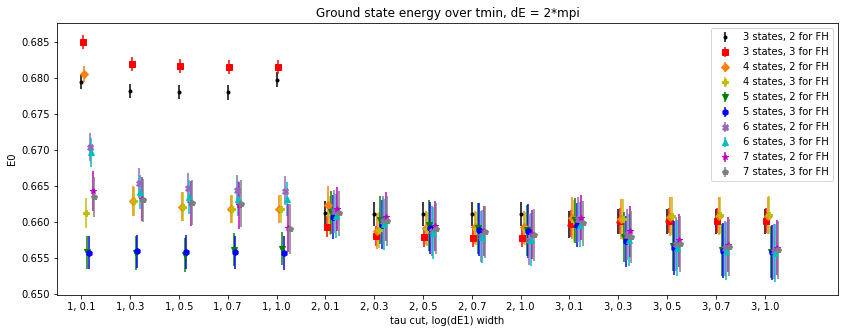

<Figure size 432x288 with 0 Axes>

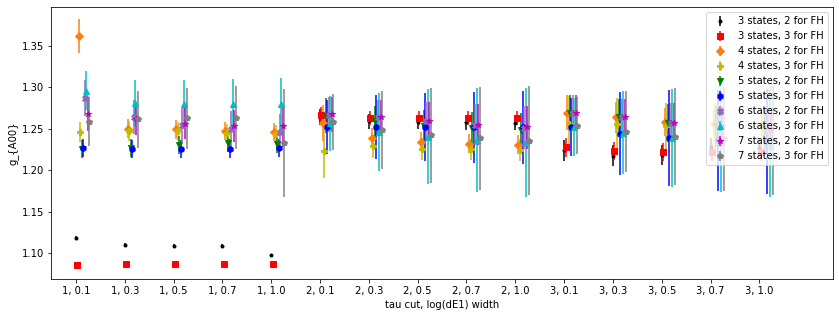

<Figure size 432x288 with 0 Axes>

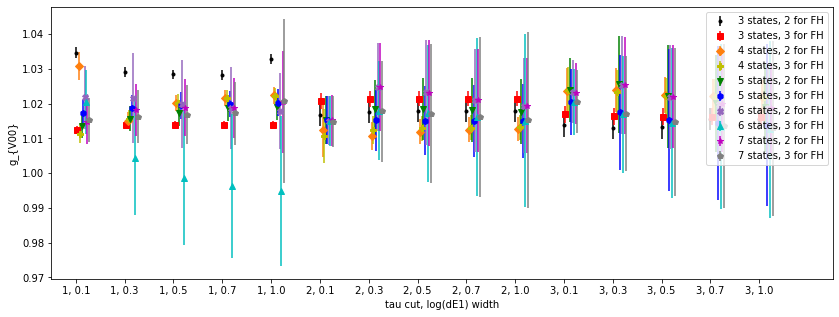

<Figure size 432x288 with 0 Axes>

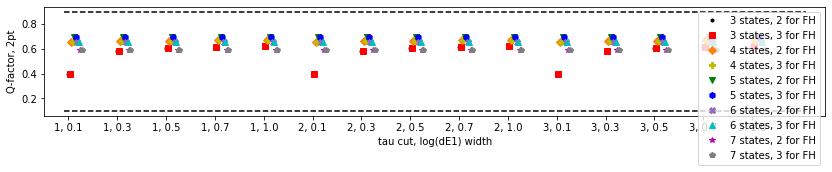

<Figure size 432x288 with 0 Axes>

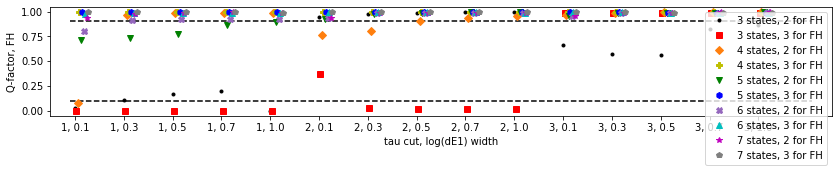

<Figure size 432x288 with 0 Axes>

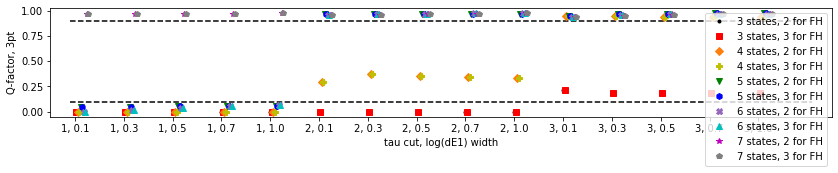

<Figure size 432x288 with 0 Axes>

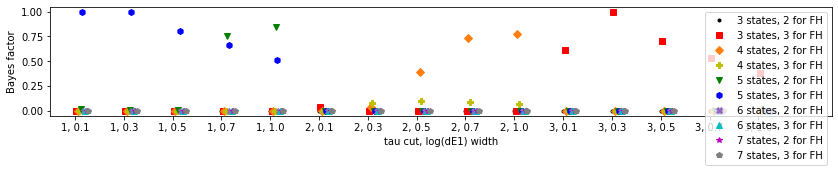

<Figure size 432x288 with 0 Axes>

In [137]:
# First, define colors, markers, and legend labels to be used for each number of states
ax_markers = np.array(['.', 's', 'D', 'P', 'v', 'h', 'X', '^', '*', 'p'])
ax_colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
ax_labels = np.array(["3 states, 2 for FH", "3 states, 3 for FH", "4 states, 2 for FH", "4 states, 3 for FH", \
                      "5 states, 2 for FH", "5 states, 3 for FH", "6 states, 2 for FH", "6 states, 3 for FH", \
                      "7 states, 2 for FH", "7 states, 3 for FH",])






# Set an x-array to map the results to the graph
ax_ensemble_to_x_map = np.arange(0, 15, 1)
xticlocs = np.arange(0, 15, 1)
xticklabels = np.array(["1, 0.1", \
                        "1, 0.3", \
                        "1, 0.5", \
                        "1, 0.7", \
                        "1, 1.0", \
                        "2, 0.1", \
                        "2, 0.3", \
                        "2, 0.5", \
                        "2, 0.7", \
                        "2, 1.0", \
                        "3, 0.1", \
                        "3, 0.3", \
                        "3, 0.5", \
                        "3, 0.7", \
                        "3, 1.0"])



# Now create an "upper bound" and "lower bound" plot on Q
samp_line = np.linspace(-0.1,15.1,500)
Q_01_line = np.linspace(0.1,0.1,500)
Q_09_line = np.linspace(0.9,0.9,500)

# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a0_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a0_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi")
plt.ylabel("E0")

plt.legend(loc = 'upper right')
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a0_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a0_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend(loc = 'upper right')
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a0_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a0_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend(loc = 'upper right')
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, FH")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, FH")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()

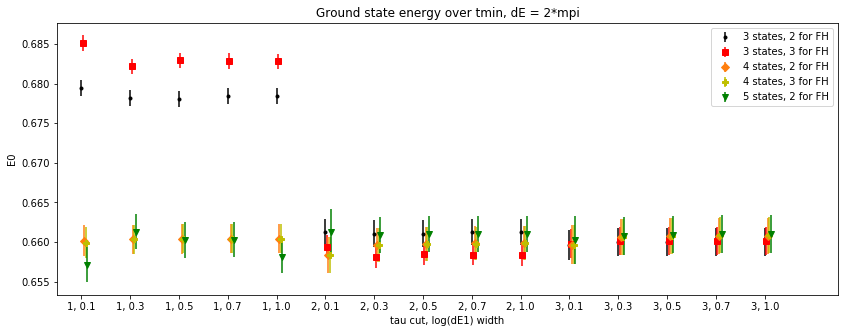

<Figure size 432x288 with 0 Axes>

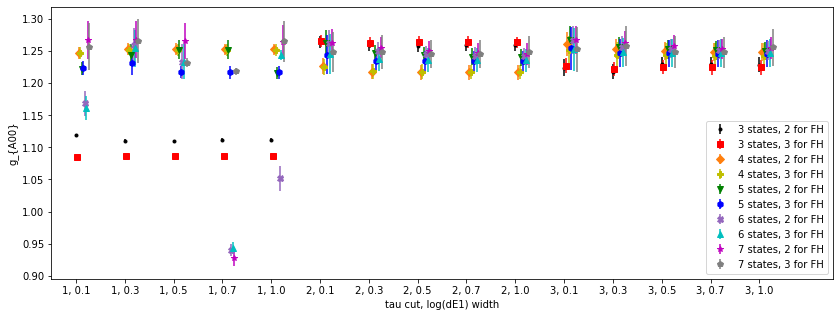

<Figure size 432x288 with 0 Axes>

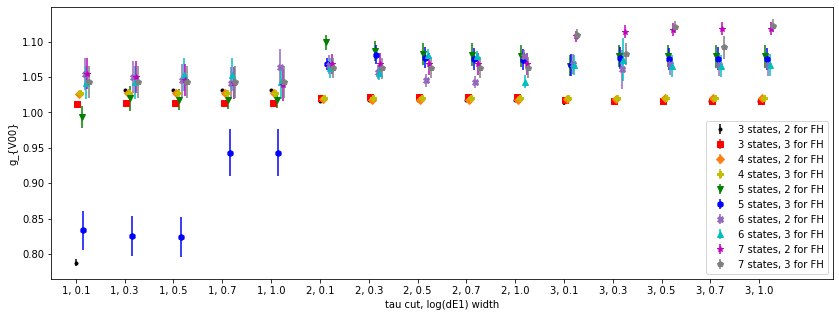

<Figure size 432x288 with 0 Axes>

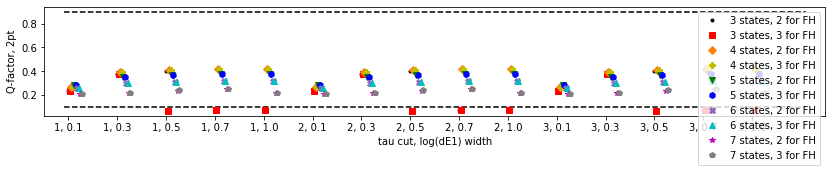

<Figure size 432x288 with 0 Axes>

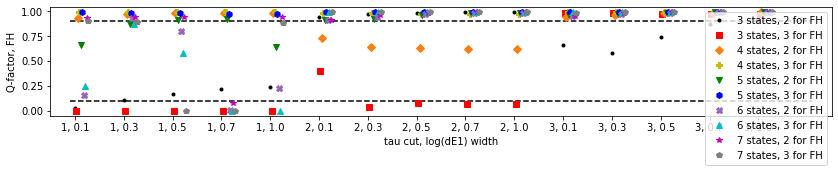

<Figure size 432x288 with 0 Axes>

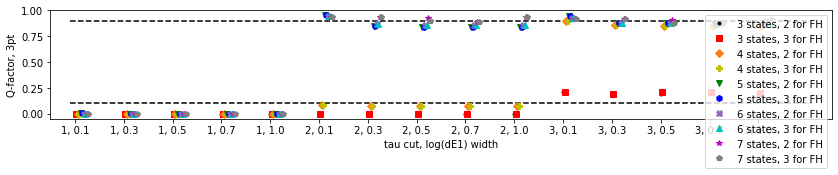

<Figure size 432x288 with 0 Axes>

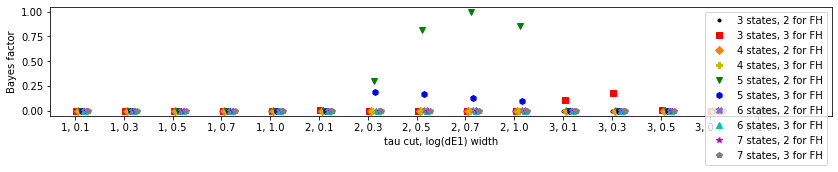

<Figure size 432x288 with 0 Axes>

In [135]:
# 1/n
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a1_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a1_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a1_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a1_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a1_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a1_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, FH")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, FH")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()

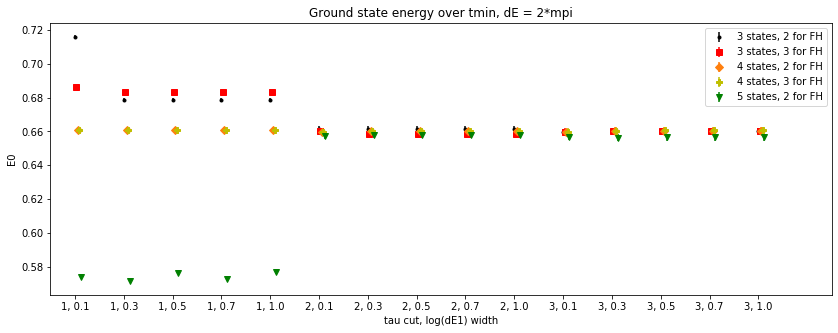

<Figure size 432x288 with 0 Axes>

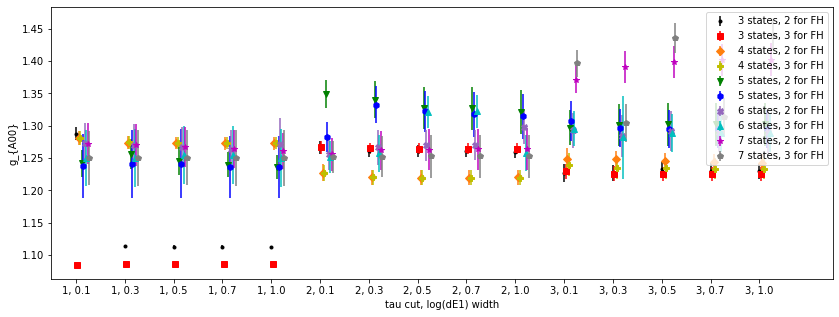

<Figure size 432x288 with 0 Axes>

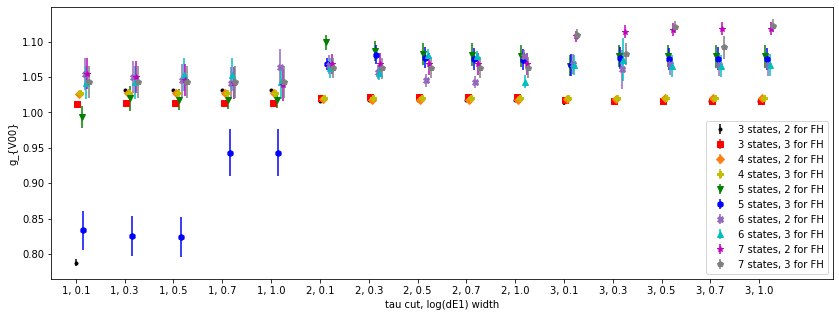

<Figure size 432x288 with 0 Axes>

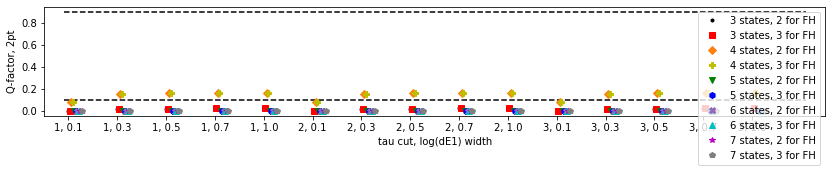

<Figure size 432x288 with 0 Axes>

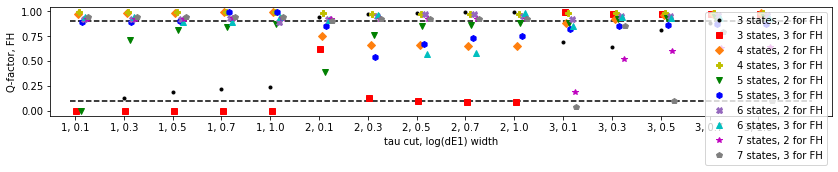

<Figure size 432x288 with 0 Axes>

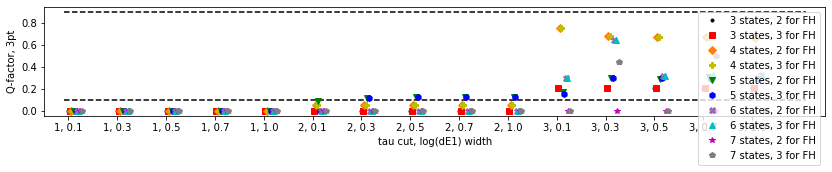

<Figure size 432x288 with 0 Axes>

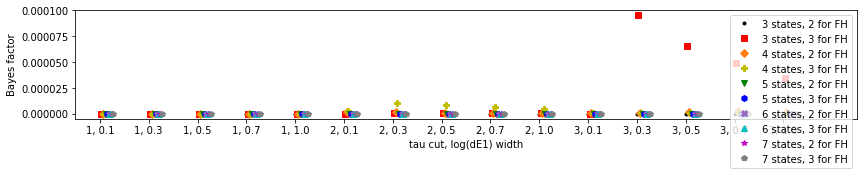

<Figure size 432x288 with 0 Axes>

In [136]:
# 1/n^2
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a2_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a2_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a2_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a2_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a2_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a2_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, FH")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, FH")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()